In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.4     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "items-data-3"    "items-ff-final4" "items5"

In [2]:
library(dplyr)
library(devtools)
library(stats)
library(class)
library(ggplot2)
library(lubridate)
library(MESS)
library(rcompanion)
library(lsr)
library(dplyr)
library(glmnet)
library(caret)
library(gridExtra)
library(grid)
library(ggplot2)
library(lattice)
library(tidyverse)
library(data.table)
library(corrgram)
library(ggcorrplot)
library(dgof)

Loading required package: usethis


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-1

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘corrgram’


Th

In [3]:
############################################################################
#####   Package mechkar                                                 ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2017-05-01                                       ####
############################################################################

############################################################################
#####   DATA VISUALIZATION                                              ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2014-03-12                                       ####
#####   Last Modified: 2020-11-03                                       ####
############################################################################

###########  Functions   ##############################################

###################################################

exploreData <- function(data=data, y=NULL, rn=NULL, factorSize=10, dir=tempdir(), debug=FALSE, ...) {

  whatVarType <- function(var) {
    suppressWarnings(if (var=="integer" | var=="numeric") {
      return(1)
    } else if (var=="factor" | var=="character") {
      return(2)
    } else if (var=="Date" | "POSIXct" %in% var[[1]]) {
      return(3)
    } else {
      return(0)
    })
  }

  drawHistogram <- function(imgname=imgname, x=x) {
    d=stats::density(x, kernel = "gaussian",na.rm=TRUE)
    breakstar=(max(x,na.rm=TRUE) -min(x,na.rm=TRUE))/d$bw
    h=graphics::hist(x, breaks=breakstar)
    graphics::plot(h,main="",xlab=imgname)
    yfit<-seq(min(x,na.rm=TRUE),max(x,na.rm=TRUE),length=40)
    ffit<-stats::dnorm(yfit,mean=mean(x,na.rm=TRUE),sd=stats::sd(x,na.rm=TRUE))
    ffit <- ffit*diff(h$mids[1:2])*length(x)
    lines(yfit, ffit, col="blue", lwd=2)
  }

  drawFakeGraph <- function(imgname=imgname) {
    graphics::plot.window(xlim = c(0,0),ylim = c(0,0))
  }

  drawBars <- function(imgname=imgname, x=x) {
    graphics::plot(x)
  }

  drawGraphOne <- function(imgname=imgname, numVar=x, vartype=1) {
    if(vartype==1) {
      drawHistogram(imgname,numVar)
    } else if(vartype==2) {
      drawBars(imgname,numVar)
    } else {
      drawFakeGraph(imgname)
    }
  }

  getContinuousStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    ma <- mean(x, na.rm=TRUE)
    s <- stats::sd(x, na.rm=TRUE)
    me <- formatC(stats::median(x, na.rm=TRUE))
    q1 <- formatC(stats::quantile(x,1/4, na.rm=TRUE))
    q3 <- formatC(stats::quantile(x,3/4, na.rm=TRUE))
    mn <- formatC(min(x, na.rm=TRUE))
    mx <- formatC(max(x, na.rm=TRUE))
    html <- paste("<div class='Cell' style='align: top;'> <u>Data type</u>: Continuous <p> <u>Data length</u>: ",n ,"/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%)<p> <u>Mean</u>: ", formatC(ma), "\t <u>StdDev</u>: ", formatC(s), "<br><u>Median</u>: ",me,
                  "\t <u>IQR</u>: ", q1, "-", q3, "<br><u>Min</u>: ", mn, "\t <u>Max</u>: ", mx, "</div>")
    return(html)
  }

  getCategortyStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    l <- levels(x)
    s <- summary(x)
    htm <- "<ul>"
    if (length(l) < 5) {
      for (lv in l) {
        htm <- paste(htm, "<li><u>", lv, "</u>: ", s[[lv]], "</li>")
      }
      htm <- paste(htm,"</ul>")
    }
    html <- paste("<div class='Cell'> <u>Data type</u>: Categorical Data <p> <u>Data length</u>: ",n, "/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%) <p> <u>Number of levels</u>: ", length(l), "<br>", htm, "</div>")
    return(html)
  }

  getDatesStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    s <- summary(x)
    html <- paste("<div class='Cell'> <u>Data type</u>: Date <p> <u>Data length</u>: ",n, "/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%) <p> <u>Min date</u>: ", min(x, na.rm=TRUE), "<br><u>Max date</u>:",max(x, na.rm=TRUE) , "</div>")
    return(html)
  }

  getStats <- function(numVar=x, vartype=1) {
    if(vartype==1) {
      html <- getContinuousStats(numVar)
    } else if(vartype==2) {
      html <- getCategortyStats(numVar)
    } else if (vartype==3) {
      html <- getDatesStats(numVar)
    } else {
      html <- "<div class='Cell'></div>"
    }
    return(html)
  }

  getOutliers <- function(x) {
    bp <- graphics::boxplot(x,plot=FALSE)
    return(bp$out)
  }

  getOutlierGraph <- function(x) {
    #  mod <- tryCatch({
    outl <- getOutliers(x)
    df <- data.frame(x=x, cl=1)
    if(length(outl)>0) {
      df$cl[which(df$x %in% outl)] <- 2
    }
    #pl <- stats::scatter.smooth(df$x,col=df$cl)
    pl <- tryCatch({
      stats::scatter.smooth(df$x,col=df$cl,xlab="index")
    }, warning = function(w) {
      suppressWarnings(w)
      #n <- "warning!"
    }, error = function(e) {
      n <- "error!"
    }, finally = {
      graphics::plot(df$x ~ row.names(df),col=df$cl,xlab="index")
    })
    ma <- mean(x, na.rm=TRUE)
    s <- stats::sd(x, na.rm=TRUE)
    graphics::abline(h=ma-(2*s), col="red", lty=2)
    graphics::abline(h=ma+(2*s), col="red", lty=2)
    #  }, error = function(e) {
    #    pl <- drawFakeGraph("none")
    #  })
    return(pl)
  }

  #' @importFrom rlang .data
  getScatterGraph <- function(df=data,x,y,dtype=1) {
    if(dtype==1) {
      pl <- ggplot2::ggplot(df) + ggplot2::geom_smooth(ggplot2::aes(x=.data[[x]], y=.data[[y]]), method="loess") + ggplot2::xlab(x) + ggplot2::ylab(y)
    } else {
      pl <- ggplot2::ggplot(df) + ggplot2::geom_boxplot(ggplot2::aes(y=.data[[x]], color=.data[[y]])) + ggplot2::xlab(x) + ggplot2::ylab(y) + ggplot2::labs(color=y)
    }
    return(pl)
  }

  getOutliersHtml <- function(imgname=imgname, x=x, srcdir=srcdir) {
    bp <- getOutliers(x)
    if (length(unique(bp)) > 10) {
      xtrm <- paste("There are ", length(unique(bp)), " outlier values")
    } else if (length(unique(bp)) == 0) {
      xtrm <- "No outlier values found"
    } else {
      xtrm <- paste(formatC(unique(bp)), collapse=', ' )
    }
    #imgsrc = paste(paste0(srcdir,"/fig/"),imgname, "_2.png",sep="")
    imgsrc = paste(paste0("fig/"),imgname, "_2.png",sep="")
    html <- paste0("<div class='Cell'><img class='origimg' src='",imgsrc,"' height='150' width='250'><br> <u>Outlier values</u>: <br> ", xtrm, "</div>")
    return(html)
  }
  ################## Prepare for the report ###################
  #report <- paste(mydir,"/report",sep="")

  ################## Check for values for rn ##################
  if(!is.null(rn)) {
    if(length(rn)!=ncol(data)) {
      message("the value of the 'rn' argument was avoided because it does not have the same number of columns of the dataframe")
      rn <- NULL
    }
    xname <- rn
    names(xname) <- names(data)
  } else {
    xname <- NULL
  }

  report <- dir
  if (!file.exists(report)) {
    dir.create(report)
  }
  fig <- paste(report,"/fig",sep="")
  if (!file.exists(fig)) {
    dir.create(fig)
  }
  srcdir <- report

  # determine which columns are integer
  int_col <- which(sapply(data, is.integer))
  int_col <- c(int_col,(which(sapply(data, is.numeric))))
  mi <- vector()
  # find only those integers with less than 10 unique values and convert to factor
  for (li in int_col) {
    if (length(unique(data[,li])) < factorSize) {
      mi <- c(mi,li)
      if (is.factor(data[,li]) == FALSE) {
        data[,li] <- factor(data[,li])
      }
    }
  }

  str_col <- which(sapply(data, is.character))
  mi <- vector()
  # find only those integers with less than 10 unique values and convert to factor
  for (li in str_col) {
    mi <- c(mi,li)
    data[,li] <- factor(data[,li])
  }

  # create the html report page
  myhtml <- paste(report,"/report.html",sep="")
  cat("<!DOCTYPE html>
      <html>
      <head>
      <title>Data Visualization</title>
      <meta http-equiv='Content-Type' content='text/html; charset=UTF-8' />
      <link rel='stylesheet' href='http://code.jquery.com/mobile/1.4.5/jquery.mobile-1.4.5.min.css'>
      <script src='http://code.jquery.com/jquery-1.10.2.js'></script>
      <script>
      $(document).ready(function(){
      $('.onetoone').hide();
      });
      $(function() {
      $('.origimg').click(function(e) {
      $('#popup_img').attr('src',$(this).attr('src'));
      $('#myContainer').hide();
      var pos = $(document).scrollTop();
      $('#myContainer').css({'top':pos+20,'left':250, 'position':'absolute', 'border':'1px solid black', 'padding':'0px'});
      $('#myContainer').show();
      });
      $('#myContainer').click(function(e) {
      $('#myContainer').hide();
      });
      $('#myform2').submit(function(e) {
      e.preventDefault();
      });
      $('#onetoone').on('click',function() {
      console.log('onetone button - 1');
      $('#onetoone').hide();
      $('#aslist').show();
      // To show only individual rows:
      $('.Row').hide();
      $('.onetoone').show();
      // then we iterate
      var i = $('.Row').length;
      // Then we iterate
      var nxt = $('#idx').val();
      if (nxt < i & nxt >0) {
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(1)
      }
      console.log('onetone button - 2');
      });
      $('#aslist').on('click',function() {
      console.log('aslist button - 1');
      $('#onetoone').show();
      $('#aslist').hide();
      $('.onetoone').hide();
      $('.Row').show();
      console.log('aslist button - 2');
      });
      $('#less').on('click',function(){
      console.log('less button - 1');
      var i = $('.Row').length;
      var nxt = parseInt($('#idx').val(),10) - 1;
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(1)
      }
      console.log('less button - 2');
      });
      $('#more').on('click',function(){
      console.log('more button - 1');
      var i = $('.Row').length;
      var nxt = parseInt($('#idx').val(),10) + 1;
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(i)
      }
      console.log('more button - 2');
      });
      $('#idx').on('change', function(){
      console.log('idx changed - 1');
      var i = $('.Row').length;
      var nxt = $('#idx').val();
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(i)
      }
      console.log('idx changed - 2');
      });
      });
      </script>
      <style type='text/css'>
      .Table
      {
      display: table;
      }
      .Title
      {
      display: table-caption;
      text-align: center;
      font-weight: bold;
      font-size: larger;
      background-color:#4C6F50;
      color: #fff;
      }
      .Row
      {
      display: table-row;
      }
      .Row:nth-child(even) {
        background-color: #56882433;
      }
      .Cell
      {
      display: table-cell;
      border: solid;
      border-width: thin;
      padding-left: 5px;
      padding-right: 5px;
      vertical-align: top;
      font-family: Arial, Helvetica, sans-serif;
      font-size: 14px;
      }
      </style>
      </head>
      <body>
      <div id='pageone' data-role='main' class='ui-content'>
      ", file = myhtml, sep='\n',append=FALSE)

  html <- paste("<p><p><h1> Data Visualization & Exploration </h1>
                <form>
                <input type='button' id='onetoone' value='Show as Cards'>
                <input type='button' id='aslist' class='onetoone' value='Show as List'>
                </form>
                <p>
                ")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  # begin table
  alt1 <- ifelse(is.null(y)== TRUE, "", "<div class='Cell Title'> Dependent <br> Variable <br> Distribution </div>")
  html <- paste("<p><p>
                <div class='Table'>
                <div class='Row'>
                <div class='Cell Title'> Variable </div>
                <div class='Cell Title'> Distribution </div>
                <div class='Cell Title'> Descriptive <br> Statistics</div>
                <div class='Cell Title'> Outliers </div>"
                , alt1,
                "</div>")
  cat(html, file = myhtml, sep='\n', append=TRUE)

  #### determinate the type of each variable...
  data_types <- sapply(sapply(data, class), whatVarType)
  ln <- length(data)
  ii <- 0
  pb <- utils::txtProgressBar(min=0,max=ln,style=3)
  for(x in names(data)) {

    ## check if the value has at least more than one unique value...
    if(length(unique(data[[x]])) < 2) {
      message(paste("The variable",x,"has less than two unique values, so will not be included"))
    } else {

      if(debug==TRUE) {
        message(x)
      } else {
        pb <- utils::txtProgressBar(min=0,max=ln,style=3)
      }

      html <- paste("<div class='Row'><div class='Cell'><b>",x,"</b><p>",xname[x],"</p></div>")

      cat(html, file = myhtml, sep='\n', append=TRUE)
      #### initialize the first graph
      imgname = paste(fig,"/",x, "_1.png",sep="")
      #imgsrc = paste(paste0(srcdir,"/fig/"),x, "_1.png",sep="")
      imgsrc = paste("fig/",x, "_1.png",sep="")
      ### send the data with the type to generate the correct graph..
      grDevices::png(imgname)
      drawGraphOne(x, data[[x]], data_types[x])
      grDevices::dev.off()
      html <- paste0("<div class='Cell'><img class='origimg'  src='",imgsrc,"' height='150' width='150'><br></div>")
      cat(html, file = myhtml, sep='\n', append=TRUE)

      # second, show the statistics
      html <- getStats(data[[x]],data_types[x])
      cat(html, file = myhtml, sep='\n', append=TRUE)

      # third, determine the outliers
      imgname = paste(fig,"/",x, "_2.png",sep="")
      if(data_types[x]==1) {
        grDevices::png(imgname)
        getOutlierGraph(data[[x]])
        grDevices::dev.off()
        html <- getOutliersHtml(x,data[[x]],srcdir)
      } else {
        html <- "<div class='Cell'></div>"
      }
      cat(html, file = myhtml, sep='\n', append=TRUE)

      # fourth, if y is assigned, make a corresponding plot
      if(is.null(y)==FALSE) {
        imgname = paste(fig,"/",x, "_3.png",sep="")
        #imgsrc = paste(paste0(srcdir,"/fig/"),x, "_3.png",sep="")
        imgsrc = paste("fig/",x, "_3.png",sep="")
        grDevices::png(imgname)
        ### scatter.smooth(data[[x]] ~ data[[y]])
        #suppressWarnings(getScatterGraph(data,x,y,data_types[y]))
        plot(getScatterGraph(data,x,y,data_types[y]))
        grDevices::dev.off()
        html <- paste0("<div class='Cell'><img class='origimg' src='",imgsrc,"' height='150' width='150'><br></div>")
        cat(html, file = myhtml, sep='\n', append=TRUE)
      }
      html <- paste("</div>")
      cat(html, file = myhtml, sep='\n', append=TRUE)

      if(debug==FALSE) {
        utils::setTxtProgressBar(pb,ii)
        ii <- ii + 1
      }
    }
  }
  utils::setTxtProgressBar(pb,ln)
  html <- paste("</div>")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  # end table
  html <- paste("</div>
                <div data-role='popup' id='myContainer' style='display: none;'>
                <img id='popup_img' src='' />
                </div>
                </div>
                </div>
                </div>
                <p>
                <div class='onetoone'>
                <form id='myform2'>
                <span> <input type='button' id='less' value=' << '> </span>
                <span> <input id='idx' name='idx' value='1'></input></span>
                <span> <input type='button' id='more' value=' >> '> </span>
                </form>
                </div>
                <p>
                </body></html>
                ")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  ## call the default browser or the one which is open (if any)
  browseURL(myhtml)
}

###################### END exploreData ###############


############################################################################
#####   TABLE 1                                                         ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-03-09                                       ####
#####   Last Modified: 2020-11-03                                       ####
############################################################################

####################  FUNCTIONS  ###########################################
#### Usage:
####   x: character vector with the name of the variables
####   y: the name of the strata variable (optional)
####   rn: character vector with the text we want to replace the variable names
####   data: the dataset to be used
####   miss: include missing statistics: [0=none, 1=only for categorical variables, 2=for all variables]
####   excel: export the table to excel [0=no, 1=yes]
####   excel_file: the name of the excel file we want to save the table (optional)
####
###################

Table1 <- function(x=NULL, y=NULL, rn=NULL, data=NULL, miss=3, catmiss=TRUE, formatted=TRUE, categorize=FALSE,
                    factorVars=NULL, maxcat=10, delzero=TRUE, decimals=1, messages=TRUE, excel=0, excel_file=NULL,
                    debug=FALSE) {
  ### define sub-functions
  Del <- NULL
  Pop <- NULL
  n <- NULL
  g1 <- function(var)c(Mean=mean(var,na.rm=TRUE), SD=stats::sd(var,na.rm=TRUE))
  g2 <- function(var)c(Median=stats::median(var,na.rm=TRUE), IQR=stats::quantile(var,c(0.25,0.75),na.rm=TRUE))
  msg <- NULL
  
  ### function for transforming variables to factors
  setFactors <- function(data=data, factorVars=factorVars, catmiss=catmiss, maxcat=maxcat) {
    if(is.null(factorVars)==TRUE) {
      aa <- sapply(sapply(data, unique), length)
      factorVars <- names(which(aa <= maxcat))
    }
    for (v in factorVars) {
      ct <- ifelse( ((is.null(factorVars)==FALSE & (v %in% factorVars)) | (is.null(factorVars)==TRUE & length(unique(data[[v]])) <= maxcat)),1,0)
      if (ct == 1) {
        data[[v]] <- factor(data[[v]])
        if(catmiss == TRUE & sum(is.na(data[[v]])==TRUE) > 0) {
          data[[v]] <- factor(data[[v]],levels=c(levels(data[[v]]),"Missing"))
          data[[v]][which(is.na(data[[v]])==TRUE)] <- "Missing"
        }
      }
    }
    return(data)
  }
  ### proceed to convert varibles to factors
  if (categorize == TRUE | is.null(factorVars)==FALSE ) {
    data <- setFactors(data, factorVars, catmiss, maxcat)
  }
  
  getSimpleTable  <- function(x=x, rn=rn, data=data, miss=miss, catmiss=catmiss,formatted=formatted,
                              categorize=categorize,maxcat=maxcat, delzero=delzero) {
    if (is.null(x)==TRUE) { x <- names(data)}
    if (is.null(rn)==TRUE) { rn <- x}
    ln <- length(x)
    pb <- utils::txtProgressBar(min=0,max=ln,style=3)
    msg <- NULL
    ### define the column names
    tableaaaa <- cbind(Del="Del",V1="Variables",V2="Categories",n="n","Population")
    tablebbbb <- cbind(Del="Del",V1="Variables",V2="Categories",n="n",val1="val1",val2="val2",val3="val3")
    tbl1 <- cbind(0,"Individuals","n",n=1, nrow(data))
    tbl2 <- cbind(0,"Individuals","n",n=1, nrow(data),NA,NA)
    tableaaaa <- rbind(tableaaaa,tbl1)
    tablebbbb <- rbind(tablebbbb,tbl2)
    q <- 1
    n <- 1
    ii <- 1
    for (v in x)
    {
      if (v %in% names(data)) {
        ### define if the actual variable has to be treated as numeric or factor
        ct <- ifelse(is.numeric(data[[v]])==TRUE & categorize==TRUE &
                       ((is.null(factorVars)==FALSE & (v %in% factorVars)) |
                          (is.null(factorVars)==TRUE & length(unique(data[[v]])) <= maxcat)),1,0)
        ### treat as numeric
        if (length(unique(data[v]))==0) {
          if (messages==TRUE) {
            msg <- c(msg, paste("The variable",v,"has no data; avoided"))
          }
        } else if (inherits(data[[v]], "Date")==TRUE) {
          if (messages==TRUE) {
            msg <- c(msg, paste("The variable",v,"is a date. Dates are not allowed in Table1; avoided"))
          }
        } else if (is.numeric(data[[v]])==TRUE & ct==0) {
          ## report mean and standard deviation
          t_n <- g1(data[[v]])
          tp <- paste(format(round(t_n[1],decimals),nsmall=1,big.mark=",")," (", format(round(t_n[2],decimals),nsmall=1,big.mark=","),")",sep="")
          tbl1 <- cbind(0,rn[q],"Mean (SD)",n=1, tp)
          tbl2 <- cbind(0,rn[q],"Mean (SD)",n=1,t_n[1],t_n[2],NA)
          tableaaaa <- rbind(tableaaaa,tbl1)
          tablebbbb <- rbind(tablebbbb,tbl2)
          ## report median and Interquartile ranges (25%,75%)
          t_n <- g2(data[[v]])
          tp <- paste(format(round(t_n[1],decimals),nsmall=1,big.mark=",")," (", format(round(t_n[2],decimals),nsmall=1,big.mark=","),"-", format(round(t_n[3],decimals),nsmall=1,big.mark=","), ")",sep="")
          tbl1 <- cbind(0,rn[q],"Median (IQR)",n=2, format(tp,big.mark=","))
          tbl2 <- cbind(0,rn[q],"Median (IQR)",n=2,t_n[1],t_n[2],t_n[3])
          tableaaaa <- rbind(tableaaaa,tbl1)
          tablebbbb <- rbind(tablebbbb,tbl2)
          ## report number and percent of missing
          if (miss >= 1) {
            datams <- subset(data,is.na(data[[v]])==TRUE)
            if (nrow(datams)>0) {
              data$cnt <- 1
              datams$cnt <- 1
              t_n <- table(data$cnt)
              t_m <- sum(datams$cnt)
              tp <- paste(format(t_m,big.mark=",")," (",format(round((t_m/t_n)*100,decimals),nsmall=1,big.mark=","),"%)",sep="")
              tbl1 <- cbind(0,rn[q],"Missing (%)",n=3, tp)
              tbl2 <- cbind(0,rn[q],"Missing (%)",n=3, t_m, (t_m/t_n)*100, NA)
            } else {
              tbl1 <- cbind(1,rn[q],"Missing (%)",n=3, " -- ")
              tbl2 <- cbind(1,rn[q],"Missing (%)",n=3, NA, NA, NA)
            }
            tableaaaa <- rbind(tableaaaa,tbl1)
            tablebbbb <- rbind(tablebbbb,tbl2)
          }
        } else {
          t_n <- table(data[[v]])
          ttotal <- sum(t_n)
          nm <- row.names(t_n)
          for (f in 1:length(nm)) {
            del1 <- ifelse(length(nm)==2 & (nm[f]=="No" | nm[f]=="no" | nm[f]==0 | nm[f]=="0" | nm[f]=="None" | nm[f]=="none"),1,0)
            tp <- t_n[f] / ttotal * 100
            pct <- paste(format(round(t_n[f],decimals),nsmall=0,big.mark=",")," (", format(round(tp,decimals),nsmall=1,big.mark=","), "%)",sep="")
            tbl1 <- cbind(del1,rn[q],nm[f],n=f, pct)             ########### delete rows 0/1 !!!!!!!!!
            tbl2 <- cbind(del1,rn[q],nm[f],n=f, t_n[f], tp, NA)  ########### delete rows 0/1 !!!!!!!!!
            tableaaaa <- rbind(tableaaaa,tbl1)
            tablebbbb <- rbind(tablebbbb,tbl2)
          }
          if (miss >= 2 & catmiss==FALSE ) {
            datams <- subset(data,is.na(data[[v]])==TRUE)
            if (nrow(datams)>0) {
              data$cnt <- 1
              datams$cnt <- 1
              t_n <- table(data$cnt)
              t_m <- sum(datams$cnt)
              tp <- paste(format(t_m,big.mark=",")," (",format(round((t_m/t_n)*100,decimals),nsmall=1,big.mark=","),"%)",sep="")
              tbl1 <- cbind(0,rn[q],"Missing (%)",n=f, tp)
              tbl2 <- cbind(0,rn[q],"Missing (%)",n=f, t_m, (t_m/t_n)*100, NA)
            } else {
              tbl1 <- cbind(1,rn[q],"Missing (%)",n=f, " -- ")
              tbl2 <- cbind(1,rn[q],"Missing (%)",n=f, NA, NA, NA)
            }
            tableaaaa <- rbind(tableaaaa,tbl1)
            tablebbbb <- rbind(tablebbbb,tbl2)
          }
        }
      } else {
        if (messages==TRUE) {
          msg <- c(msg, paste("The variable",v,"doesn't exists in the dataset; avoiding"))
        }
      }
      q <- q + 1
      if(debug==FALSE) {
        utils::setTxtProgressBar(pb,ii)
        ii <- ii + 1
      } else {
        message(v)
      }
    }
    if(formatted==TRUE) {
      return(tableaaaa)
    } else {
      return(tablebbbb)
    }
    close(pb)
  }
  
  pvals <- function(x=x,y=y,rn=rn,data=data,categorize=categorize,maxcat=maxcat) {
    ptab <- NULL
    if (is.null(y)==FALSE) {
      if (y %in% names(data)) {
        if (is.null(x)==TRUE) { x <- names(data)}
        if (is.null(rn)==TRUE | length(rn)<2) {rn <- x}
        q <- 1
        ptab <- cbind(V="Variables",pval="pval", n="n")
        
        ln <- length(x)
        ii <- 0
        pb <- utils::txtProgressBar(min=0,max=ln-1,style=3)
        
        for (v in x) {
          if (v %in% names(data)) {
            ct <- ifelse(is.numeric(data[[v]])==TRUE & categorize==TRUE & length(unique(data[[v]])) <= maxcat,1,0)
            if (is.numeric(data[[y]])==TRUE & categorize==TRUE & length(unique(data[[y]])) <= maxcat) {
              data[[y]] <- as.factor(data[[y]])
            } else if (is.numeric(data[[y]])==TRUE) {
              if (messages==TRUE) {
                msg <- c(msg, paste("The variable",y,"is not a factor. Please convert to factor or change the 'categorize' flag to TRUE."))
              }
              pval <- "Please rerun!!!"
            }
            if (is.numeric(data[[v]])==TRUE & length(unique(data[[v]])) > 1 & ct == 0) {
              ### first check for homoscedasticity
              tryCatch({
                if (stats::bartlett.test(data[[v]], data[[y]])[3] >= 0.05) {
                  pval <- suppressMessages(round(as.numeric(suppressMessages(car::Anova(stats::lm(data[[v]] ~ data[[y]])))[1, 4]), 3))
                } else {
                  pval <- suppressMessages(round(as.numeric(suppressMessages(car::Anova(stats::lm(data[[v]] ~ data[[y]]), white.adjust = TRUE))[1, 3]), 3))
                }
              }, warning = function(w) {
                suppressWarnings(w)
                #ww <- "suppress warnings"
              }, error = function(e) {
                pval <- "---"
              })
            } else if (length(unique(data[[v]]))==1) {
              pval <- NA
            } else {
              if(length(unique(data[[v]])) < 15) {
                if (min(table(data[[v]],data[[y]])) > 5) {
                  pval <- round(as.numeric(stats::chisq.test(data[[v]],data[[y]])$p.val),3)
                } else {
                  if(min(table(data[[v]],data[[y]]))==0) {
                    #in cases where there are cells with zero, we use Fisher's exact test
                    tryCatch(
                      pval <- round(as.numeric(stats::fisher.test(data[[v]],data[[y]], workspace=1e9)$p.val),3),
                      error = function(e) {msg <- c(msg,paste0("Unable to calcualte the Fisher test for variables ",v," and ",y))})
                  } else {
                    pval <- round(as.numeric(stats::kruskal.test(data[[v]],data[[y]], workspace=1e9)$p.val),3)
                  }
                }
              } else {
                pval <- NA
              }
            }
            ptab <- rbind(ptab,cbind(V=rn[q],pval=pval,n=2))
          }
          if(debug==FALSE) {
            utils::setTxtProgressBar(pb,ii)
            ii <- ii + 1
          }
          q <- q + 1
        }
      }
    }
    return(ptab)
  }
  ####################### Begin analysis
  ##### check for x's witch have one unique values, get them out.
  vv <- NULL
  j <- 0
  jj <- NULL
  for(v in x) {
    if(length(unique(data[[v]])) < 2) {
      vv <- c(vv,v)
      j <- j + 1
      jj <- c(jj,j)
    }
  }
  
  if (length(vv)>0) {
    warning(paste("The following variables have unique values and will not be included in the analysis:",vv))
    x <- setdiff(x, vv)
    if(is.null(rn)==FALSE & length(jj)>0) {
      rn <- rn[-jj]
    }
  }
  
  ##### if y is null then make a simple table
  tabaaa1 <- getSimpleTable(x=x, rn=rn, data=data, miss=miss, catmiss=catmiss,formatted=formatted,categorize=categorize,maxcat=maxcat, delzero=delzero)
  tabaaa1 <- as.data.frame(tabaaa1)
  ############################  CHANGE TO 5 !!!!!!!!!!!!!!
  if(length(tabaaa1) > 5) {
    names(tabaaa1) <- c("Del","V1","V2","n","Pop","pop2","pop3")
  } else {
    names(tabaaa1) <- c("Del","V1","V2","n","Pop")
  }
  ##### if y has two levels, then make a compound comparison
  if (is.null(y)==FALSE){
    if (y %in% names(data)) {
      if (is.factor(data[[y]])==FALSE) {
        if (length(levels(factor(data[[y]]))) > 8) {
          if (messages==TRUE) {
            message("The dependent variable has more than 8 levels, table too large!")
          }
        } else if(min(table(data[[y]]))==0) {
          message("The dependent variable has one or more levels with no individuals assigned!")
        } else {
          data[[y]] <- factor(data[[y]])
        }
      }
      if (length(levels(data[[y]])) >= 2) {
        for (lv in levels(data[[y]])) {
          dtsub <- subset(data, data[[y]]==lv)
          tab <- getSimpleTable(x=x, rn=rn, data=dtsub, miss=miss, catmiss=catmiss, formatted=formatted,categorize=categorize,maxcat=maxcat, delzero=delzero)
          tab <- data.frame(tab)
          ############################  
          if(length(tab) > 5) {
            names(tab) <- c("Del","V1","V2","n",paste0(lv,"_1"),paste0(lv,"_2"),paste0(lv,"_3"))
          } else {
            names(tab) <- c("Del","V1","V2","n",lv)
          }
          ############################  
          tab[1,5] <- lv
          tabaaa1 <- base::merge(tabaaa1, tab, all.x=TRUE)
        }
        # what to do with dichotomous variables? We remove the "Zero" label
        # clean unnecesary rows
        if (delzero == TRUE) {
          tabaaa1 <- tabaaa1[tabaaa1$Del==0,]
        }
        ### calculate the p-value
        ptab <- data.frame(pvals(x=x,y=y,rn=rn,data=data,categorize=categorize,maxcat=maxcat))
        names(ptab) <- c("V1","pval","n")
        tabaaa1 <- base::merge(tabaaa1, ptab,all.x=TRUE)
        tabaaa1 <- tabaaa1[tabaaa1$Pop != " -- ",]
      }
    }
  }
  
  tabaaa1$n <- NULL
  tabaaa1$Del <- NULL
  ### format the table for printing
  n <- ncol(tabaaa1)
  names(tabaaa1)[1] <- "Variables"
  names(tabaaa1)[2] <- ""
  names(tabaaa1)[3] <- "Population"
  names(tabaaa1)[n] <- "p-value"
  tabaaa1[,n] <- as.character(tabaaa1[,n])
  tabaaa1[,n] <- ifelse(is.na(tabaaa1[,n]),"",tabaaa1[,n])
  tabaaa1[,n] <- ifelse(tabaaa1[,n]=='0',"<0.001",tabaaa1[,n])
  
  ##### check for export to excel
  if (excel==1) {
    writexl::write_xlsx(tabaaa1,excel_file)
    return(tabaaa1)
  } else {
    return(tabaaa1)
  }
}

########################## END Table1 ###############


############################################################################
#####   TEST & TRAIN DATASET GENERATION                                 ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-08-17                                       ####
#####   Last Modified: 2020-11-03                                       ####
############################################################################

train_test <- function(data=NULL,train_name=NULL,test_name=NULL,prop=NULL,seed=123,tableone=FALSE)
{
  pval <- NULL
  checkTrainTest <- function(train=NULL,test=NULL) {
    train[["traintest_ind_"]] <- 1
    test[["traintest_ind_"]] <- 2
    df <- rbind(train, test)
    tab <- Table1(data=df, y="traintest_ind_",messages = FALSE)
    vars <- subset(tab, pval < 0.05)$V1
    vars <- setdiff(vars,"traintest_ind_")
    if (length(vars)==0) {
      message(" ")
      message("You got a perfectly balanced training and test datasets")
      message(" ")
    } else {
      message("WARNING: The following variables are not balanced between the training and test datasets:")
      for (v in vars) { message(paste("*",v)) }
      message("You can try to change the seed value until you get a balanced partition.")
      message("Alternatively, you can ommit this warning and exclude those variables from your model")
      message(" ")
    }
    return(tab)
  }
  nm <- 1
  ttenv = as.environment(nm)
  ## set the seed to make your partition reproductible
  set.seed(seed)
  smp_size <- floor(prop * nrow(data))
  train_ind <- sample(seq_len(nrow(data)), size = smp_size)
  assign(train_name, data[train_ind, ], envir=ttenv)
  assign(test_name, data[-train_ind, ], envir=ttenv)
  message(paste("Dataset partitioned into:"))
  message(paste(" + Train dataset:", train_name))
  message(paste(" + Test dataset:", test_name))
  if(tableone==TRUE) {
    tab <- checkTrainTest(get(train_name),get(test_name))
    tab <- tab[tab[,1]!="traintest_ind_",]
    names(tab)[4] <- train_name
    names(tab)[5] <- test_name
    return(tab)
  }
}


######################### END train_test ###############


############################################################################
#####   TABLE 2                                                         ####
#####   Description: calculates the Odds/Hazard ratios and their        ####
#####     confidence intervals from a given model
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-03-09                                       ####
#####   Last Modified: 2018-04-16                                       ####
############################################################################

Table2 <- function(mod, rv=NULL,level=0.95, decimals=3) {
  alpha <- 1-level
  msm <- suppressMessages(summary(mod))
  if(rlang::has_name(msm,"coefficients")==TRUE) {
    msm <- msm$coefficients
  } else if(rlang::has_name(msm,"coef")==TRUE) {
    msm <- msm$coef
  }
  if("coxph" %in% class(mod)) {
    exp_coef <- msm[,1]
    dd <- suppressMessages(exp(stats::confint(mod, level=level)))
    dd1 <- round(dd[,1],decimals)
    dd2 <- round(dd[,2],decimals)
    p_value <- round(msm[,ncol(msm)],decimals)
  } else {
    ciz <- stats::qnorm(1-(alpha/2))
    exp_coef <- exp(msm[, 1])
    se_exp_coef <- msm[,2] * exp_coef
    dd1 <- round(exp_coef - ciz * se_exp_coef, decimals)
    dd2 <- round(exp_coef + ciz * se_exp_coef, decimals)
    exp_coef <- round(exp_coef, decimals)
    z<- abs((exp_coef-1)/se_exp_coef)
    p_value <- round(2*(1-stats::pnorm(z)), decimals)
  }
  tb <- data.frame(cbind(Estimate=exp_coef,'CI_lo'=dd1,'CI_hi'=dd2,'p value'=p_value))
  if (is.null(rv)==FALSE) {
    row.names(tb) <- rv
  } else {
    row.names(tb) <- names(mod$coefficients)
  }
  return(tb)
}

############################################################################
#####   TABLE2 WITH FORESTPLOT                                          ####
#####   Description: Generates a publication ready version of a model   ####
#####      risk table with a forestplot graph inside it                 ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2018-05-17                                       ####
############################################################################
Table2.forestplot <- function(mod, nr=NULL) {
  opar <- graphics::par(no.readonly = TRUE)
  on.exit(graphics::par(opar))
  tryCatch({tbA <- Table2(mod)},
           error=function(cond) {
             message("This model type is not supported !")
             return(NA)
           })
  if(exists("tbA")) {
    ## max value for x axis
    xmax <- max(tbA[,3])
    if(xmax < 5) {
      #axis(1, seq(0,xmax,by=.5), cex.axis=.5)
     rh <- 12
    } else {
      rh <- 18
    }
    colnames(tbA) <- c("coef","ci_low","ci_high","p_value")
    j <- nrow(tbA)
    nm <- row.names(tbA)
    rowseq <- seq(nrow(tbA),1)
    graphics::par(mai=c(1,0,0,0),new=FALSE)
    graphics::plot(tbA$coef, rowseq, pch=15,
         xlim=c(-10,rh), ylim=c(0,j+3),
         xlab='', ylab='', yaxt='n', xaxt='n',
         bty='n')
    for (i in 1:j) {
      graphics::abline(h=i-0.5,lwd=1, lty=3, col="gray")
    }
    graphics::par(new=TRUE)
    graphics::plot(tbA$coef, rowseq, pch=15,
         xlim=c(-10,rh), ylim=c(0,j+3),
         xlab='', ylab='', yaxt='n', xaxt='n',
         bty='n')
    graphics::axis(1, seq(0,xmax,by=.5), cex.axis=.5)
    graphics::segments(1,-1,1,j, lty=3)
    graphics::segments(tbA$ci_low, rowseq, tbA$ci_hi, rowseq)
    graphics::mtext('Lower risk',1, line=2.5, at=0, cex=.5, font=2)
    graphics::mtext('Higher risk',1.5, line=2.5, at=2, cex=.5, font=2)
    if (is.null(nr)) {
      nr <- data.frame(vars=names(mod$coefficients))
      col2 <- as.character(gsub(x=nr$vars, pattern=paste(names(mod$xlevels),collapse="|"),replacement=" "))
      col3 <- data.frame(vars=as.character(NULL),col3=as.character(NULL))
      for(n in names(mod$xlevels)) {
        col3 <- rbind(col3, cbind(vars=paste(n,levels(mod$data[[n]])[2],sep=""),col3=n))
      }
      nr$col1 <- ifelse(nr$vars %nin% setdiff(names(mod$coefficients),names(mod$data)),as.character(nr$vars),'')
      nr$col2 <- ifelse(nr$vars %nin% col2, col2, " ")
      nr[1,"col1"] <- ifelse(nr[1,"vars"]=="(Intercept)","(Intercept)",nr[1,"vars"])
      nr$col1 <- ifelse(nr$vars %in% col3, col3, nr$col1)
      nr <- merge(nr,col3, x.all=TRUE)
      nr$col1 <- ifelse(is.na(nr$col3)==TRUE,nr$col1,as.character(nr$col3))
      nr$col1 <- ifelse(grepl(":",nr$vars),nr$vars,nr$col1)
    } else {
      nr <- data.frame(vars=nr)
      if (length(nm)==nrow(nr)) {
        nr <- cbind(nm,nr)
        colnames(nr) <- c("vars","col1","col2")
      } else {
        return("The number of variables in the table of names (nr) you give is not equal to the number of variables in the model.
               Please check the names you entered in the table.")
      }
    }
    ### this part writes the variable titles
    graphics::text(-10,j+2, "Variables", cex=.75, font=2, pos=4)
    graphics::abline(h=j+1, col="gray", lwd=1.5, lty=1)
    graphics::text(-10,rowseq, nr[,2], cex=.75, pos=4, font=3)
    ### and this writes the categories for nominal variables
    graphics::text(-6,rowseq, nr[,3], cex=.75, pos=4)
    graphics::text(-3,j+2, "Odds Ratio (95% CI)", cex=.75, font=2, pos=4)
    t3 <- ifelse(!is.na(tbA$coef),
                 with(tbA, paste(format(coef,nsmall = 3,digits = 3),' (',format(ci_low,nsmall = 3,digits = 3),'-',format(ci_high,nsmall = 3,digits = 3),')',sep='')), '')
    graphics::text(xmax,rowseq, t3, cex=.75, pos=4, bg="lightgreen")
    graphics::text(xmax+5,j+2, "P Value", cex=.75, font=2, pos=4)
    t4 <- ifelse(!tbA$p_value==0, paste0(" ",format(tbA$p_value,nsmall = 3,digits = 3)), '<0.001')
    graphics::text(xmax+5,rowseq, t4, cex=.75, pos=4)
    graphics::box(which = "outer",col="darkgray",lwd=3)
  }
  graphics::par(mai=c(1,1,1,1),new=FALSE)
}

############################################################################
#####   CALCULATE CONFIDENCE INTERVALS FOR MEANS                        ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-08-24                                       ####
############################################################################
MeanCI <- function(x,round=3) {
  m <- mean(x,na.rm=TRUE)
  s <- stats::sd(x,na.rm=TRUE)
  ci <- 1.96 * (s/sqrt(length(x)))
  CImin <- m - ci
  CImax <- m + ci
  return(c(mean=round(m,round),CImin=round(CImin,round),CImax=round(CImax,round)))
}

############################################################################
#####   CALCULATE CONFIDENCE INTERVALS FOR PROPORTIONS                  ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-08-24                                       ####
############################################################################
PropCI <- function(x,round=3,multi=100,ref=2) {
  recode <- function(x,ref) {
    y <- x
    if (ref==2) {
      y[which(x==min(x))] <- 0
      y[which(x==max(x))] <- 1
    } else {
      y[which(x==max(x))] <- 0
      y[which(x==min(x))] <- 1
    }
    return(y)
  }
  if (is.factor(x)==TRUE && length(levels(x))==2) {
    p <- levels(x)[ref]
    y <- recode(as.numeric(x),ref)
  } else if (is.numeric(x)==TRUE && length(levels(factor(x)))==2) {
    p <- ifelse(ref==2,max(x),min(x))
    y <- recode(x,ref)
  } else if (length(levels(factor(x)))==2) {
    p <- levels(factor(x))[ref]
    y <- recode(as.numeric(factor(x)),ref)
  } else {
    return("The variable must be dichotomic")
  }
  freq <- (mean(y,na.rm=TRUE))
  CI <- 1.96 * sqrt((freq * (1-freq))/length(y))
  CImin <- (freq - CI)*multi
  CImax <- (freq + CI)*multi
  return(c(var=p,freq=round(freq*multi,round),CImin=round(CImin,round),CImax=round(CImax,round)))
}

############################################################################
#####   GENERATE A TABLE WITH VALIDITY TESTS                            ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-08-17                                       ####
############################################################################

################# Validity Test #########################################
#
#                    Observed
#                              +                  -
#          -----------------------------------------
# Predicted   +    TP                FP        |     PPV
#                                            a                   b         |  e (e1-e2)
#                                                                             |
#                                                             |
#                         -    FN       TN        |     NPV
#                                c        d         |  f (f1-f2)
#                      ----------------------------------------
#
#                        Sensitivity Specificity  |  Prevalence
#                          g (g1-g2)  h (h1-h2)   |  i (i1-i2)
#
#
#       Chi-square
#       Corrected Chi-square
#       Error: (FP+FN)/(TP+FP+FN+TN)
#       Accuracy: (TP+TN)/(TP+FP+FN+TN)
#       Precision: TP/(TP+FP)
#       Recall: TP/(TP+FN)
#
#       Harmonic mean of precision and recall (F1-Score):
#        f1-Score: 2 * (Precision * Recall)/(Precision + Recall)
#
#####################################################################

ValidityTest <- function (a, b, c, d, multi = 100, caption = "Validity of the Model/Screening")
{

  proportionCI <- function(p, n, multi = 100, prob = 0.95, dec = 2) {
    alpha <- ifelse(prob != 0.95,0.01,0.05)
    ci <- Hmisc::binconf(p,n,alpha=alpha,method="wilson")
    pci = paste(round(ci[1] * multi, dec), " (",
                round(ci[2] * multi, dec), "-",
                round(ci[3] * multi, dec), ")",
                sep = "")
    return(pci)
  }

  lr.ci <- function( a,b,c,d, sig.level=0.95 ) {
    ### Positive and negative likelihood ratios with their 95% CI...
    alpha <- 1 - sig.level
    spec <- d/(b+d)
    sens <- a/(a+c)
    lr.pos <- sens/(1 - spec)
    if ( a != 0 & b != 0 ) {
      sigma2 <- (1/a) - (1/(a+c)) + (1/b) - (1/(b+d))
      lower.pos <- lr.pos * exp(-stats::qnorm(1-(alpha/2))*sqrt(sigma2))
      upper.pos <- lr.pos * exp(stats::qnorm(1-(alpha/2))*sqrt(sigma2))
    } else if ( a == 0 & b == 0 ) {
      lower.pos <- 0
      upper.pos <- Inf
    } else if ( a == 0 & b != 0 ) {
      a.temp <- (1/2)
      spec.temp <- d/(b+d)
      sens.temp <- a.temp/(a+c)
      lr.pos.temp <- sens.temp/(1 - spec.temp)
      lower.pos <- 0
      sigma2 <- (1/a.temp) - (1/(a.temp+c)) + (1/b) - (1/(b+d))
      upper.pos <- lr.pos.temp * exp(stats::qnorm(1-(alpha/2))*sqrt(sigma2))
    } else if ( a != 0 & b == 0 ) {
      b.temp <- (1/2)
      spec.temp <- d/(b.temp+d)
      sens.temp <- a/(a+c)
      lr.pos.temp <- sens.temp/(1 - spec.temp)
      sigma2 <- (1/a) - (1/(a+c)) + (1/b.temp) - (1/(b.temp+d))
      lower.pos <- lr.pos.temp * exp(-stats::qnorm(1-(alpha/2))*sqrt(sigma2))
      upper.pos <- Inf
    } else if ( (a == (a+c)) & (b == (b+d)) ) {
      a.temp <- a - (1/2)
      b.temp <- b - (1/2)
      spec.temp <- d/(b.temp+d)
      sens.temp <- a.temp/(a+c)
      lr.pos.temp <- sens.temp/(1 - spec.temp)
      sigma2 <- (1/a.temp) - (1/(a.temp+c)) + (1/b.temp) - (1/(b.temp+d))
      lower.pos <- lr.pos.temp * exp(-stats::qnorm(1-(alpha/2))*sqrt(sigma2))
      upper.pos <- lr.pos.temp * exp(stats::qnorm(1-(alpha/2))*sqrt(sigma2))
    }
    lr.neg <- (1 - sens)/spec
    if ( c != 0 & d != 0 ) {
      sigma2 <- (1/c) - (1/(a+c)) + (1/d) - (1/(b+d))
      lower.neg <- lr.neg * exp(-stats::qnorm(1-(alpha/2))*sqrt(sigma2))
      upper.neg <- lr.neg * exp(stats::qnorm(1-(alpha/2))*sqrt(sigma2))
    } else if ( c == 0 & d == 0 ) {
      lower.neg<- 0
      upper.neg <- Inf
    } else if ( c == 0 & d != 0 ) {
      c.temp <- (1/2)
      spec.temp <- d/(b+d)
      sens.temp <- a/(a+c.temp)
      lr.neg.temp <- (1 - sens.temp)/spec.temp
      lower.neg <- 0
      sigma2 <- (1/c.temp) - (1/(a+c)) + (1/d) - (1/(b+d))
      upper.neg <- lr.neg.temp * exp(stats::qnorm(1-(alpha/2))*sqrt(sigma2))
    } else if ( c != 0 & d == 0 ) {
      d.temp <- (1/2)
      spec.temp <- d.temp/(b+d)
      sens.temp <- a/(a+c)
      lr.neg.temp <- (1 - sens.temp)/spec.temp
      sigma2 <- (1/c) - (1/(a+c)) + (1/d.temp) - (1/(b+d))
      lower.neg <- lr.neg.temp * exp(-stats::qnorm(1-(alpha/2))*sqrt(sigma2))
      upper.neg <- Inf
    } else if ( (c == (a+c)) & (d == (b+d)) ) {
      c.temp <- c - (1/2)
      d.temp <- d - (1/2)
      spec.temp <- d.temp/(b+d)
      sens.temp <- a/(a+c.temp)
      lr.neg.temp <- (1 - sens.temp)/spec.temp
      sigma2 <- (1/c.temp) - (1/(a+c)) + (1/d.temp) - (1/(b+d))
      lower.neg <- lr.neg.temp * exp(-stats::qnorm(1-(alpha/2))*sqrt(sigma2))
      upper.neg <- lr.neg.temp * exp(stats::qnorm(1-(alpha/2))*sqrt(sigma2))
    }
    list(
      lr.pos=lr.pos, lower.pos=lower.pos, upper.pos=upper.pos,
      lr.neg=lr.neg, lower.neg=lower.neg, upper.neg=upper.neg
    )
  }

  ppv <- proportionCI(a, a + b, multi)
  npv <- proportionCI(d, c + d, multi)
  sensit <- proportionCI(a, c + a, multi)
  specif <- proportionCI(d, b + d, multi)
  prev <- proportionCI(a + c, (a + b + c + d), multi)
  er <- proportionCI(b + c, (a + b + c + d), multi)
  acc <- proportionCI(a + d, (a + b + c + d), multi)
  prec <- proportionCI(a, (a + b), multi)
  recall <- proportionCI(a, (a + c), multi)
  f1 <- proportionCI(2 * ((a/(a + b)) * (a/(a + c))), ((a/(a + b)) + (a/(a + c))), multi)
  #Odds ratios
  odds <- ((a/c)/(b/d))
  oddsci <- 1.96 * sqrt((1/a)+(1/b)+(1/c)+(1/d))
  oddsratio <- paste(round(odds,2), " (", round(exp(log(odds)-oddsci),2), "-",round(exp(log(odds)+oddsci),2),")",sep="")
  #False positive rate = type I error= 1 - specificity
  fpr <- proportionCI(b, (d + b), multi)
  #False negative rate = type II error= 1 - sensitivity
  fnr <- proportionCI(c, (a + c), multi)
  #Likelihood ratio positive = sensitivity / (1 - specificity)
  # (a/(c+a) / b/(d+b))
  lr <- lr.ci(a,b,c,d,sig.level=0.95)
  plr1 <- paste(round(lr$lr.pos,2), " (", round(lr$lower.pos,2),"-",round(lr$upper.pos,2),")",sep="")
  #Likelihood ratio negative = (1 - sensitivity) / specificity
  # (c/(a+c) / d/(b+d))
  #nlr <- round((c*(b+d))/(d*(a+c)),2)
  #nlr <- ((c*(b+d))/(d*(a+c)))
  nlr1 <-  paste(round(lr$lr.neg,2), " (", round(lr$lower.neg,2),"-",round(lr$upper.neg,2),")",sep="")
  x <- matrix(c(a, b, c, d), byrow = TRUE, 2, 2)
  csq <- tryCatch({
    warning(stats::chisq.test(x))
  }, warning = function(w) {
    message("Using simulated p-value! - ", conditionMessage(w))
    stats::chisq.test(x, simulate.p.value = TRUE)
  })
  xsq <- round(csq$statistic, 2)
  pval <- round(csq$p.value, 2)
  vars <- cbind("", "Observed", "", "")
  vars <- rbind(vars, cbind("", "+", "-", ""))
  vars <- rbind(vars, cbind("Expected", "(TP)", "(FP)", "PPV"))
  vars <- rbind(vars, cbind("+", a, b, ppv))
  vars <- rbind(vars, cbind("", "(FN)", "(TN)", "NPV"))
  vars <- rbind(vars, cbind("-", c, d, npv))
  vars <- rbind(vars, cbind("", "Sensitivity", "Specificity",
                            "Prevalence"))
  vars <- rbind(vars, cbind("", sensit, specif, prev))
  vars <- rbind(vars, cbind("", "", "", ""))
  vars <- rbind(vars, cbind("Chi-square (p-value)", paste(xsq,
                                                          " (", pval, ")", sep = ""), "", ""))
  vars <- rbind(vars, cbind("Error", er, "", ""))
  vars <- rbind(vars, cbind("Accuracy", acc, "",
                            ""))
  vars <- rbind(vars, cbind("Precision", prec, "(Same as PPV)",
                            ""))
  vars <- rbind(vars, cbind("Recall", recall, "(Same as Sensitivity)", ""))
  vars <- rbind(vars, cbind("F1-Score", f1, "(Harmonic mean of",
                            "precision and recall)"))
  vars <- rbind(vars, cbind("Odds ratios", oddsratio, "", ""))
  vars <- rbind(vars, cbind("False positive rate", fpr, "(type I error)", ""))
  vars <- rbind(vars, cbind("False negative rate", fnr, "(type II error)", ""))
  vars <- rbind(vars, cbind("Positive Likelihood ratio", plr1, "", ""))
  vars <- rbind(vars, cbind("Negative Likelihood ratio", nlr1, "", ""))
  return(vars)
}

############################################################################
#####   Model Validity                                                  ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-12-01                                       ####
############################################################################

modelValidity <- function (data, model, class, train=FALSE, calib.graph=FALSE)
{
  if ("glm" %in% class(model) | "earth" %in% class(model)) {
    data$pred <- stats::predict(model, newdata = data, type = "response")
  }
  else {
    data$pred <- stats::predict(model, newdata = data, type = "prob")[,2]
  }
  data <- subset(data, is.na(data[["pred"]])==FALSE)
  roc1 <- pROC::roc(data[, class], as.numeric(data[["pred"]]))
  ### GiViTI calibration test
  if(train==FALSE) {
    src="external"
  } else {
    src="internal"
  }
  if(is.factor(data[,class])==TRUE) {data[,class] <- as.numeric(data[,class])-1}
  cb <- givitiR::givitiCalibrationBelt(o=data[,class],e=data[["pred"]],devel=src)
  if(calib.graph==TRUE) {
    graphics::plot(cb, main = "Model calibration", xlab = "Model predicted probability", ylab = "Observed outcome")
  }
  cb <- round(cb$p.value,3)
  ### Hoslem Lemeshow test
  hl <- ResourceSelection::hoslem.test(model$y, stats::fitted(model), g = 10)$p.value
  cm <- table(actual = data[, class], fitted = ifelse(data[["pred"]] >= 0.5, 1, 0))
  mmce <- 1 - (sum(diag(cm))/sum(cm))
  #d <- sjstats::cod(model)$cod
  vr <- MASS::stdres(model)
  if (is.factor(data[, class])==TRUE) {data[,class] <- as.numeric(data[, class])-1}
  acc <- ROSE::accuracy.meas(data[,class],data[["pred"]])
  srme <-sqrt((sum((data[, class] - data[["pred"]])^2,na.rm=TRUE))/nrow(data))
  vld <- cbind(auc = roc1$auc, cimin = pROC::ci(roc1)[1], cimax = pROC::ci(roc1)[3],
               SRME = srme,
               precision = acc$precision, recall = acc$recall, fscore = acc$F,
               NPV =  InformationValue::npv(data[, class], data[["pred"]]), mmce = mmce, Hosmer_Lemeshow = hl,GiViTI_calibration=cb)
  vld <- round(vld, 3)
  return(vld)
}

############################################################################
#####   Model Cutoffs                                                   ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2017-07-09                                       ####
############################################################################
getModelCutoffs <- function(pred, obs, div=10) {
  #pred <- dc <- NULL
  modValidity <- function(a,b,c,d,cutoff) {
    ppv <- (a/(a+b))*100
    npv <- (d/(c + d))*100
    sensit <- (a/(c + a))*100
    specif <- (d/(b + d))*100
    prev <- ((a + c)/(a + b + c + d))*100
    er <- ((b + c)/(a + b + c + d))*100
    acc <- ((a + d)/(a + b + c + d))*100
    prec <- (a/(a + b))*100
    recall <- (a/(a + c))*100
    lift <- ppv/prev
    f1 <- ((2 * ((a/(a + b)) * (a/(a + c))))/((a/(a + b)) + (a/(a + c))))*100
    return(cbind(cutoff=cutoff,TP=a,FP=b,FN=c,TN=d,sensitivity=sensit,specificity=specif,PPV=ppv,NPV=npv,accuracy=acc,error=er,prevalence=prev,lift=lift,precision=prec,recall=recall,F1_score=f1))
  }
  getQuintiles <- function(x,div=div) {
    cut(x, breaks=c(stats::quantile(x, probs = seq(0, 1, by = 1/div),na.rm = TRUE)),
        include.lowest=TRUE)
  }
  dc <- getQuintiles(pred,div=div)
  fl <- unique(levels(dc))
  res <- NULL
  for (i in 1:length(fl)) {
    # get the selected cutoff
    idx <- dc %nin% fl[i]
    pred1 <- rep(0,length(pred))
    pred1[idx] <- 1
    ####
    mn <- min(pred[dc==fl[i]])
    #tab1 <- table(obs,pred=ifelse(data[["pred"]] > mn,1,0))
    tab1 <- table(pred1,obs)
    res <- rbind(res, round(modValidity(tab1[4],tab1[3],tab1[2],tab1[1],mn),3))
  }
  return(res)
}

############################################################################
#####   AGE ADJUSTED RATES                                              ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2017-05-07                                       ####
#####   Last Modified: 2020-11-03                                       ####
############################################################################


age_adjusted <- function(dataset,outcome,age,agemin=0,agemax=130,source="who",alpha=0.05) {
  weight <- n <- outcm1 <- wght <- pop <- adj <- res <- NULL
  weighted_pct <- function(dataset,outcome,age,source,agemin,agemax) {
    ###### generate tables
    age_group <- c("0-4","5-9","10-14","15-19","20-24","25-29","30-34",
                   "35-39","40-44","45-49","50-54","55-59","60-64",
                   "65-69","70-74","75-79","80-84","85-89","90-94",
                   "95-99","100+")
    
    age_min <- seq(0,100,5)
    age_max <- c(seq(4,99,5),130)
    who <- c(8860,8690,8600,8470,8220,7930,7610,7150,6590,6040,5370,
             4550,3720,2960,2210,1520,910,440,150,40,5)
    euro <- c(5000,5500,5500,5500,6000,6000,6500,7000,7000,7000,
              7000,6500,6000,5500,5000,4000,2500,1500,800,180,20)
    us <- c(20201362,20348657,20677194,22040343,21585999,21101849,
            19962099,20179642,20890964,22708591,22298125,19664805,
            16817924,12435263,9278166,7317795,5743327,3620459,
            1448366,371244,53364)    
    age.adjust <- data.frame(age_group, age_min, age_max, who, euro, us)
    vn <- c('age_group', 'age_min', 'age_max', source)
    weighting <- age.adjust[age.adjust$age_min>=agemin & age.adjust$age_max<=agemax,vn]
    ages <- data.frame(age=seq(0,120,1))
    
    ages$age_min <- ifelse((ages$age/10)-floor(ages$age/10) < 0.5, floor(ages$age/10)*10, (floor(ages$age/10)*10)+5)
    ages$age_max <- ifelse((ages$age/10)-floor(ages$age/10) < 0.5, (floor(ages$age/10)*10)+4, (floor(ages$age/10)*10)+9)
    ages$age_min <- replace(ages$age_min, ages$age_min > 100,100)
    ages$age_max <- replace(ages$age_max, ages$age_max > 100, 130)
    
    ##### take the correct weighting
    tot <- sum(weighting[,source])
    weighting$weight <- weighting[[source]]/tot
    #weighting <- weighting[ages, on=c("age_min","age_max"), nomatch=0]
    weighting <- merge(weighting, ages, by=c("age_min","age_max"))
    dataset[,"outcome"] <- ifelse(dataset[,outcome]==1,1,0)
    
    ### correct for age names to be able to do the joint
    dataset[,"age"] <- dataset[,age]
    dataset <- data.frame(dataset)
    unw <- (table(dataset[,"outcome"])/nrow(dataset))[2]
    
    #d1 <- dataset[weighting, on="age", nomatch=0]
    d1 <- merge(dataset, weighting, by="age")
    
    #### we have yet calculated the weight.. use it!!!!
    d1 <- d1[,c("age_group","weight","outcome")]
    d2 <-data.frame(outcm1 = (stats::aggregate(d1$outcome, by=list(d1$age_group),FUN=function(x) sum(x)))$x)
    d2$wght <- (stats::aggregate(d1$weight, by=list(d1$age_group),FUN=function(x) max(x)))$x
    d2$pop <- (stats::aggregate(d1$outcome, by=list(d1$age_group),FUN=function(x) length(x)))$x
    d2$adj <- (d2$wght * d2$outcm1)/d2$pop
    wgt <- sum(d2$adj)
    return(cbind(unw,wgt))
  }
  t1 <- nrow(dataset)
  evnt1 <- table(dataset[,outcome])[2]
  res1 <- round(weighted_pct(dataset=dataset,outcome=outcome,age=age,source,agemin,agemax),5)
  res1 <- round(res1,4)
  unw1 <- round(Hmisc::binconf((t1*res1[1]),t1,alpha=alpha),4)
  wgt1 <- round(Hmisc::binconf((t1*res1[2]),t1,alpha=alpha),4)
  g1 <- list(Outcome=outcome,Population=t1,Events=evnt1,
             crude=list(rate=res1[1]*100.0,
                        CImin=unw1[2]*100.0,
                        CImax=unw1[3]*100.0),
             weighted=list(rate=res1[2]*100.0,
                           CImin=wgt1[2]*100.0,
                           CImax=wgt1[3]*100.0)
  )
  return(g1)
}


############################################################################
#####   GET THE MISSINGNESS OF A DATASET                                ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2017-05-07                                       ####
#####   Last Modified: 2020-11-03                                       ####
############################################################################
### search for the number & % of missinf
### then count the number of rows with complete data

getMissingness <- function(data, getRows=FALSE) {
  desc <- na_count <- na_cnt <- rn <- pred <- dc <- NULL
  l <- nrow(data)
  vn <- names(data)
  ### copy the dataset and replace the NAs by 1 else 0
  nadf <- data.frame(data)
  cnt <- NULL
  miss <- function(x) return(sum(is.na(x) ))
  for(n in vn) {
    nadf[[n]] <- ifelse(is.na(nadf[[n]])==TRUE,1,0)
    cnt <- rbind(cnt, data.frame(n,sum(nadf[[n]])))
  }
  names(cnt) <- c("var","na_count")
  cnt$rate <- round((cnt$na_count / nrow(nadf))*100,1)
  ### now sum by column
  nadf$na_cnt <- 0
  nadf$na_cnt <- rowSums(nadf)
  ### order descending the count of missings and leave only those with missings
  cnt <- cnt[cnt$na_count>0,]
  #cnt <- cnt[order(-rank(cnt$na_count))]
  cnt <- cnt[order(-(cnt$na_count)),]
  #totmiss <- nrow(nadf[nadf$na_cnt==0])
  totmiss <- nrow(nadf[nadf$na_cnt==0,])
  
  idx <- NULL
  msg <- (paste("This dataset has ", as.character(totmiss), " (",as.character(round(totmiss/nrow(data)*100,1)),"%)" ," complete rows. Original data has ",nrow(data)," rows.",sep=""))
  ### check id needs to return the row indexes
  if(getRows==TRUE & totmiss != 0) {
    nadf$rn <- base::seq_len(nrow(data))
    idx <- nadf[nadf$na_cnt==0, "rn"]
  }
  message(msg)
  #return(list(missingness=cnt, message=msg, rows=idx$rn))
  return(list(missingness=cnt, message=msg, rows=idx))
}

In [4]:
Items1 <- read.csv("../input/items5/items_ff5.csv")
head(Items1,1)

item_id db_id asin       creation_time season location condition
1 15      632   B007RBB662 27/8/2015     summer us       new      
  title                                                      
1 NEW IRIS Airtight Pet Food Container, 10-Pound, Clear/Black
  description                                                                                                                                                                                                                                             
1 Airtight container keeps pet food fresh and pests out.  "Positive snap" latches enable you to know when the lid is closed.  Tapered shape from top to bottom make it easy to clean.  Food levels can be checked at a glance with the translucent bodies.
  description_word_cnt ⋯ num_of_sales_xms num_of_sales_per_item success
1 47                   ⋯ 0                0                     f      
  item_rating_rank_by_category item_sell_rank_by_category category_size_rank
1 1617                         2                          4                 
  price_diff_competitor brand_size
1 3.32                  Large     
  reviews_cnt_category                                                                                                                                                                                                                                           
1 med                                                                                                                                                                                                                                                            
  popular_brand                                                                                                                                                                                                                                                  
1 no

In [5]:
#Items <- subset(Items1,select=-c(item_id,db_id,asin,title,num_of_sales_per_item,item_sell_rank_by_category))
Items <- subset(Items1,select=-c(item_id,db_id,title,item_sell_rank_by_category))
#Items1 <- subset(Items1,select=-c(item_id,db_id,asin,title,description,num_of_sales_per_item,item_sell_rank_by_category))


for (n in names(Items)) {
    if (n %like% "num_of_sales") {
        Items[[n]][which(Items[[n]]>0)] <- 1
        # rename col name to reflect exact meaning of data
        names(Items)[names(Items)==n] <- str_sub(names(Items[n]),8,-1)
    }
}

Items$location <- as.factor(Items$location)
Items$condition <- as.factor(Items$condition)
Items$success <- as.factor(Items$success)
Items$season <- as.factor(Items$season)
Items$sales_cyber_monday <- as.factor(Items$sales_cyber_monday)
Items$sales_black_friday <- as.factor(Items$sales_black_friday)
Items$sales_colombus_day <- as.factor(Items$sales_colombus_day)
Items$sales_labor_day <- as.factor(Items$sales_labor_day)
Items$sales_presidents_day <- as.factor(Items$sales_presidents_day)
Items$sales_4th_july <- as.factor(Items$sales_4th_july)
Items$sales_newyear <- as.factor(Items$sales_newyear)
Items$sales_xms <- as.factor(Items$sales_xms)
Items$reviews_cnt_category <- as.factor(Items$reviews_cnt_category)
Items$brand_size <- as.factor(Items$brand_size)
Items$popular_brand <- as.factor(Items$popular_brand)
Items$creation_time <- as.Date(Items$creation_time,"%d/%m/%Y")
Items$success <- ifelse(Items$success=='t',1,0)

### characters
strlst <- NULL
numlst <- NULL
for (v in names(Items)) {
        if (v != 'success') {
            if(is.factor(Items[[v]])) {
                strlst <- c(strlst,v)}
            if(is.numeric(Items[[v]])) {numlst <- c(numlst, v)}
            }
}
strlst
#numlst <- subset(numlst,TRUE,select=-c(creation_time,title,description))
numlst

[1] "season"               "location"             "condition"           
 [4] "sales_cyber_monday"   "sales_black_friday"   "sales_colombus_day"  
 [7] "sales_labor_day"      "sales_presidents_day" "sales_4th_july"      
[10] "sales_newyear"        "sales_xms"            "brand_size"          
[13] "reviews_cnt_category" "popular_brand"

[1] "description_word_cnt"         "image_cnt"                   
 [3] "returns_cnt"                  "review_count"                
 [5] "star_rating"                  "revised_star_rating"         
 [7] "ebay_price"                   "competitor_price"            
 [9] "amazon_price"                 "profit"                      
[11] "profit_pct"                   "sales_per_item"              
[13] "item_rating_rank_by_category" "category_size_rank"          
[15] "price_diff_competitor"

# Outliers

Warning message:
“Removed 280996 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 280744 rows containing non-finite values (stat_boxplot).”


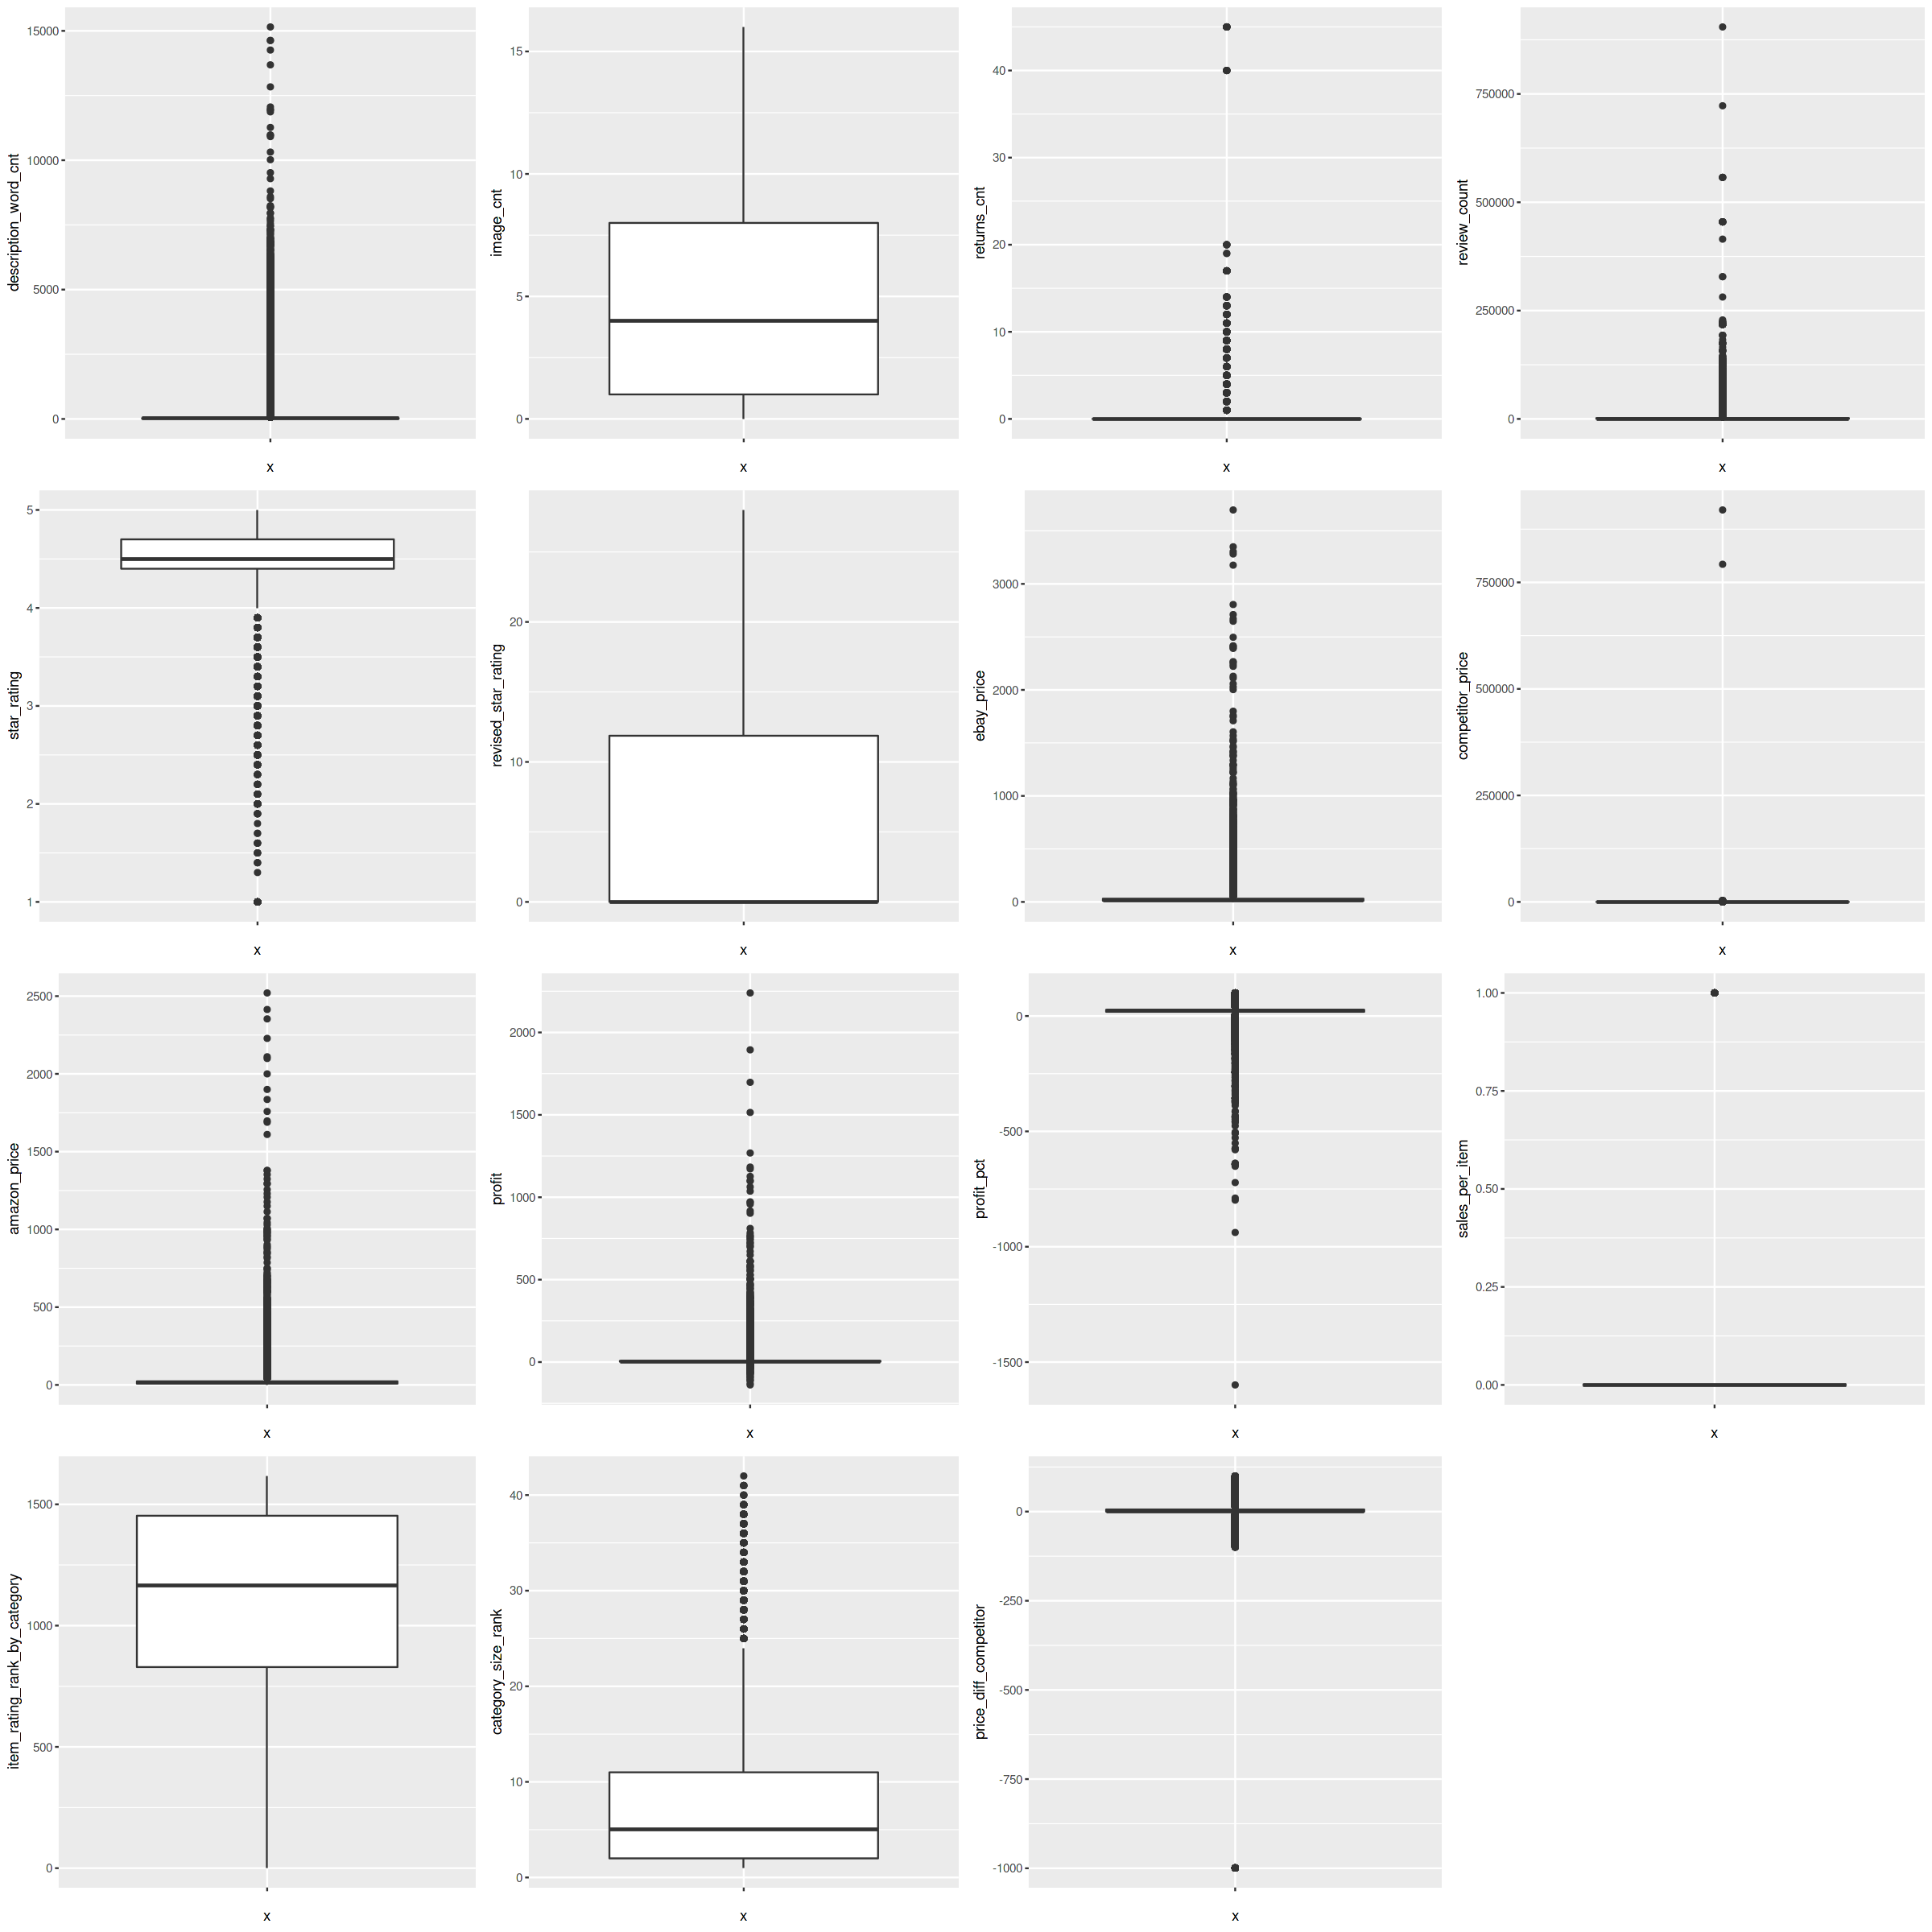

In [6]:
library(ggplot2)
options(repr.plot.width = 20, repr.plot.height = 20)
p <- vector(mode = "list", length = length(numlst))
i <- 1
for (n in numlst) {
        p[[i]]<- ggplot(data=Items) + geom_boxplot(aes(x="", y=.data[[n]]))
        i <- i+1
}
grid.arrange(grobs=p, ncol=4)

The following variables have ouliers:
description_word_cnt, returns count,review count,star rating,ebay price,amazon price,profit, profit percent,category size rank
Few outliers : competitor price, price diff competitor

In [7]:
outlierMatrix <- function(data,threshold=1.5) {
    vn <- names(data)
    outdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        if(is.numeric(data[[v]])) {
            outlow <- quantile(data[[v]],probs = 0.25,na.rm = T) 
            outhigh <- quantile(data[[v]],probs = 0.75, na.rm = T)
            irq_level <- (outhigh - outlow) * threshold
            outlow <- outlow - irq_level
            outhigh <- outhigh +  irq_level
            mv <- ifelse(data[[v]] < outlow | data[[v]] > outhigh, 1, 0)
            outdata[v] <- mv
        } else {
            mv <- rep(0,nrow(data))
        }
    }
    outdata$row1 <- NULL
    return(outdata)
}



In [8]:
df_out <- outlierMatrix(Items)
head(df_out)
#summary(df_out)

description_word_cnt image_cnt returns_cnt review_count star_rating
1 0                    0         0           NA           NA         
2 0                    0         0            0            0         
3 0                    0         0            0            0         
4 0                    0         0            0            0         
5 0                    0         0            0            0         
6 1                    0         0            0            0         
  revised_star_rating ebay_price competitor_price amazon_price profit
1 0                   0          0                0            0     
2 0                   0          0                0            0     
3 0                   0          0                0            0     
4 0                   0          0                0            0     
5 0                   0          0                0            0     
6 0                   0          0                0            0     
  profit_pct sales_per_item success item_rating_rank_by_category
1 1          0              0       0                           
2 1          1              1       0                           
3 0          1              1       0                           
4 0          1              1       0                           
5 0          1              1       0                           
6 0          0              0       0                           
  category_size_rank price_diff_competitor
1 0                  0                    
2 0                  0                    
3 0                  0                    
4 0                  0                    
5 0                  0                    
6 0                  0

**Check for Distribution change with/without outliers values**

In [9]:
numlst1 <-  numlst[numlst != 'sales_per_item']

res1 <- NULL
for (n in numlst) {
    out <- Items[[n]]
    non <- Items[[n]][which(df_out[[n]]==0)]
    outnum <- length(out) - length(non)
    pval <- suppressWarnings(ks.test(out,non)$p.value)
    if (TRUE) {
    res1 <- rbind(res1, cbind(var=n, outliers_cnt=outnum, distributation_chg=ifelse(pval<0.05,'+','-')))
        }
}
res1 

var                          outliers_cnt distributation_chg
 [1,] description_word_cnt         86913        +                 
 [2,] image_cnt                    0            -                 
 [3,] returns_cnt                  39232        +                 
 [4,] review_count                 306697       +                 
 [5,] star_rating                  290289       +                 
 [6,] revised_star_rating          0            -                 
 [7,] ebay_price                   48326        +                 
 [8,] competitor_price             47990        +                 
 [9,] amazon_price                 47899        +                 
[10,] profit                       51194        +                 
[11,] profit_pct                   34052        +                 
[12,] sales_per_item               100000       +                 
[13,] item_rating_rank_by_category 0            -                 
[14,] category_size_rank           15557        +                 
[15,] price_diff_competitor        57646        +

**Test difference in distribution with/without missing valus for all vars**

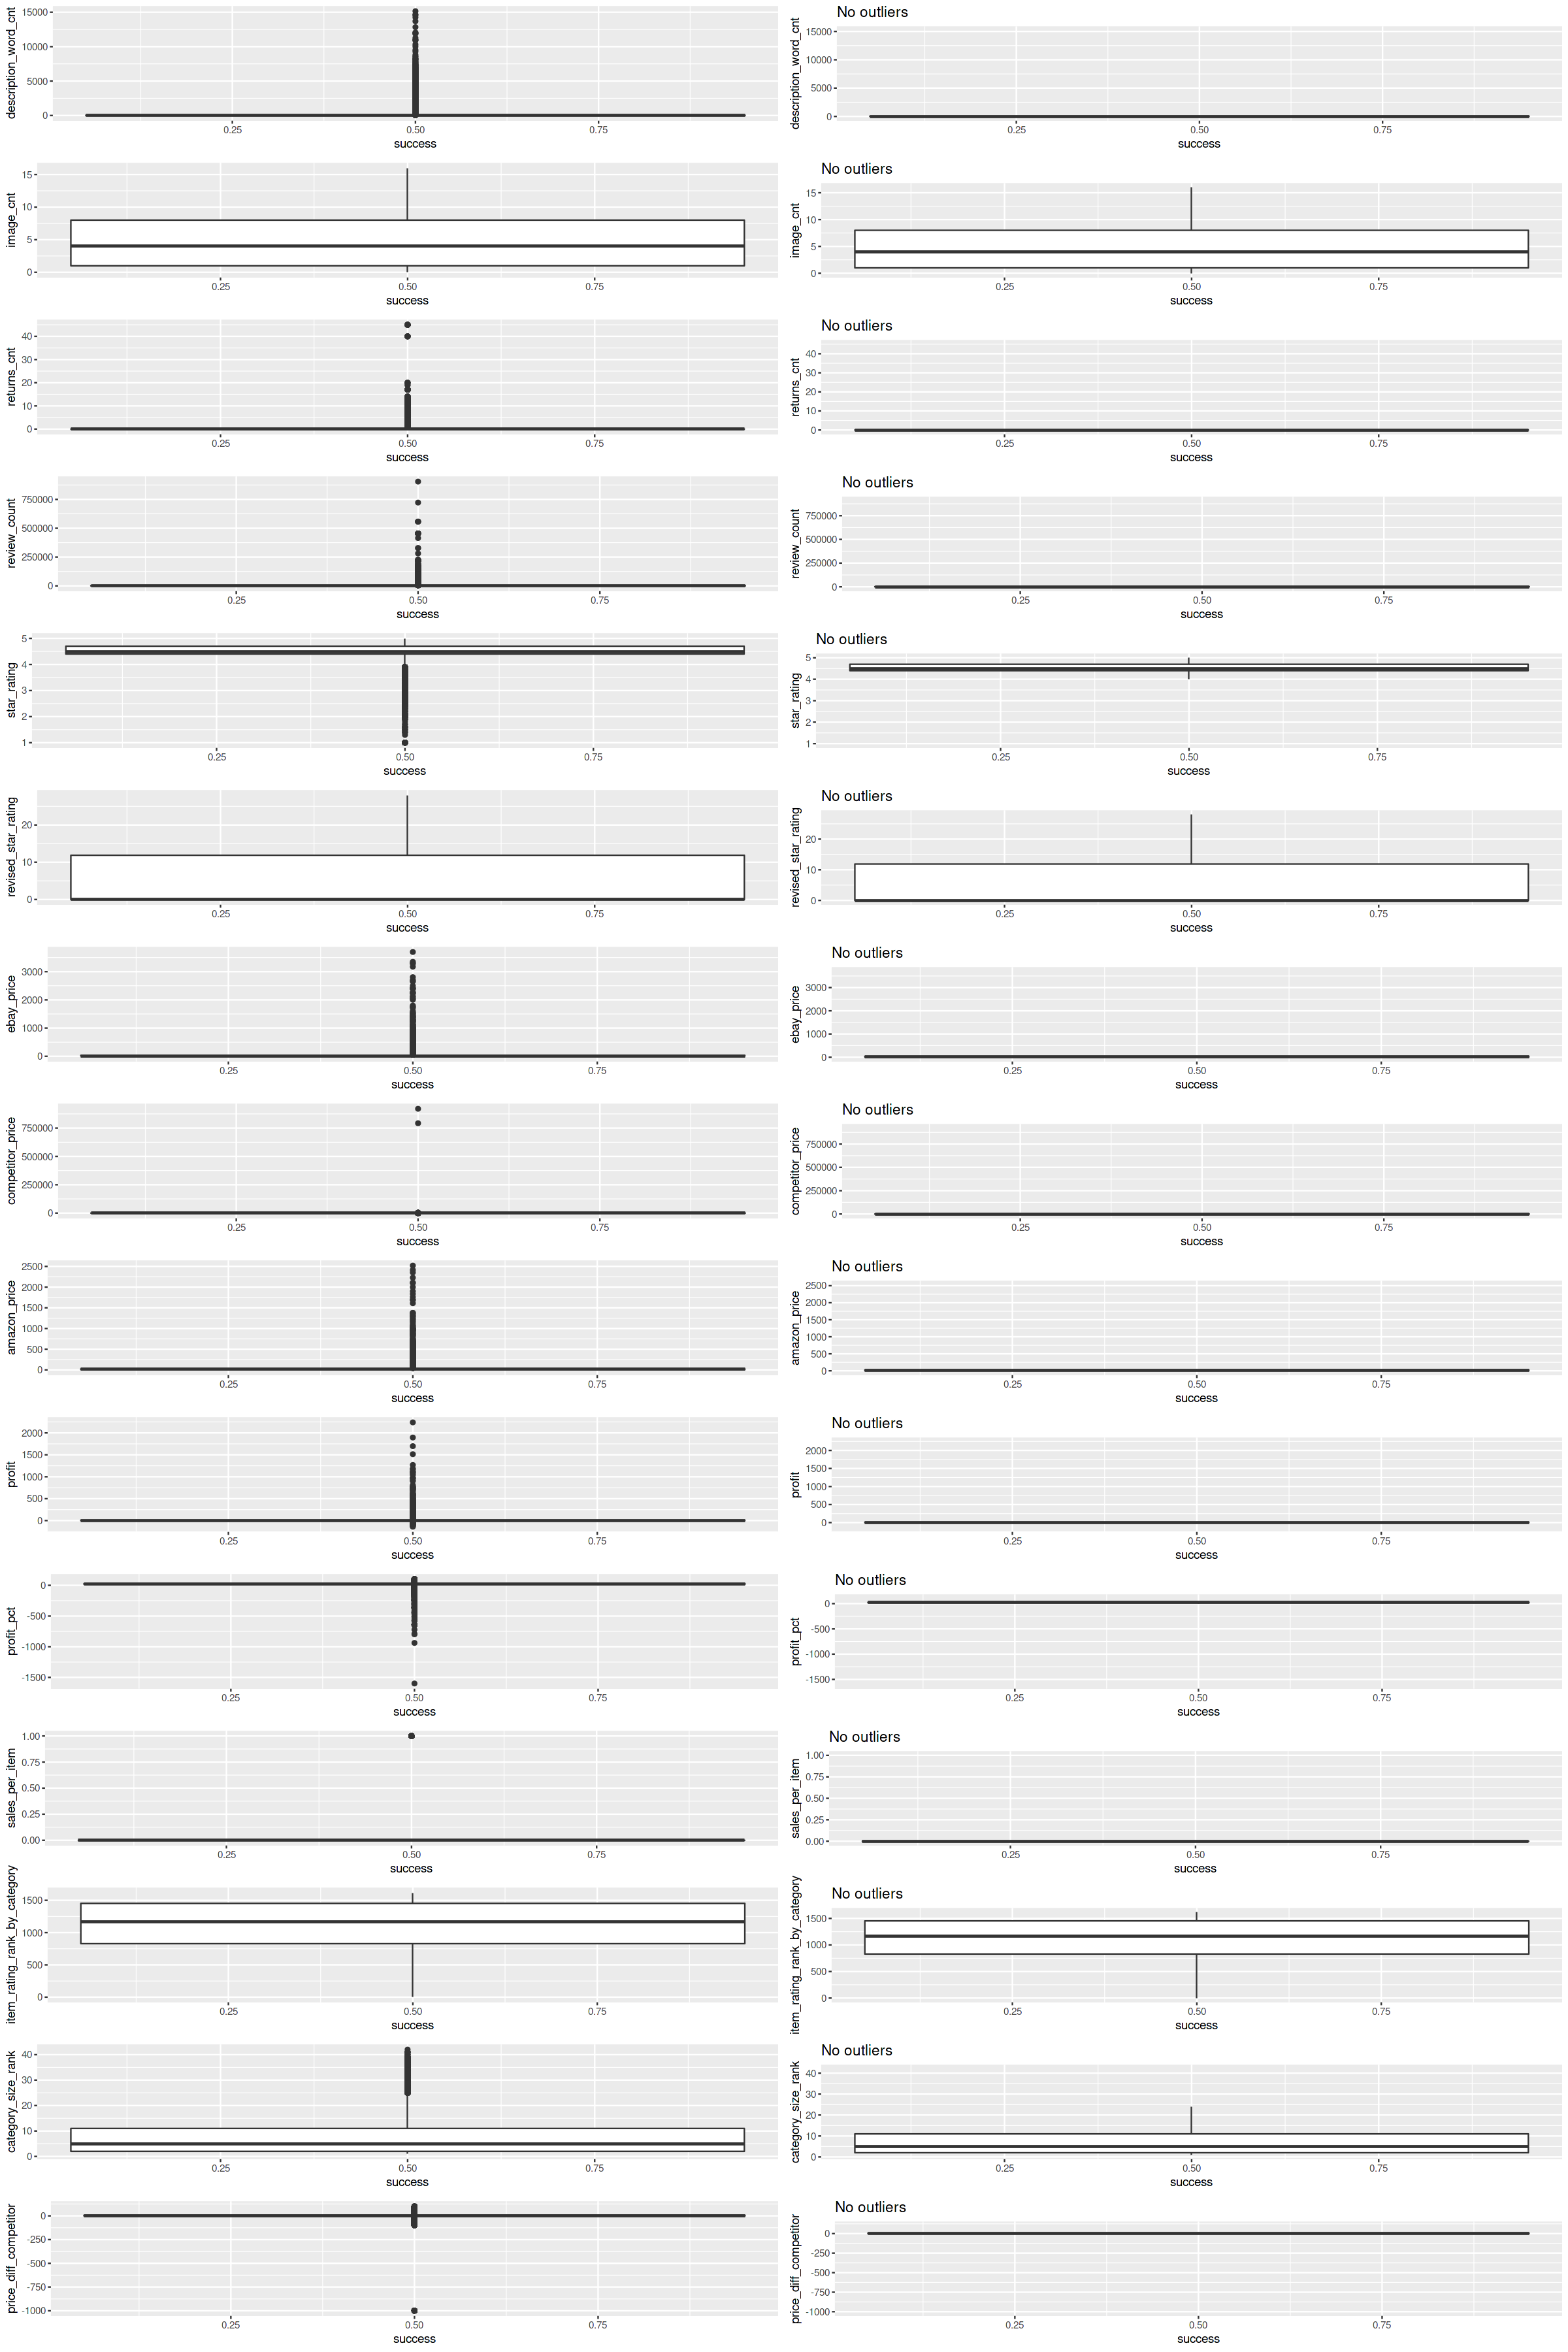

In [10]:
options(repr.plot.width = 20, repr.plot.height = 30)
p <- vector(mode = "list", length = length(numlst))
i <- 1
for (n in numlst) {
        p[[i]]<- ggplot(data=Items) + geom_boxplot(aes(x=success, y=.data[[n]]))
        p[[i+1]]<- ggplot(data=Items) + geom_boxplot(aes(x=success, y=.data[[n]]),outlier.shape = NA)+
             ggtitle("No outliers")
        i <- i+2
}
suppressWarnings(grid.arrange(grobs=p, ncol=2))

**Check for Correlation change with/without outliers values**

In [11]:
numlst1 <-  numlst[numlst != c('returns_cnt','sales_per_item')]
library(cocor)
res2 <- NULL

for (n in numlst1) {
    out <- Items[[n]]
    non <- Items[[n]][which(df_out[[n]]==0)]
    success_out <- as.numeric(Items$success)
    success_non <- success_out[which(df_out[[n]]==0)]
    outdf <- data.frame(x_out=out,y_out=success_out)
    nondf <- data.frame(x_non=non,y_non=success_non)
    outnum <- length(out) - length(non)
    
    if (TRUE) {
        cr <- suppressWarnings(cocor(~ x_out+y_out | x_non+y_non, data=list(outdf,nondf),na.action = na.exclude))
        pval <- cr@fisher1925$p.value
        res2 <- rbind(res2, cbind(var=n, correlation_changed=ifelse(pval<0.05,'+','-')))
        }
}
res2

Warning message in numlst != c("returns_cnt", "sales_per_item"):
“longer object length is not a multiple of shorter object length”


var                          correlation_changed
 [1,] description_word_cnt         +                  
 [2,] image_cnt                    -                  
 [3,] review_count                 +                  
 [4,] star_rating                  +                  
 [5,] revised_star_rating          -                  
 [6,] ebay_price                   +                  
 [7,] competitor_price             +                  
 [8,] amazon_price                 +                  
 [9,] profit                       +                  
[10,] profit_pct                   +                  
[11,] item_rating_rank_by_category -                  
[12,] category_size_rank           +                  
[13,] price_diff_competitor        +

In [12]:
library(tidyr)
res1 <- data.frame(res1)
res2 <- data.frame(res2)
res3 <- plyr::join(res1,res2,by='var',type= 'inner')
res3$drop <- ifelse(res3$distributation_chg == '+' & res3$correlation_changed == '+' , 'NO','YES')
res3

var                          outliers_cnt distributation_chg
1  description_word_cnt         86913        +                 
2  image_cnt                    0            -                 
3  review_count                 306697       +                 
4  star_rating                  290289       +                 
5  revised_star_rating          0            -                 
6  ebay_price                   48326        +                 
7  competitor_price             47990        +                 
8  amazon_price                 47899        +                 
9  profit                       51194        +                 
10 profit_pct                   34052        +                 
11 item_rating_rank_by_category 0            -                 
12 category_size_rank           15557        +                 
13 price_diff_competitor        57646        +                 
   correlation_changed drop
1  +                   NO  
2  -                   YES 
3  +                   NO  
4  +                   NO  
5  -                   YES 
6  +                   NO  
7  +                   NO  
8  +                   NO  
9  +                   NO  
10 +                   NO  
11 -                   YES 
12 +                   NO  
13 +                   NO

There are no variables in which we need to drop outliers, except return_cnt - I'll investigate it seperatly

**returns_cnt**

further analysis

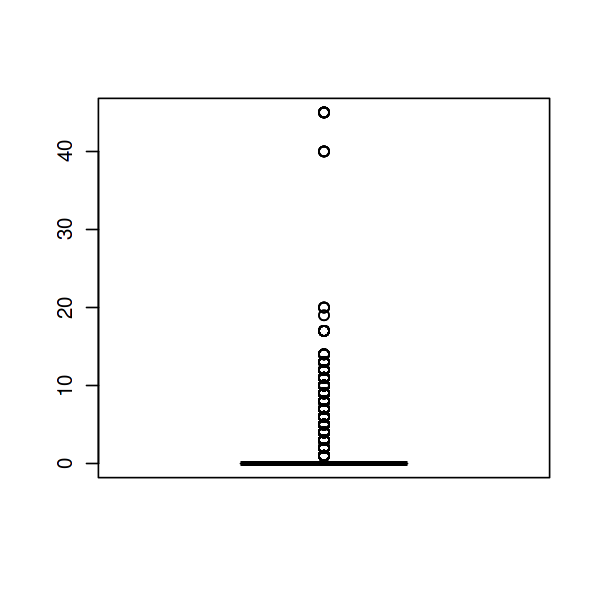

In [13]:
options(repr.plot.width = 5, repr.plot.height = 5)
boxplot(Items$returns_cnt)

We saw earlier that the distribution was changed between the variable with/without outliers

I will check now correlation change with the outcome.

In [14]:
table(Items$returns_cnt)
table(Items$success, df_out$returns_cnt)
cor.test(as.numeric(Items$success), df_out$returns_cnt, method = "spearman")


     0      1      2      3      4      5      6      7      8      9     10 
460768  27311   6739   2554   1220    516    281    120    171     73     47 
    11     12     13     14     17     19     20     40     45 
    45     44     40     15     30      2      5      7     12 

   
         0      1
  0 378333  21667
  1  82435  17565

Warning message in cor.test.default(as.numeric(Items$success), df_out$returns_cnt, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  as.numeric(Items$success) and df_out$returns_cnt
S = 1.7069e+16, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.1807101 


In [17]:
# test correlation with outliers
cor.test(as.numeric(Items$success), Items$returns_cnt, method = "spearman")

# withoout outliers
var1 <- Items$returns_cnt[which(df_out$returns_cnt==0)]
var2 <- Items$success[which(df_out$returns_cnt==0)]

cor.test(as.numeric(var2), var1, method = "spearman")

Warning message in cor.test.default(as.numeric(Items$success), Items$returns_cnt, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  as.numeric(Items$success) and Items$returns_cnt
S = 1.7041e+16, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.182013 


Warning message in cor(rank(x), rank(y)):
“the standard deviation is zero”



	Spearman's rank correlation rho

data:  as.numeric(var2) and var1
S = NA, p-value = NA
alternative hypothesis: true rho is not equal to 0
sample estimates:
rho 
 NA 


returns_cnt are **all 0** when removing the outliers - cannot test correlation "the standard deviation is zero"

Since it changes the distribution I'll go ahead and drop it

**revised star rating**

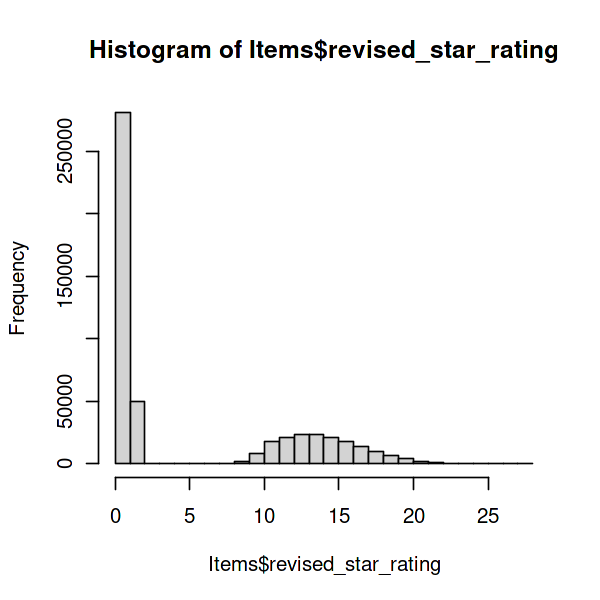

In [18]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(Items$revised_star_rating)

All 0 values come from 0 count reviews
all 2 values are with low number of reviews
I'll put NA instead of 0 since it is more appropriate

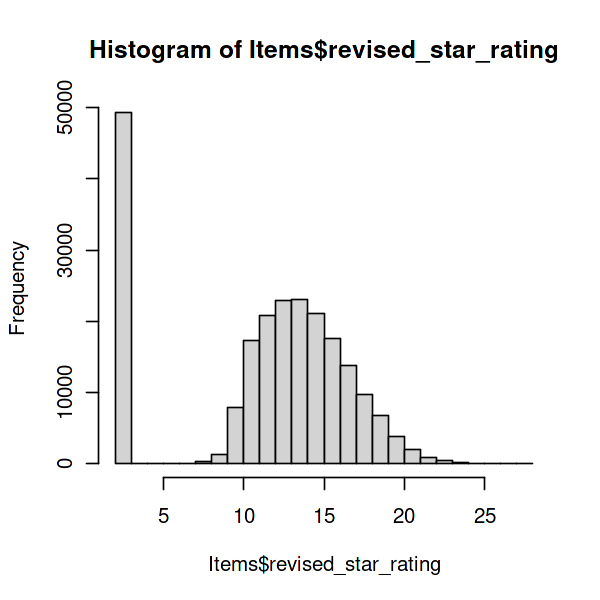

In [19]:
Items$revised_star_rating <- ifelse(Items$revised_star_rating==0,NA,Items$revised_star_rating)
hist(Items$revised_star_rating)

# Outliers treatment

In [20]:
remove_outliers <- function(x, na.rm = TRUE, ...) {
  qnt <- quantile(x, probs=c(.25, .75), na.rm = na.rm, ...)
  H <- 1.5 * IQR(x, na.rm = na.rm)
  y <- x
  y[x < (qnt[1] - H)] <- NA
  y[x > (qnt[2] + H)] <- NA
  y
}

**returns_cnt**

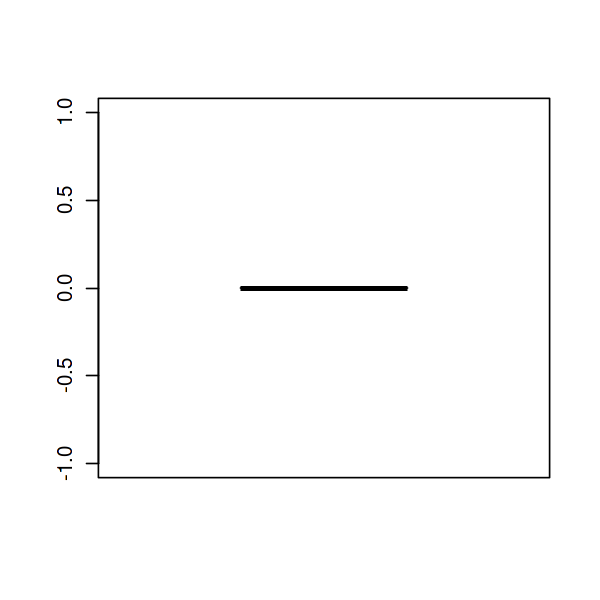

In [21]:
# Remove outliers from returns_cnt
Items$returns_cnt <- remove_outliers(Items$returns_cnt)
options(repr.plot.width = 5, repr.plot.height = 5)
boxplot(Items$returns_cnt)

**description word count**

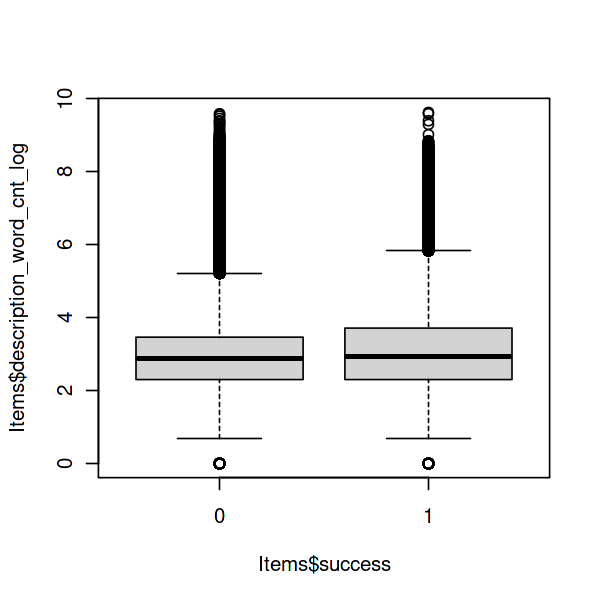

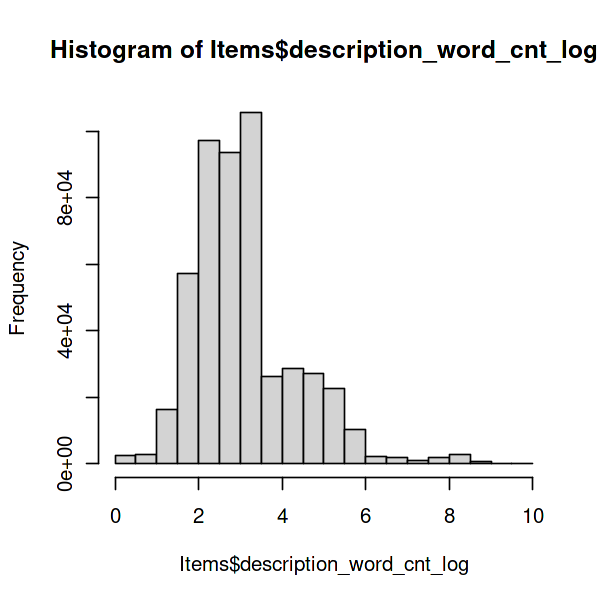

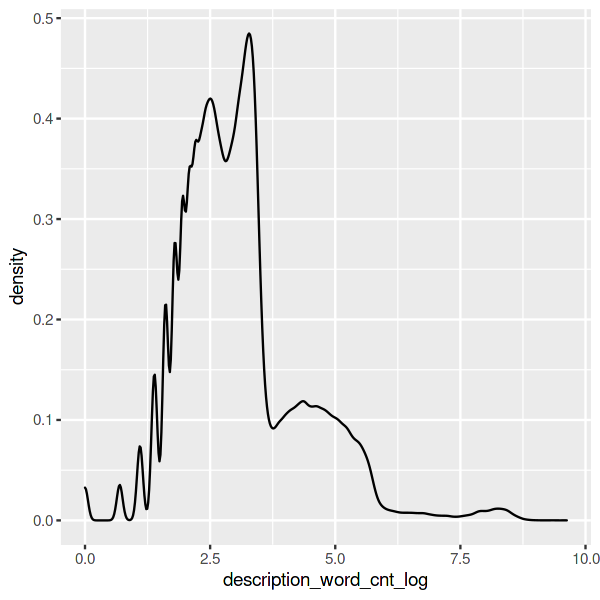

In [22]:
## will go for transformation
Items$description_word_cnt_log <- log(Items$description_word_cnt)
boxplot(Items$description_word_cnt_log ~ Items$success)
hist(Items$description_word_cnt_log)

ggplot(data=Items) +
   geom_density(aes(description_word_cnt_log))

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



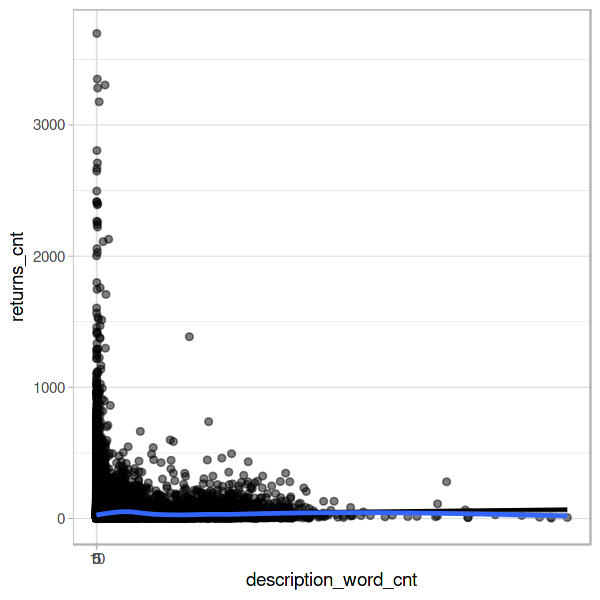

In [23]:
ggplot(data=Items, 
       aes(x = description_word_cnt, 
           y = ebay_price)) + 
           geom_point(alpha =0.5)+ 
           #facet_wrap(~party) +
  ylab("returns_cnt") +
  xlab("description_word_cnt") +
  scale_x_continuous(breaks = c(0, 5, 10)) + #, limits = c(0,10)) +
  geom_smooth(method=lm,  color = "black", fill="lightgray") +
  geom_smooth(span =  0.3) +
  theme_light()

**review count**

will go for categorization

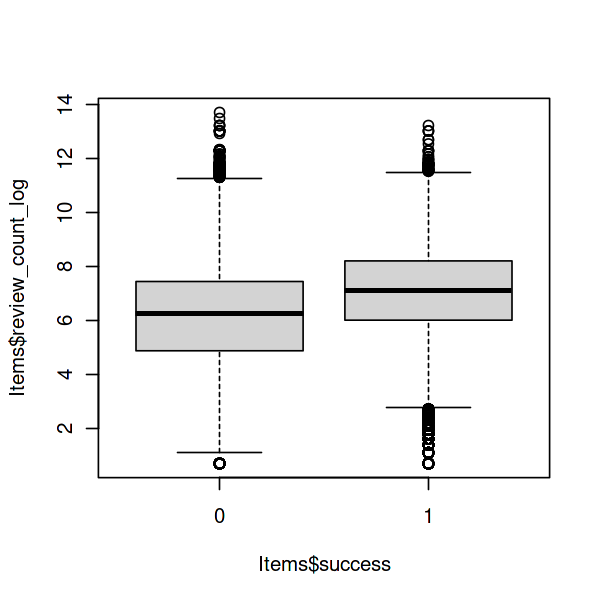

Warning message:
“Removed 280996 rows containing non-finite values (stat_density).”


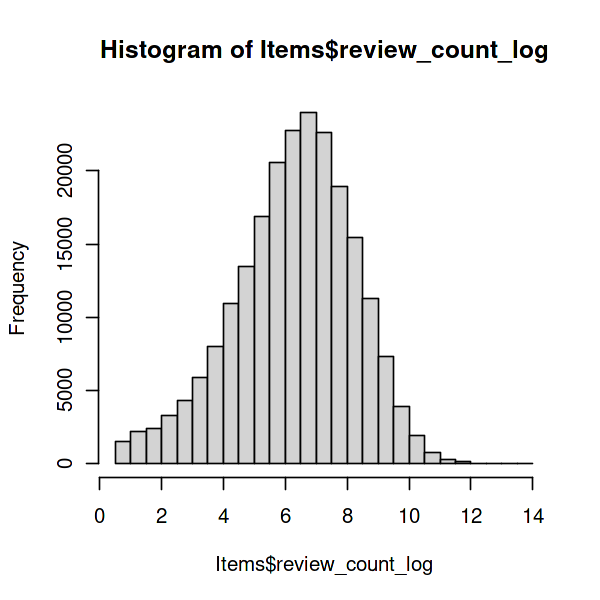

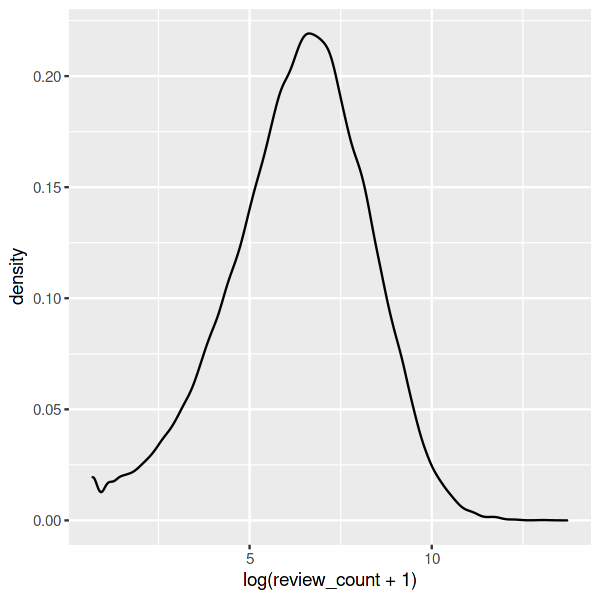

In [24]:
Items$review_count_log <- log(Items$review_count+1)
boxplot(Items$review_count_log ~ Items$success)
hist(Items$review_count_log)

ggplot(data=Items) +
   geom_density(aes(log(review_count+1)))

In [25]:
summary(Items$review_count_log)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.69    5.09    6.44    6.28    7.63   13.72  280996 

In [26]:
Items$review_count_log <- case_when(
  Items$review_count_log < 5.09 ~ "Q1",
  Items$review_count_log >= 5.09 & Items$review_count_log < 6.44 ~ "Q2",
  Items$review_count_log >= 6.44 & Items$review_count_log < 7.63 ~ "Q3",
  Items$review_count_log >= 7.63 ~ "Q4")
  #is.na(Items$review_count_log) ~ "NA")
Items$review_count_log <- as.factor(Items$review_count_log)
summary(Items$review_count_log)

Q1     Q2     Q3     Q4   NA's 
 54837  54694  54630  54843 280996

**star rating**

will go for categorization

In [27]:
summary(Items$star_rating)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1.00    4.40    4.50    4.49    4.70    5.00  280744 

In [28]:
## will go for transformation
Items$star_rating <- case_when(
  Items$star_rating < 4.4 ~ "Q1",
  Items$star_rating >= 4.4 & Items$star_rating < 4.5 ~ "Q2",
  Items$star_rating >= 4.5 & Items$star_rating < 4.7 ~ "Q3",
  Items$star_rating >= 4.7 ~ "Q4")
  #is.na(Items$star_rating) ~ "NA")
Items$star_rating <- as.factor(Items$star_rating)
summary(Items$star_rating)

Q1     Q2     Q3     Q4   NA's 
 52531  25334  75024  66367 280744

**prices** :
ebay,amazon,competitor are all distributed in a similiar way

will go for log transformation

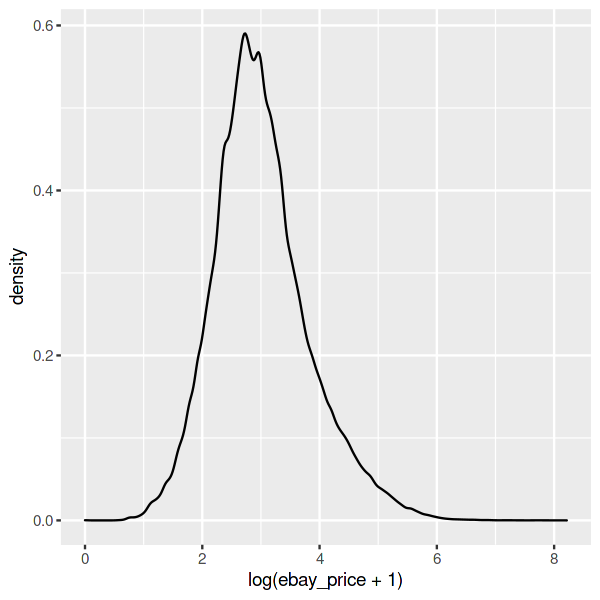

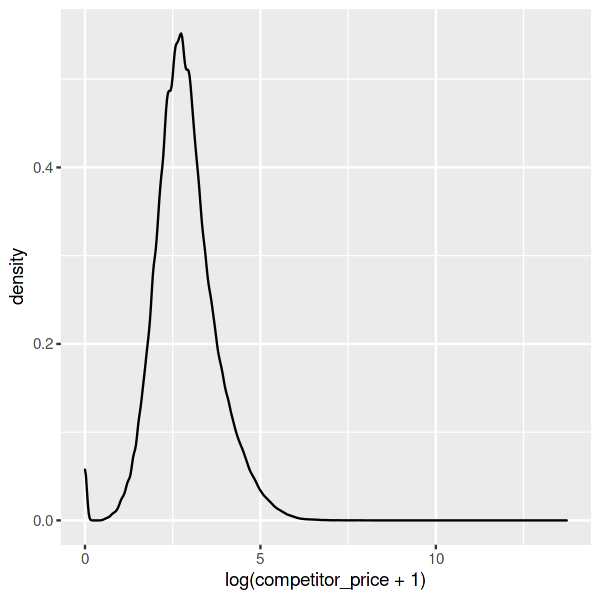

Warning message:
“Removed 177 rows containing non-finite values (stat_density).”


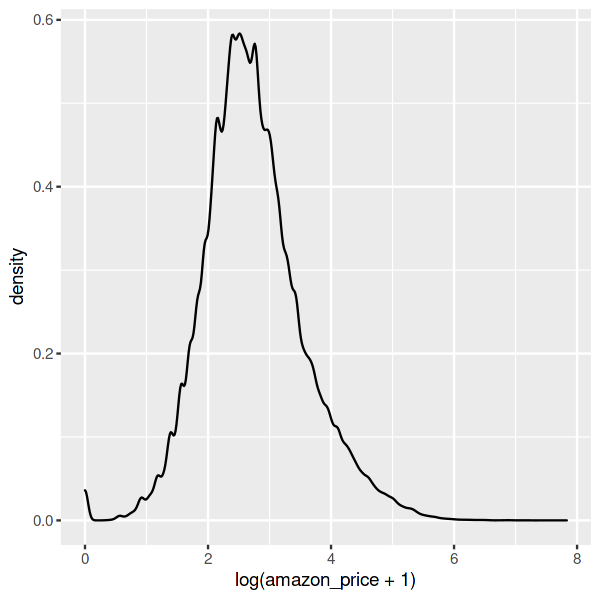

Warning message in sqrt(profit_pct):
“NaNs produced”
Warning message in sqrt(profit_pct):
“NaNs produced”
Warning message:
“Removed 6623 rows containing non-finite values (stat_density).”


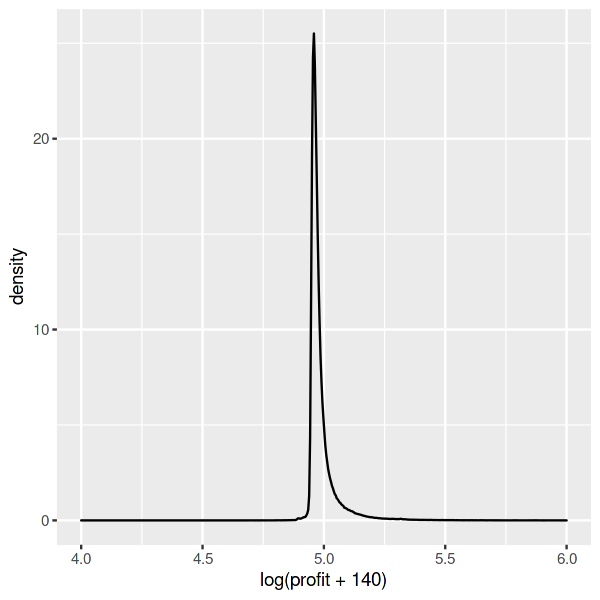

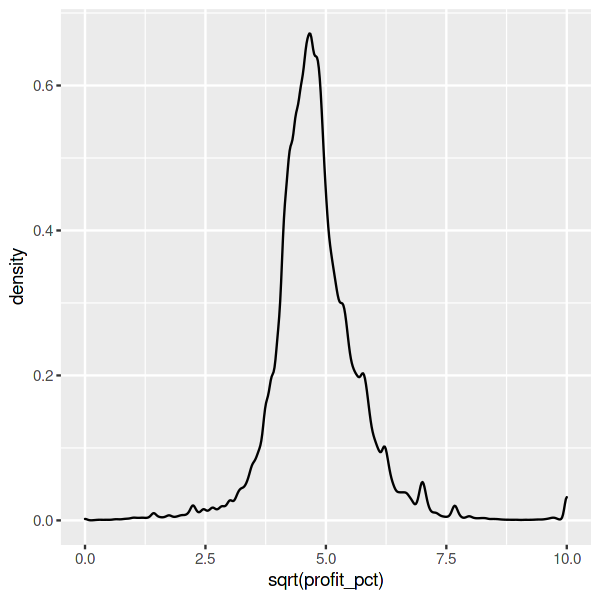

In [29]:
options(repr.plot.width = 5, repr.plot.height = 5)
par(mar=c(1,1,1,1),mfrow=c(1,2))
ggplot(data=Items) +
   geom_density(aes(log(ebay_price+1)))
ggplot(data=Items) +
   geom_density(aes(log(competitor_price+1)))
ggplot(data=Items) +
   geom_density(aes(log(amazon_price+1)))
ggplot(data=Items) +
   geom_density(aes(log(profit+140))) + xlim(4,6) # offset to avoid negative values
ggplot(data=Items) +
   geom_density(aes(sqrt(profit_pct)))

In [30]:
Items$ebay_price_log <- log(Items$ebay_price+1)
Items$amazon_price_log <- log(Items$amazon_price+1)
Items$competitor_price_log <- log(Items$competitor_price+1)
Items$profit_log <- log(Items$profit+140) # offset to avoid negative values
Items$profit_pct_sqrt <- sqrt(Items$profit_pct)

Warning message in sqrt(Items$profit_pct):
“NaNs produced”


**price_diff_competitor**

will go for transformation

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-999.000    0.000    1.280   -8.934    5.900   99.910 

n() 
1 6270

Warning message:
“Removed 11601 rows containing non-finite values (stat_density).”


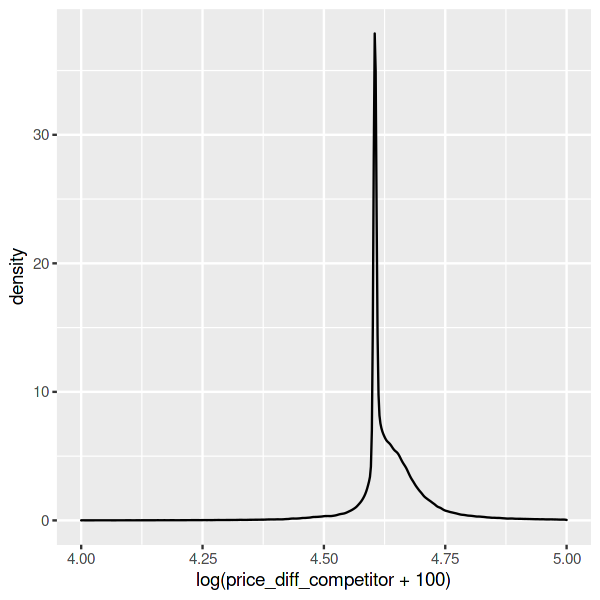

In [31]:
summary(Items$price_diff_competitor)
# change value -999 to NA since that was the original meaning in the source data
filter(Items,price_diff_competitor== -999) %>% summarize(n()) # count how many values are -999, i.e. NA
Items$price_diff_competitor <- ifelse(Items$price_diff_competitor==-999,NA,Items$price_diff_competitor)
ggplot(data=Items) +
   geom_density(aes(log(price_diff_competitor+100))) + xlim(4,5) # add constant 100 (>min(price_diff_competitor)) to avoid negative data

**Prices**

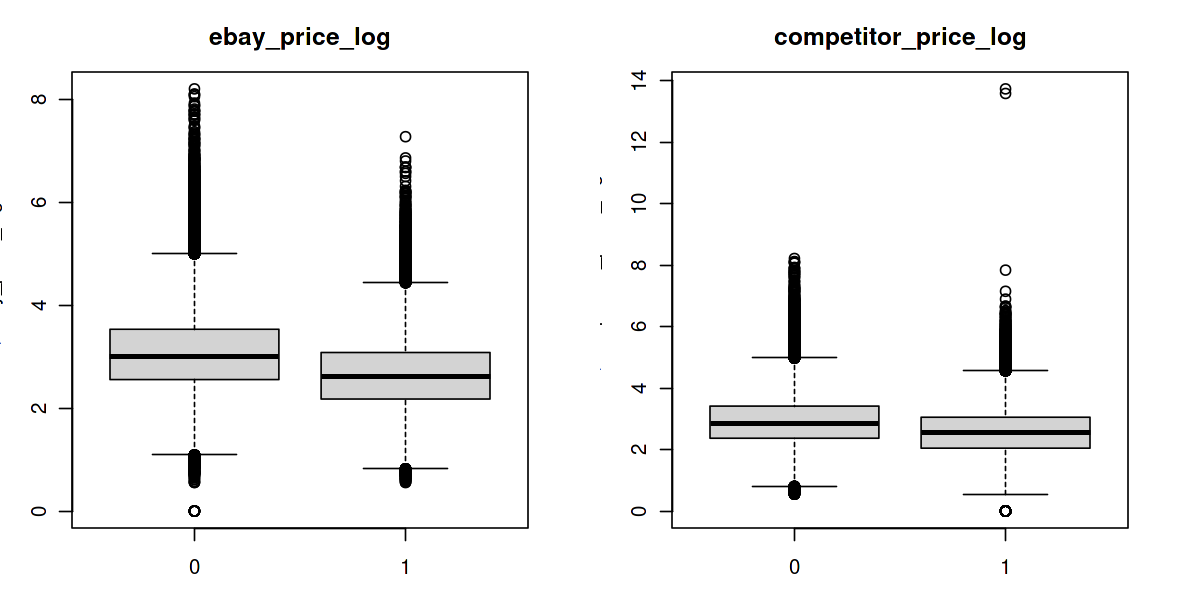

Warning message in sqrt(Items$profit_pct):
“NaNs produced”


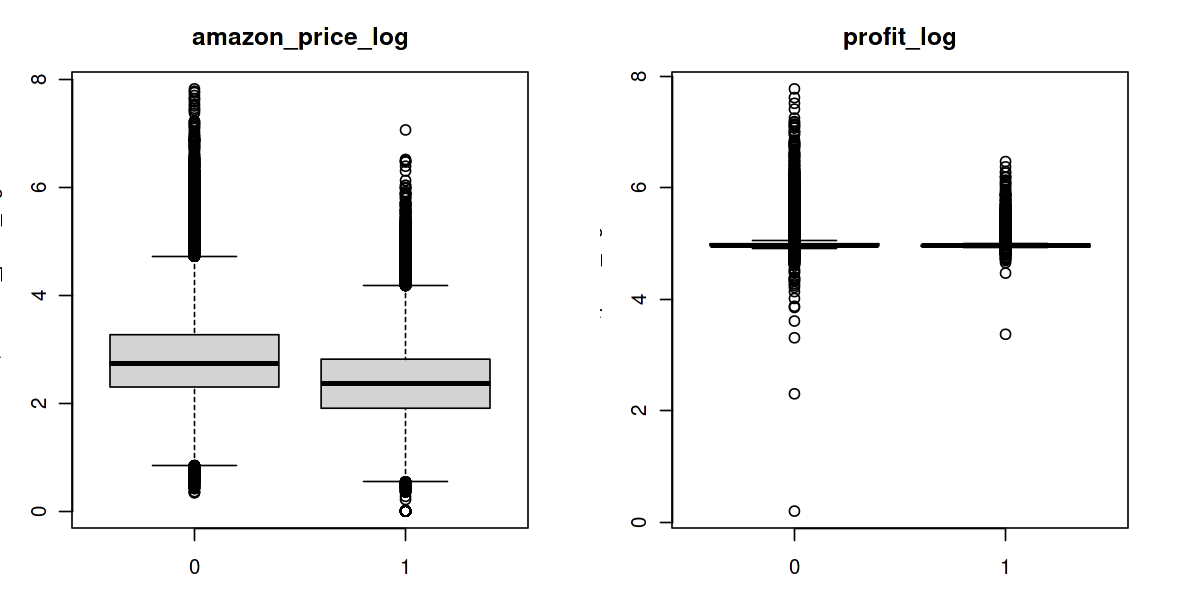

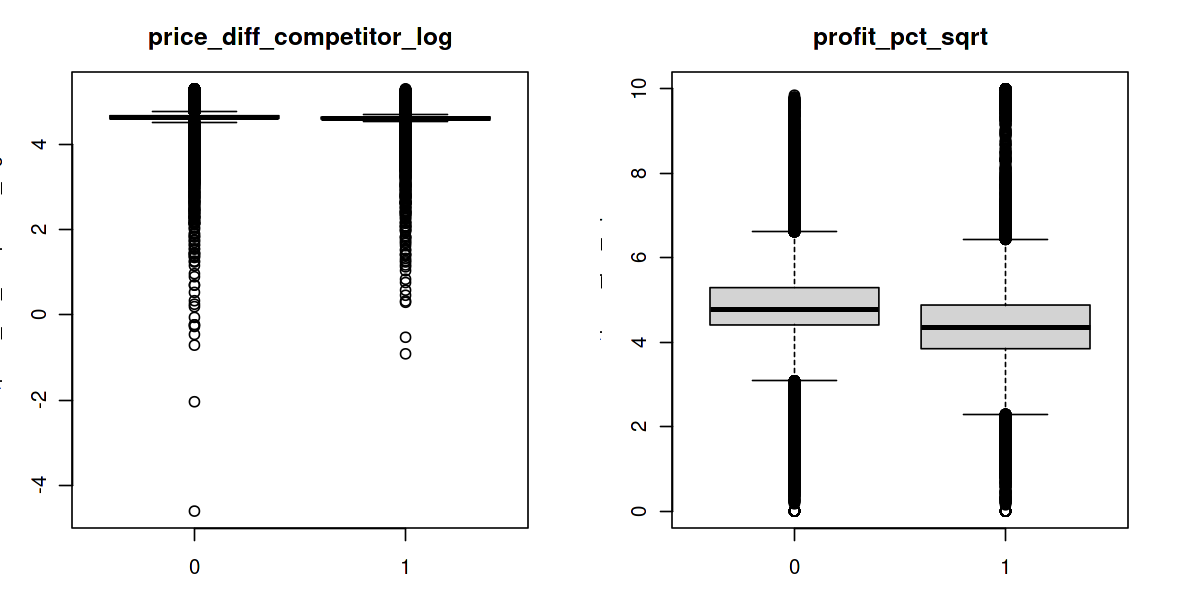

In [32]:
options(repr.plot.width = 10, repr.plot.height = 5)
par(mar=c(3,3,3,3),mfrow=c(1,2))
Items$ebay_price_log <- log(Items$ebay_price+1)
boxplot(Items$ebay_price_log ~ Items$success,main="ebay_price_log")
Items$competitor_price_log <- log(Items$competitor_price+1)
boxplot(Items$competitor_price_log ~ Items$success,main="competitor_price_log")
Items$amazon_price_log <- log(Items$amazon_price+1)
boxplot(Items$amazon_price_log ~ Items$success,main="amazon_price_log")
Items$profit_log <- log(Items$profit+140)
boxplot(Items$profit_log ~ Items$success,main="profit_log")
Items$price_diff_competitor_log <- log(Items$price_diff_competitor+100)
boxplot(Items$price_diff_competitor_log ~ Items$success,main="price_diff_competitor_log")
Items$profit_pct_sqrt <- sqrt(Items$profit_pct)
boxplot(Items$profit_pct_sqrt ~ Items$success,main="profit_pct_sqrt")

**category_size_rank**

will go for transformation

In [33]:
summary(Items$category_size_rank)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   5.000   7.289  11.000  42.000 

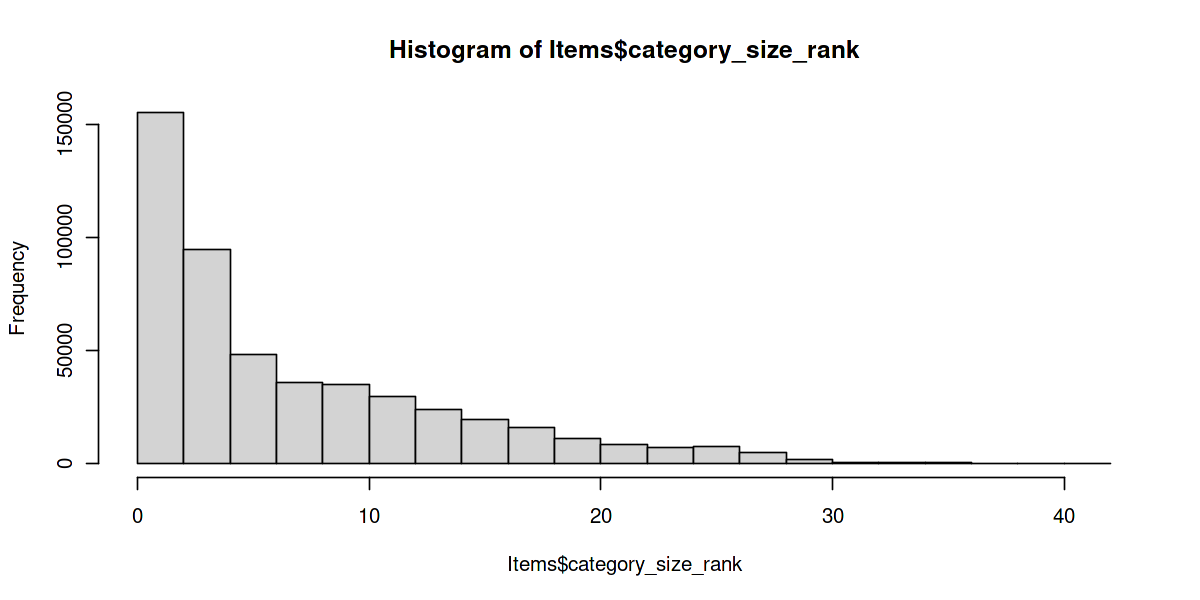

[1] 117296

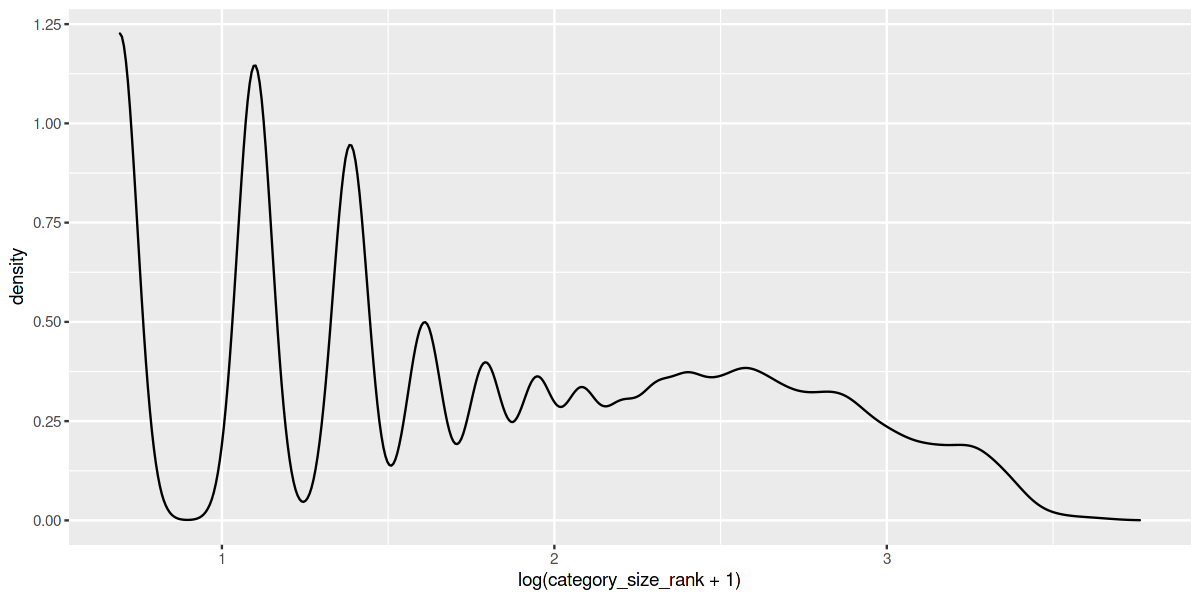

In [34]:
hist(Items$category_size_rank)
ggplot(data=Items) +
   geom_density(aes(log(category_size_rank+1)))

length(Items$category_size_rank[Items$category_size_rank > 11])

unable to transform properly
I'll use quantile categories

In [35]:
Items$category_size_rank_q <- gtools::quantcut(Items$category_size_rank,q=10)
Items$category_size_rank_q <- as.factor(Items$category_size_rank_q)
str(Items$category_size_rank_q)
levels(Items$category_size_rank_q) <- c(1,2,3,4,5,6,7,8,9)
summary(Items$category_size_rank_q)

 Factor w/ 9 levels "1","2","(2,3]",..: 4 1 1 1 1 9 1 2 1 6 ...


1     2     3     4     5     6     7     8     9 
80247 74911 61842 58253 42449 33249 60360 39568 49121

In [36]:
#drop old variables
drop <- c("description_word_cnt","review_count","ebay_price","competitor_price","amazon_price","profit","profit_pct","price_diff_competitor","category_size_rank")
Items = Items[,!(names(Items) %in% drop)]
names(Items)

[1] "asin"                         "creation_time"               
 [3] "season"                       "location"                    
 [5] "condition"                    "description"                 
 [7] "brand"                        "category"                    
 [9] "image_cnt"                    "returns_cnt"                 
[11] "star_rating"                  "revised_star_rating"         
[13] "sales_cyber_monday"           "sales_black_friday"          
[15] "sales_colombus_day"           "sales_labor_day"             
[17] "sales_presidents_day"         "sales_4th_july"              
[19] "sales_newyear"                "sales_xms"                   
[21] "sales_per_item"               "success"                     
[23] "item_rating_rank_by_category" "brand_size"                  
[25] "reviews_cnt_category"         "popular_brand"               
[27] "description_word_cnt_log"     "review_count_log"            
[29] "ebay_price_log"               "amazon_price_log"            
[31] "competitor_price_log"         "profit_log"                  
[33] "profit_pct_sqrt"              "price_diff_competitor_log"   
[35] "category_size_rank_q"

# Missing values

In [37]:
missingMatrix <- function(data) {
    vn <- names(data)
    missdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        mv <- ifelse(is.na(data[[v]]),1,0)
        missdata[v] <- mv
    }
    missdata$row1 <- NULL
    return(missdata)
}

getMissingness <- function (data, getRows = FALSE) {
    require(dplyr)
    l <- nrow(data)
    vn <- names(data)
    nadf <- data
    cnt <- NULL
    miss <- function(x) return(sum(is.na(x)))
    for (n in vn) {
        nadf[[n]] <- ifelse(is.na(nadf[[n]]) == T, 1, 0)
        cnt <- rbind(cnt, data.frame(n, sum(nadf[[n]])))
    }
    names(cnt) <- c("var", "na.count")
    cnt$rate <- round((cnt$na.count/nrow(nadf)) * 100, 1)
    nadf$na.cnt <- 0
    nadf$na.cnt <- rowSums(nadf)
    cnt <- cnt %>% dplyr::arrange(desc(na.count)) %>% dplyr::filter(na.count > 
        0)
    totmiss <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::tally()
    idx <- NULL
    msg <- (paste("This dataset has ", as.character(totmiss), 
        " (", as.character(round(totmiss/nrow(data) * 100, 1)), 
        "%)", " complete rows. Original data has ", nrow(data), 
        " rows.", sep = ""))
    if (getRows == TRUE & totmiss != 0) {
        nadf$rn <- seq_len(nrow(data))
        idx <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::select(rn)
    }
    print(list(head(cnt, n = 10), msg))
    return(list(missingness = cnt, message = msg, rows = idx$rn))
}

In [38]:
numlst1 <- NULL
for (v in names(Items)) {
            if(is.numeric(Items[[v]])) {numlst1 <- c(numlst1, v)}
}

numlst1

[1] "image_cnt"                    "returns_cnt"                 
 [3] "revised_star_rating"          "sales_per_item"              
 [5] "success"                      "item_rating_rank_by_category"
 [7] "description_word_cnt_log"     "ebay_price_log"              
 [9] "amazon_price_log"             "competitor_price_log"        
[11] "profit_log"                   "profit_pct_sqrt"             
[13] "price_diff_competitor_log"

In [39]:
mm <- getMissingness(data = Items)

[[1]]
                        var na.count rate
1       revised_star_rating   280996 56.2
2          review_count_log   280996 56.2
3               star_rating   280744 56.1
4               returns_cnt    39232  7.8
5                brand_size    16426  3.3
6           profit_pct_sqrt     6623  1.3
7 price_diff_competitor_log     6270  1.3
8                     brand        1  0.0

[[2]]
[1] "This dataset has 185293 (37.1%) complete rows. Original data has 500000 rows."



In [40]:
summary(Items$revised_star_rating)
summary(Items$review_count_log)
summary(Items$star_rating)
summary(Items$returns_cnt)
summary(Items$brand_size)
summary(Items$profit_pct_sqrt)
summary(Items$price_diff_competitor_log)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   2.00    9.66   12.56   11.21   15.03   28.00  280996 

Q1     Q2     Q3     Q4   NA's 
 54837  54694  54630  54843 280996

Q1     Q2     Q3     Q4   NA's 
 52531  25334  75024  66367 280744

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0       0       0       0       0       0   39232 

Large    med  Small   NA's 
 46020  38123 399431  16426

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   4.307   4.714   4.800   5.218  10.000    6623 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -4.605   4.605   4.619   4.635   4.663   5.298    6270 

In [41]:
mm$missingness
mm$missingness$var

var                       na.count rate
1 revised_star_rating       280996   56.2
2 review_count_log          280996   56.2
3 star_rating               280744   56.1
4 returns_cnt                39232    7.8
5 brand_size                 16426    3.3
6 profit_pct_sqrt             6623    1.3
7 price_diff_competitor_log   6270    1.3
8 brand                          1    0.0

[1] "revised_star_rating"       "review_count_log"         
[3] "star_rating"               "returns_cnt"              
[5] "brand_size"                "profit_pct_sqrt"          
[7] "price_diff_competitor_log" "brand"

In [42]:
#generate a missing matrix
Items_na <- missingMatrix(Items)

Registered S3 method overwritten by 'gplots':
  method         from     
  reorder.factor DescTools


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


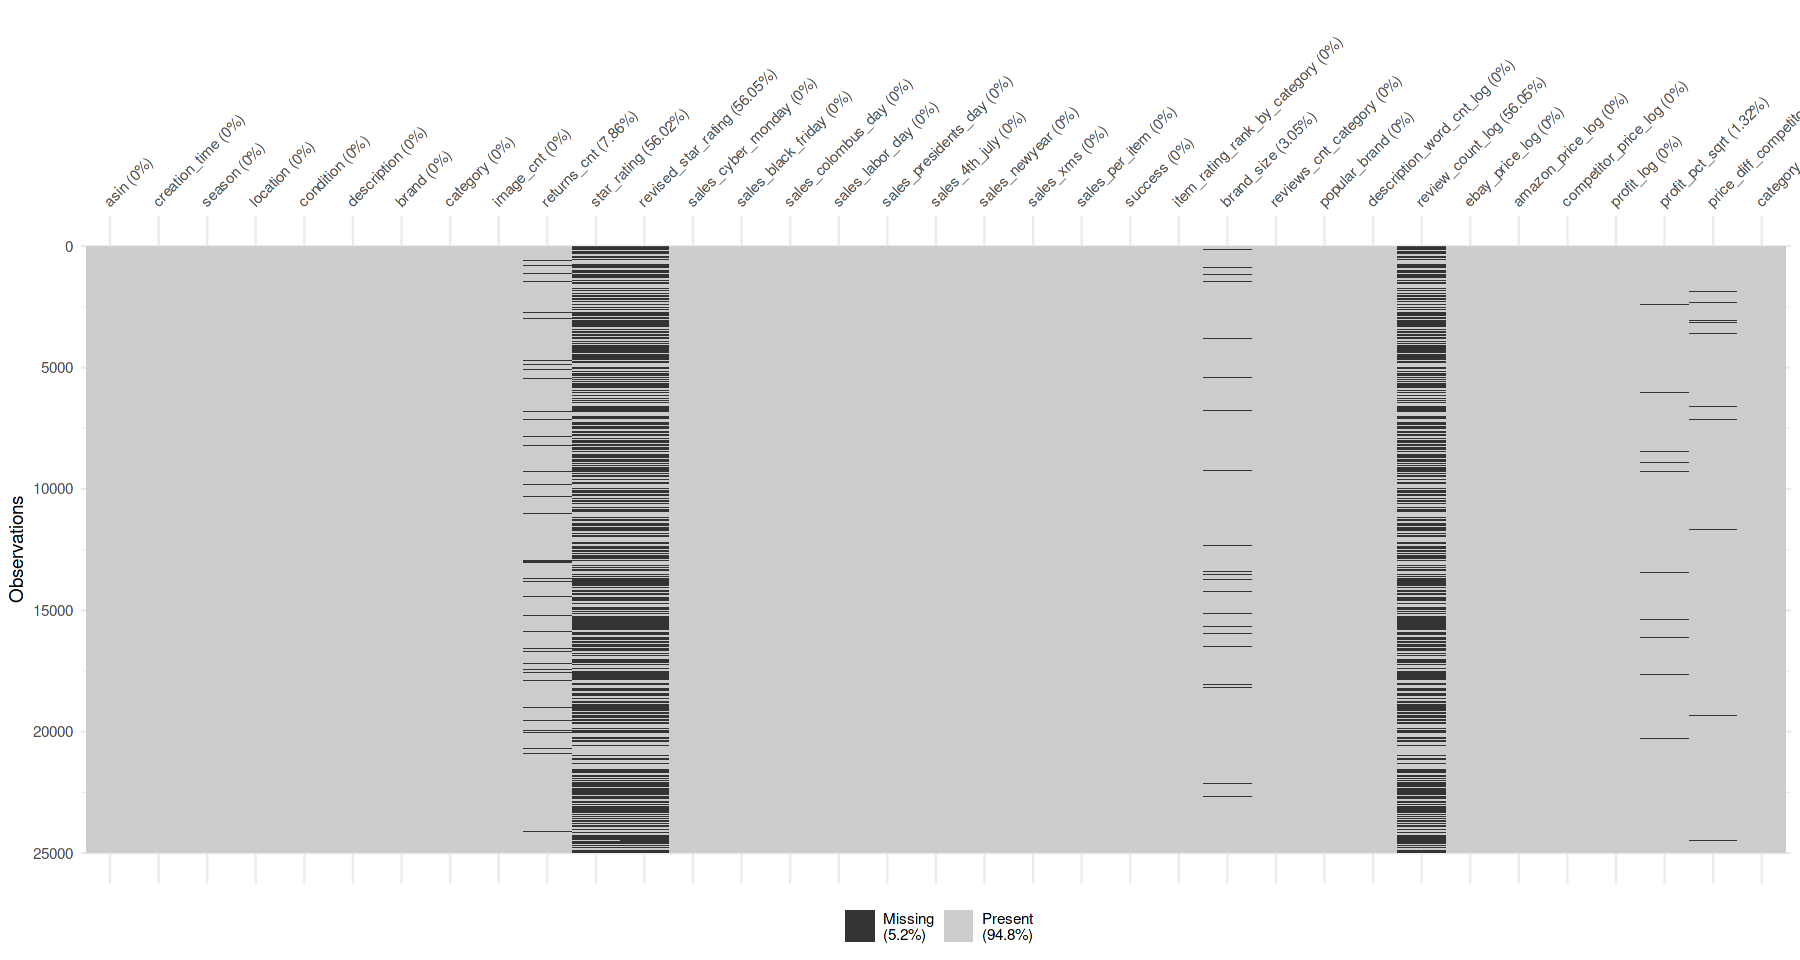

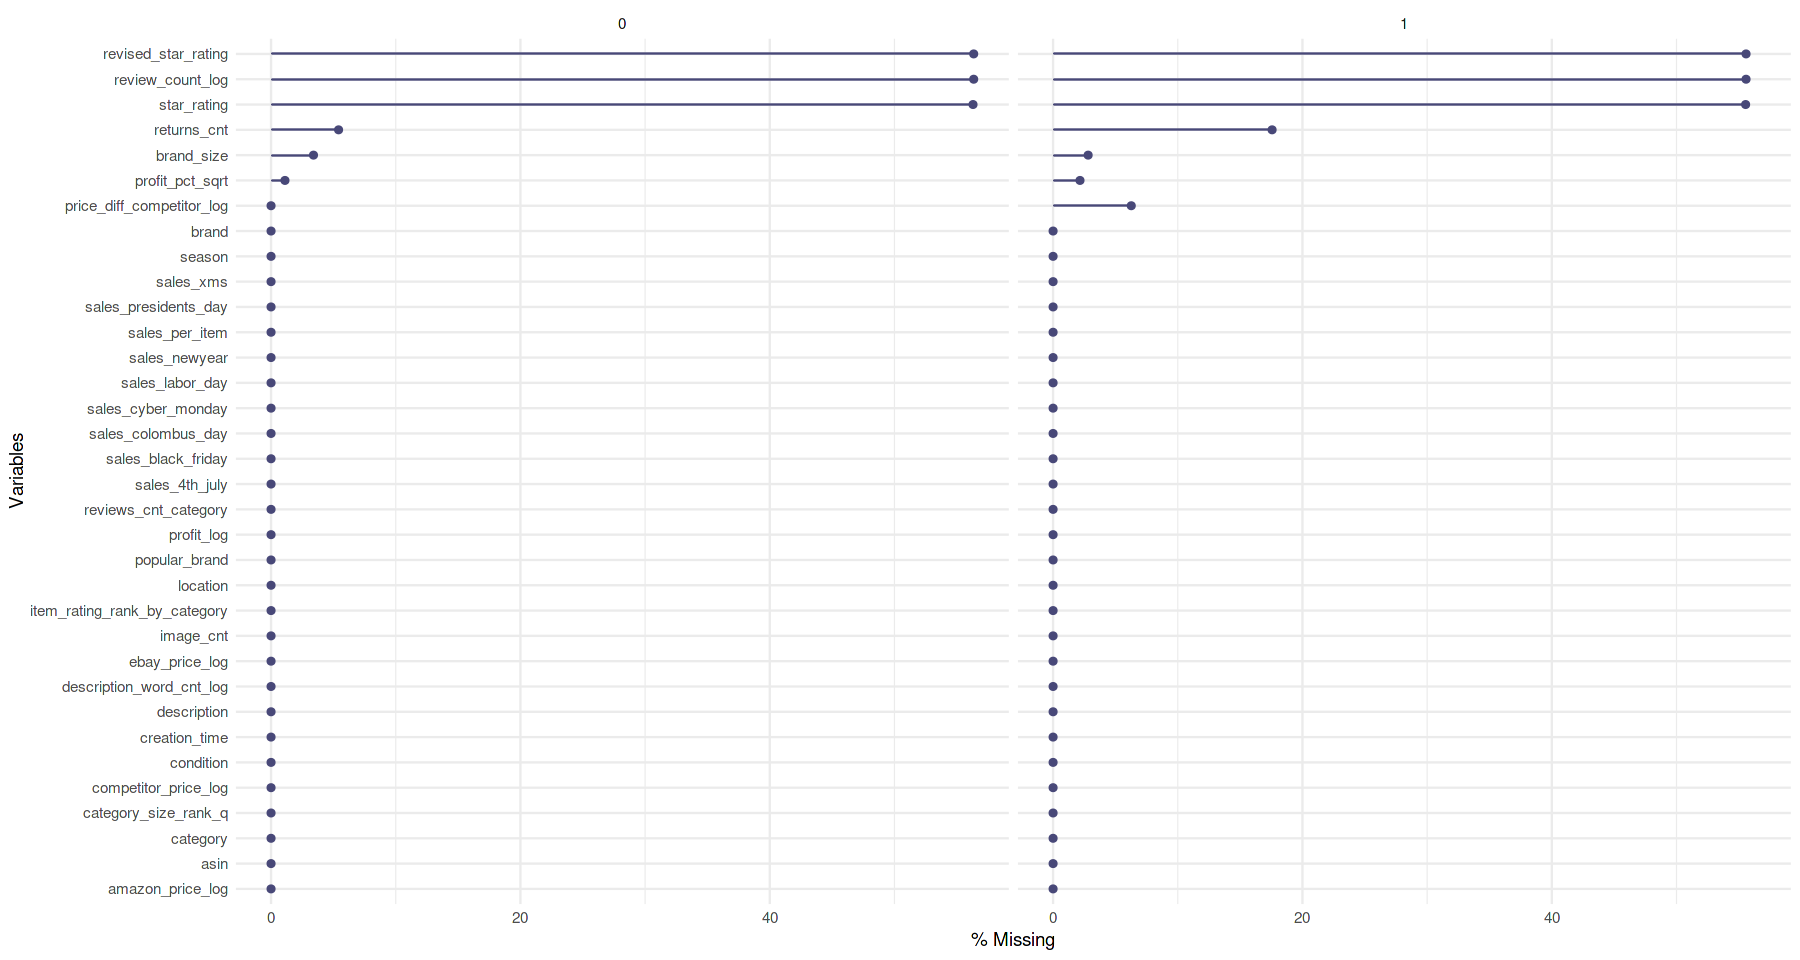

In [43]:
# show sample of the data missing value due to large dataset which unable to display in whole
library(naniar)
library(visdat)
library(gplots)
options(repr.plot.width = 15, repr.plot.height = 8)
Items %>% sample_n(25000) %>% vis_miss(warn_large_data=FALSE,large_data_size=10000000) # table is too large for visualization,
gg_miss_var(Items,show_pct = TRUE, facet= success)
#heatmap.2(Items[,numlst1],na.color = "black", trace = "none", density.info = "none")

check if there is any correlation between the missing values

In [44]:
Items_na <- Items_na[,mm$missingness$var]
head(Items_na)

revised_star_rating review_count_log star_rating returns_cnt brand_size
1 1                   1                1           0           0         
2 0                   0                0           0           0         
3 0                   0                0           0           0         
4 0                   0                0           0           0         
5 0                   0                0           0           0         
6 0                   0                0           0           0         
  profit_pct_sqrt price_diff_competitor_log brand
1 1               0                         0    
2 0               0                         0    
3 0               0                         0    
4 0               0                         0    
5 0               0                         0    
6 0               0                         0

check for the correlation between the missing indicators

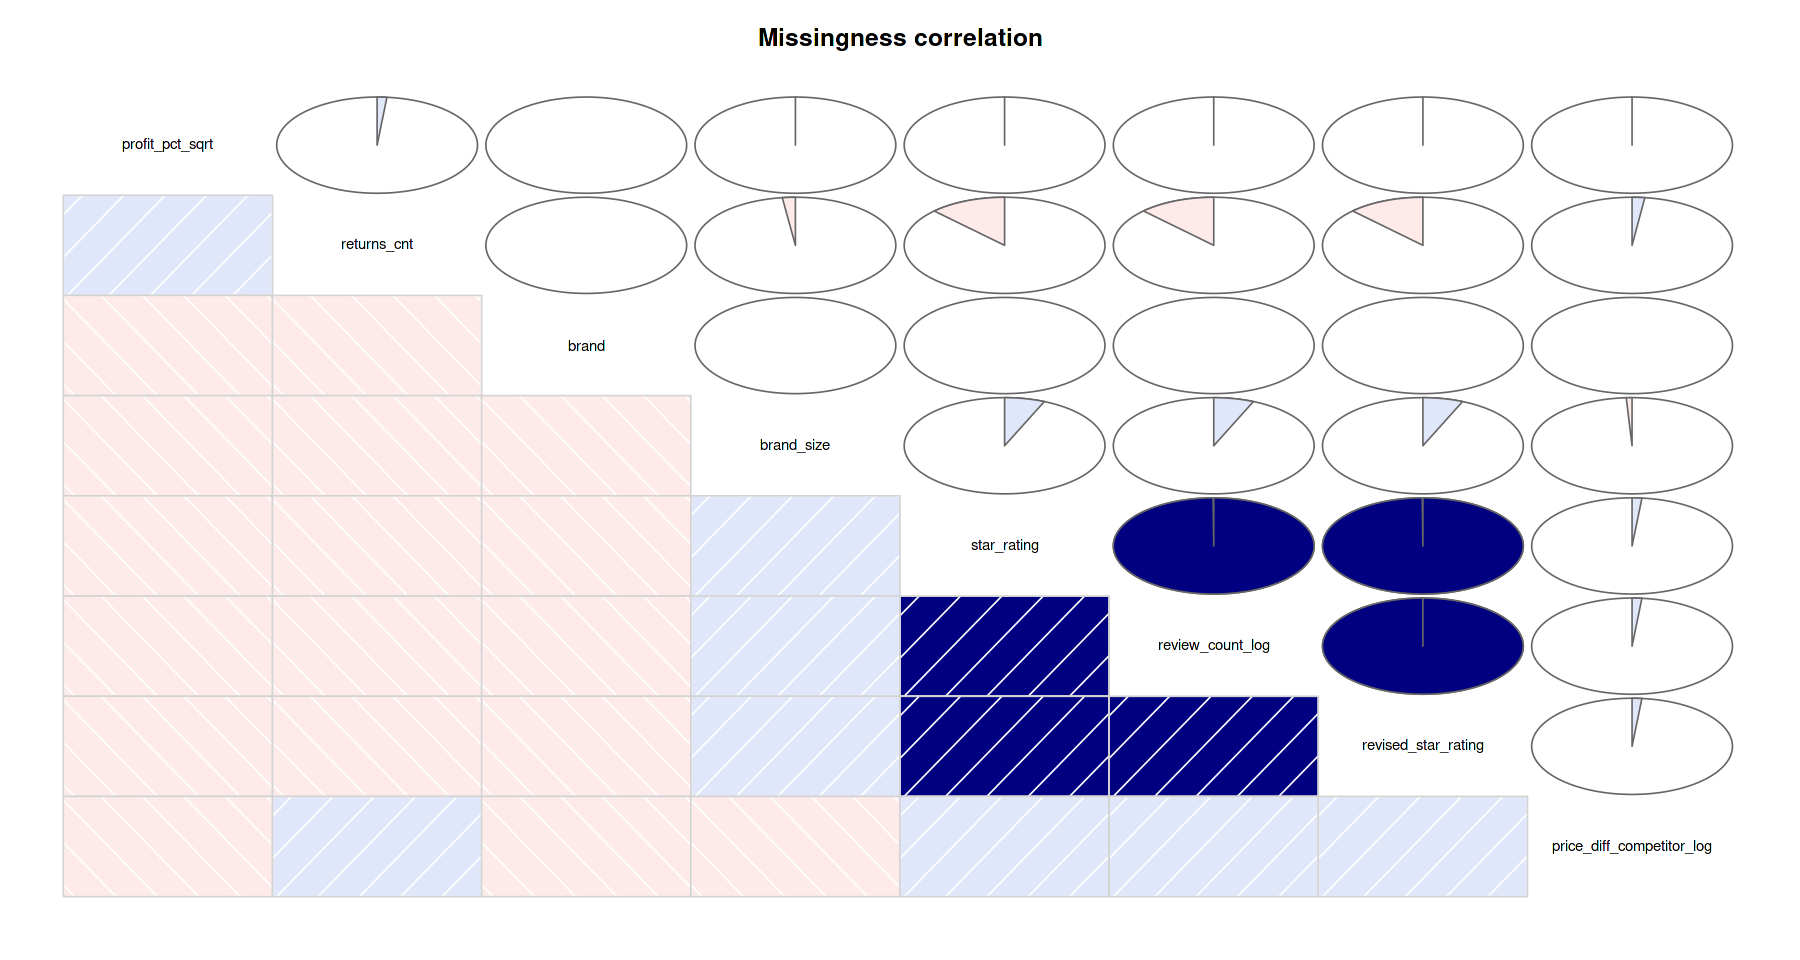

In [45]:
library(corrgram)
corrgram(Items_na, order=TRUE, lower.panel=panel.shade,
  upper.panel=panel.pie, text.panel=panel.txt,
  main="Missingness correlation")

We see correlation between star_rating and revised_star_rating missing and review_count_log-  this is excpected since when item review is missing all three vars would be missing as well.

[1] "revised_star_rating"
[1] "review_count_log"


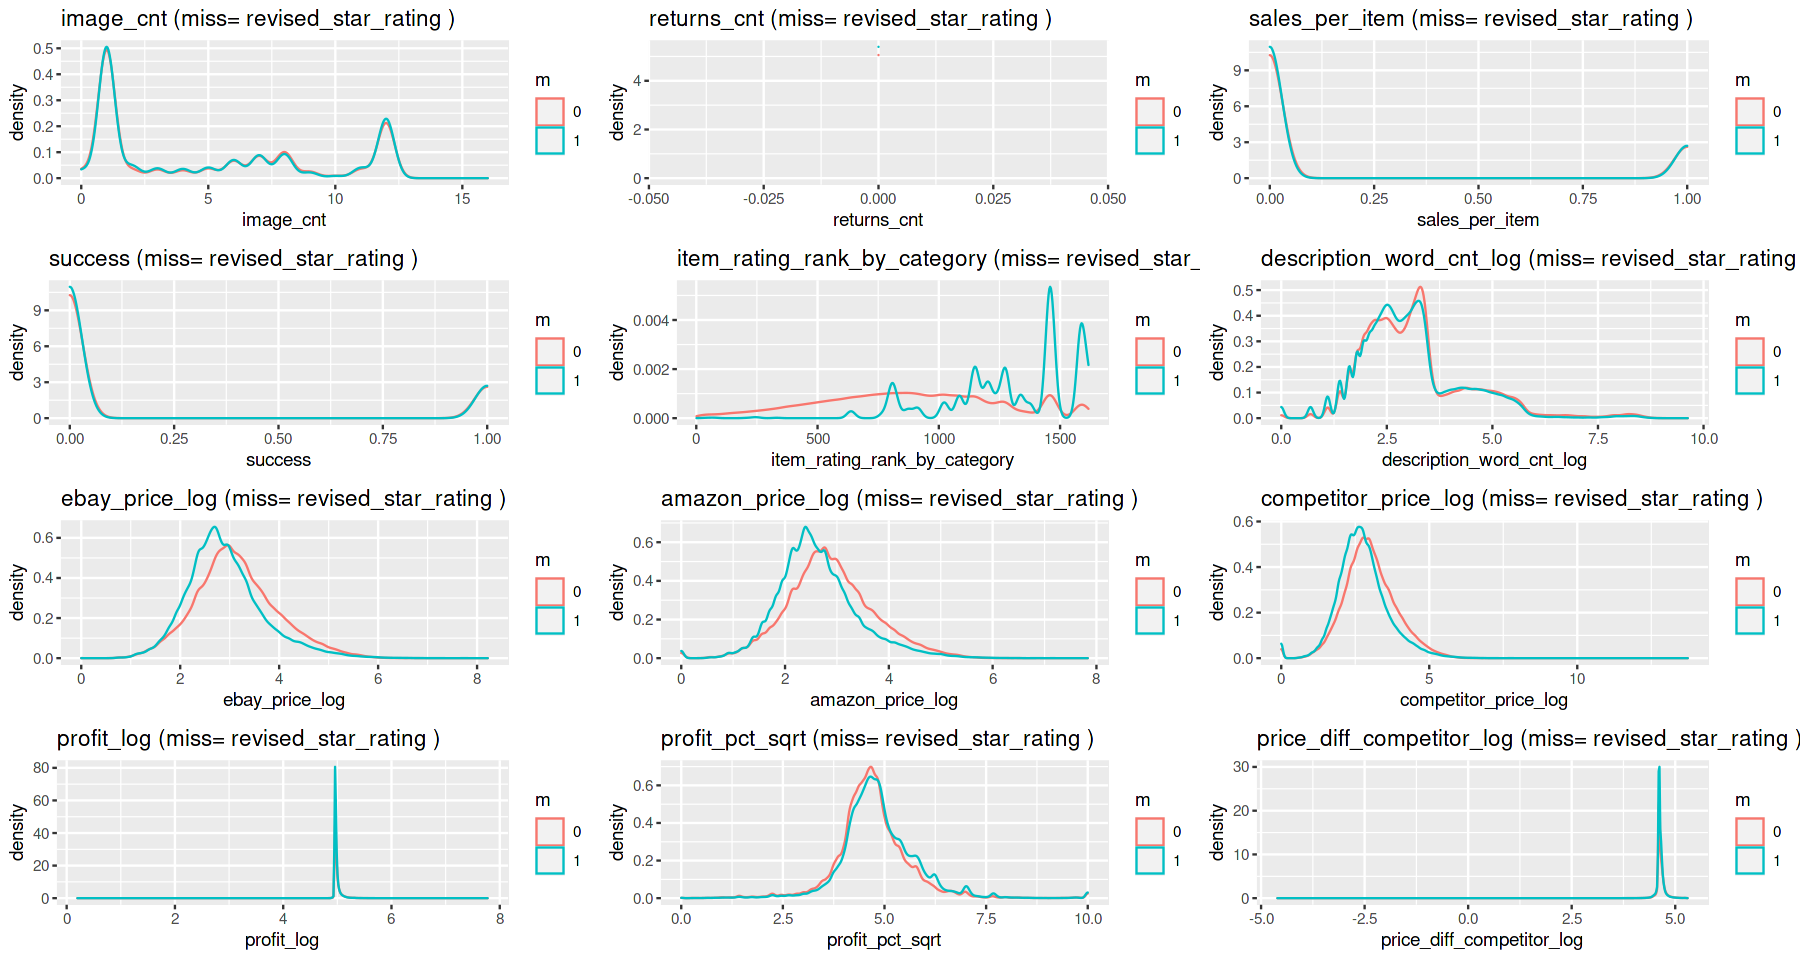

[1] "star_rating"


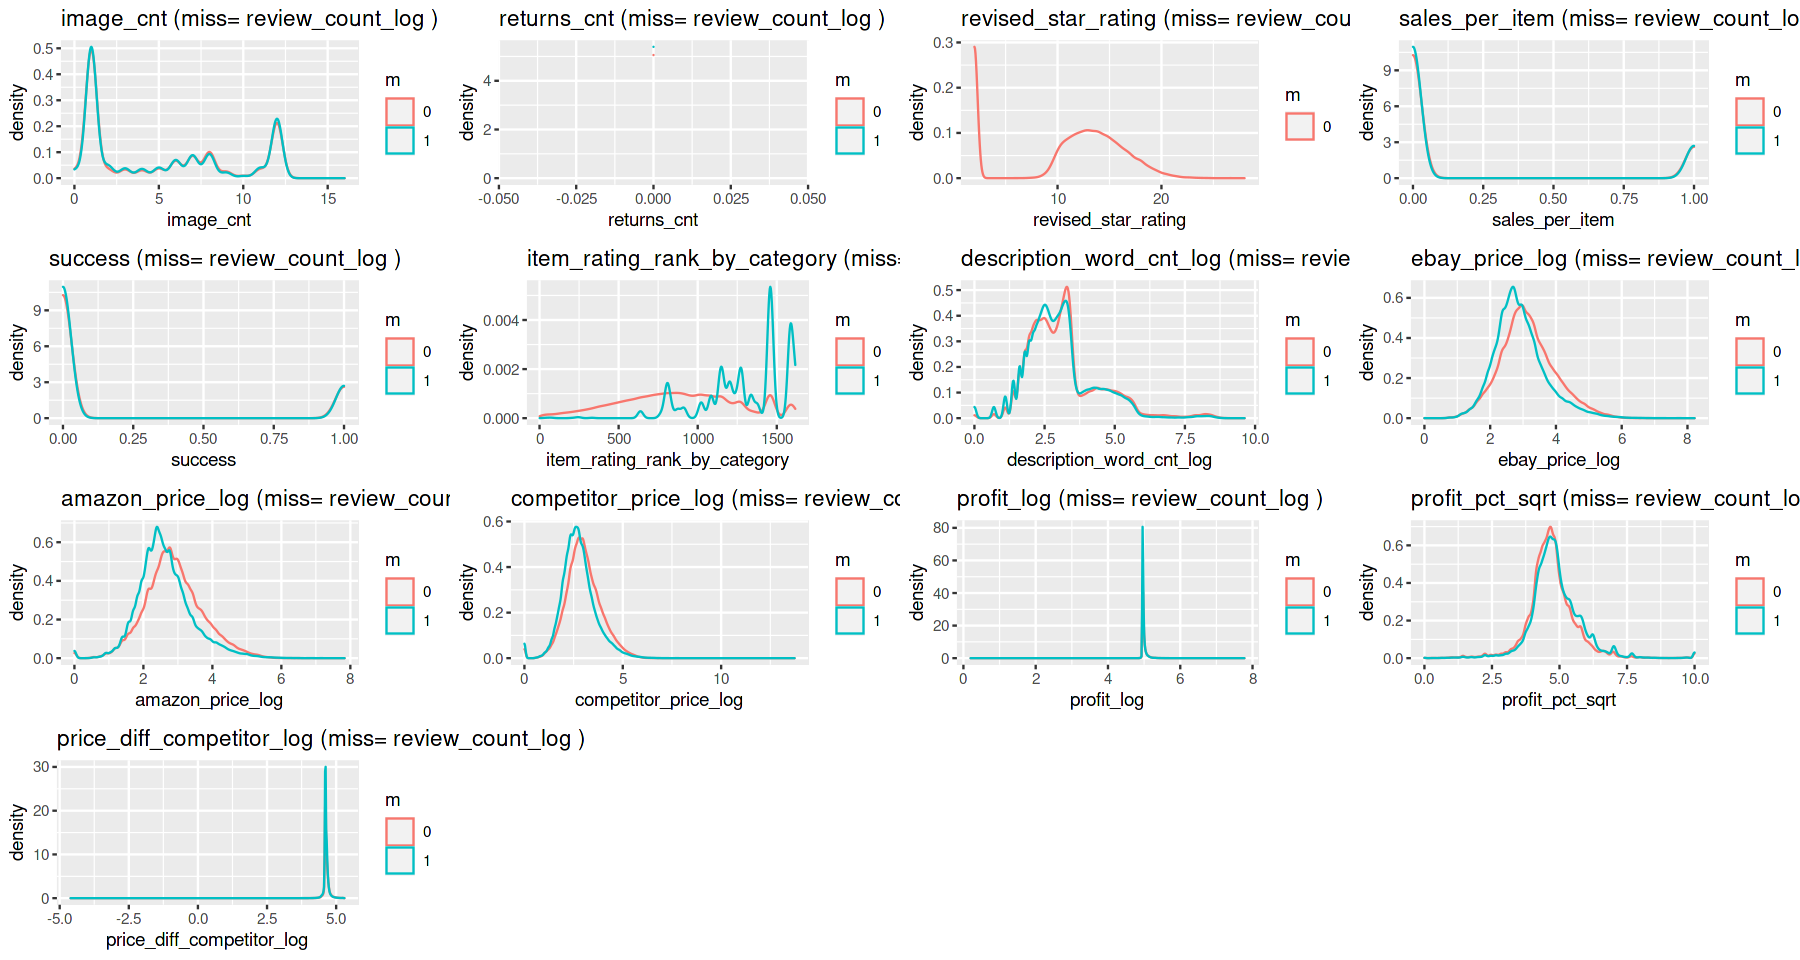

[1] "returns_cnt"


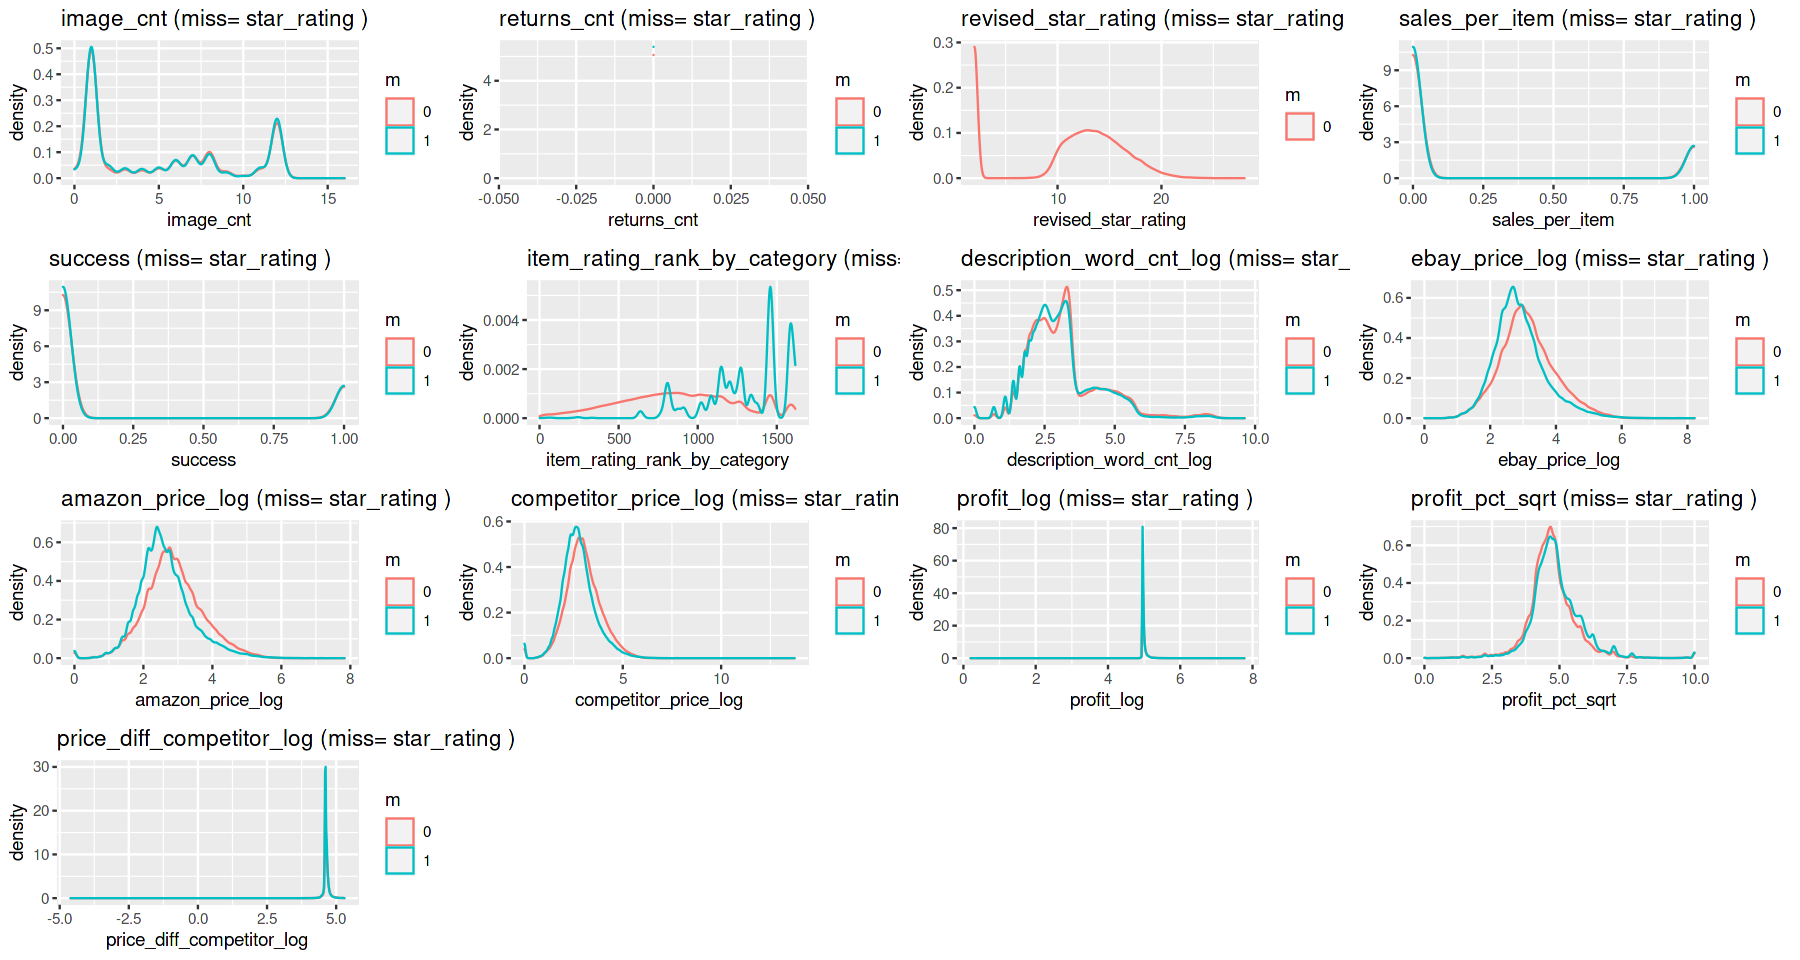

[1] "brand_size"


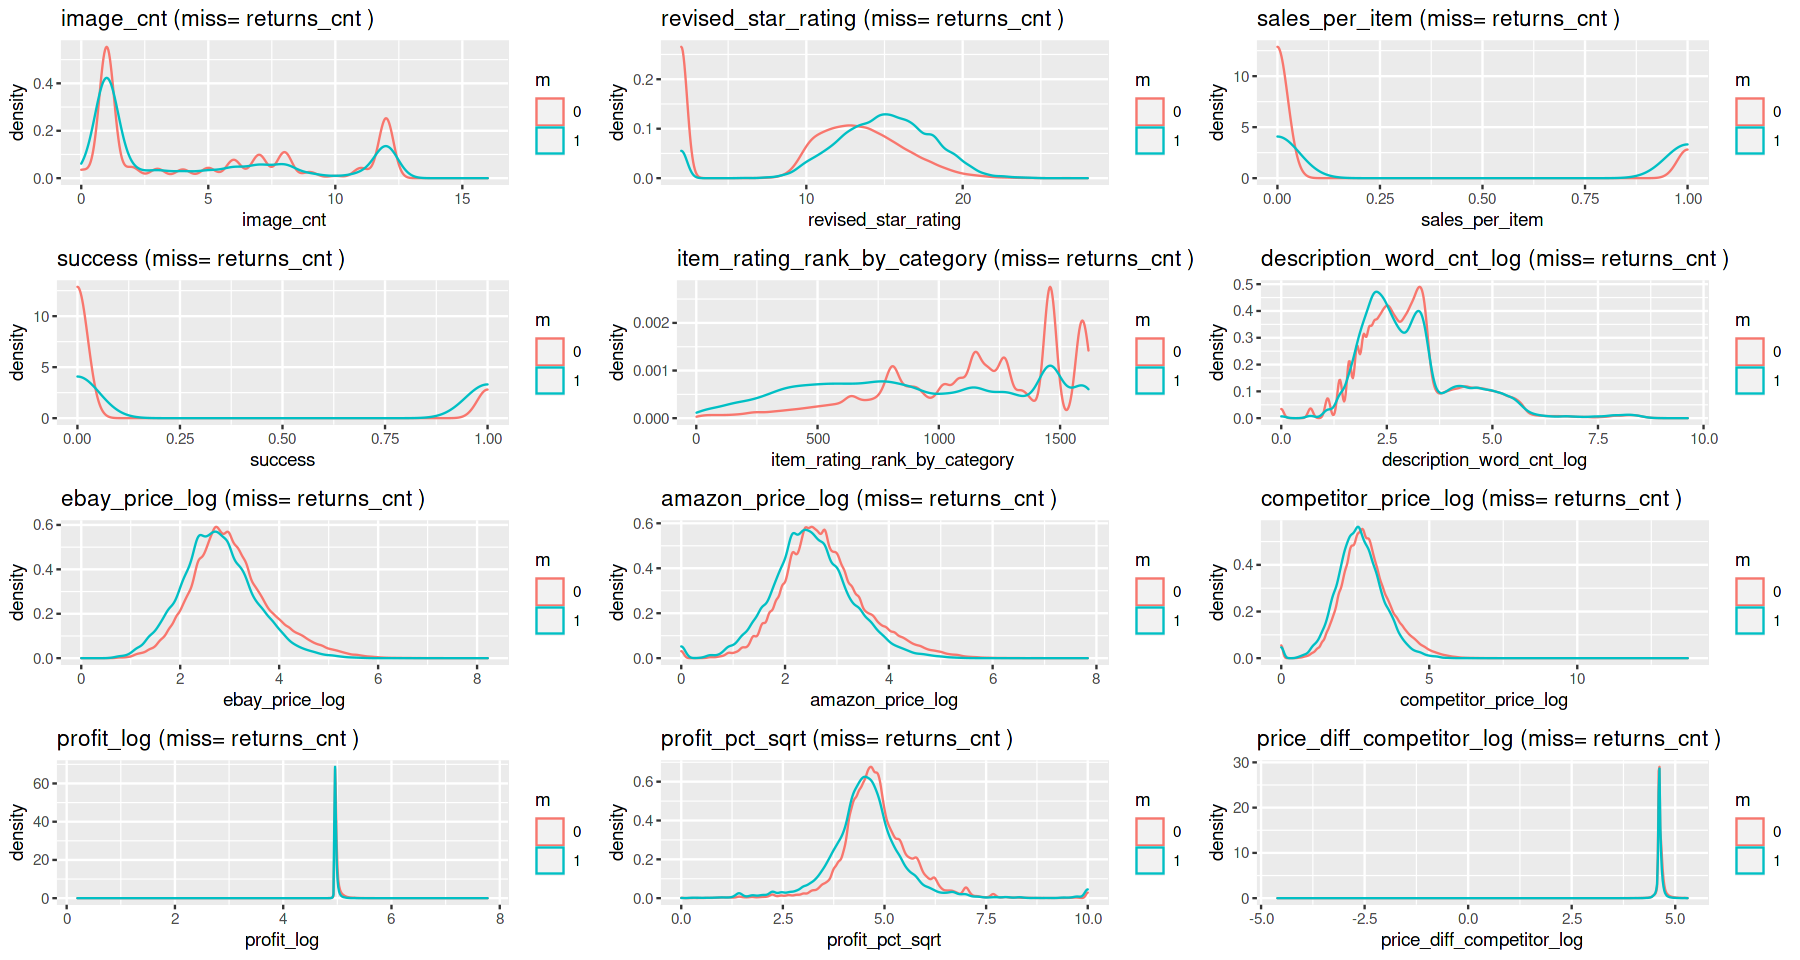

[1] "profit_pct_sqrt"


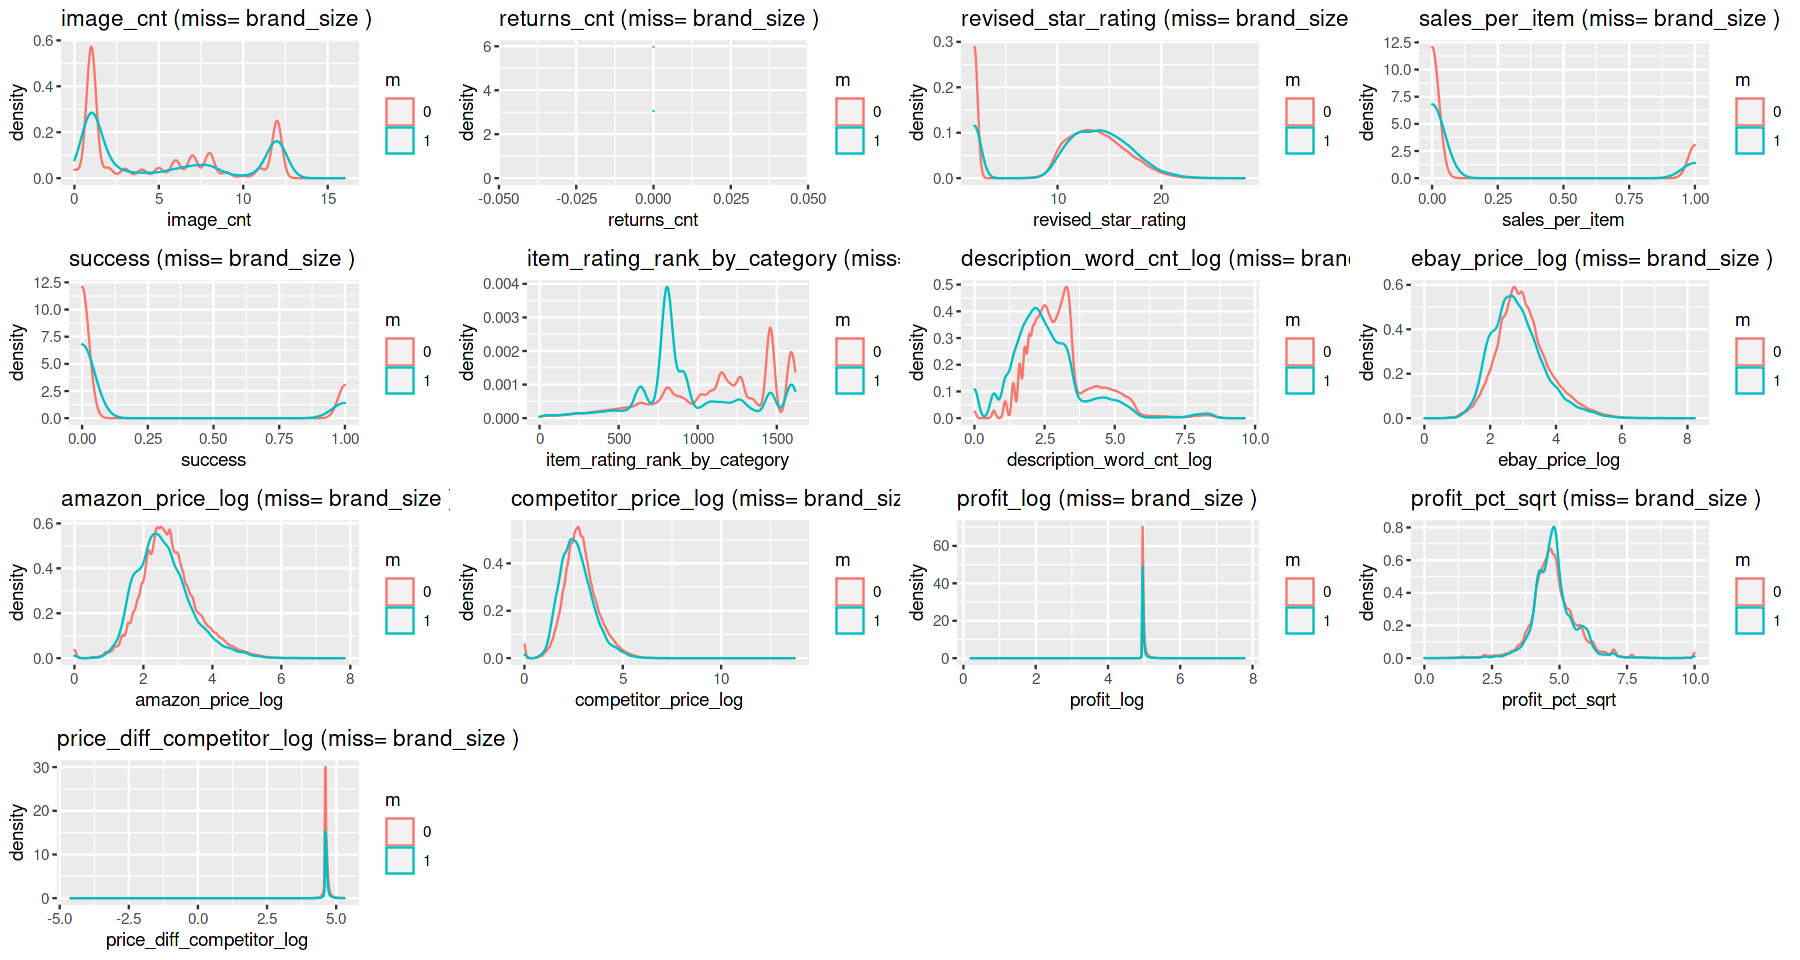

[1] "price_diff_competitor_log"


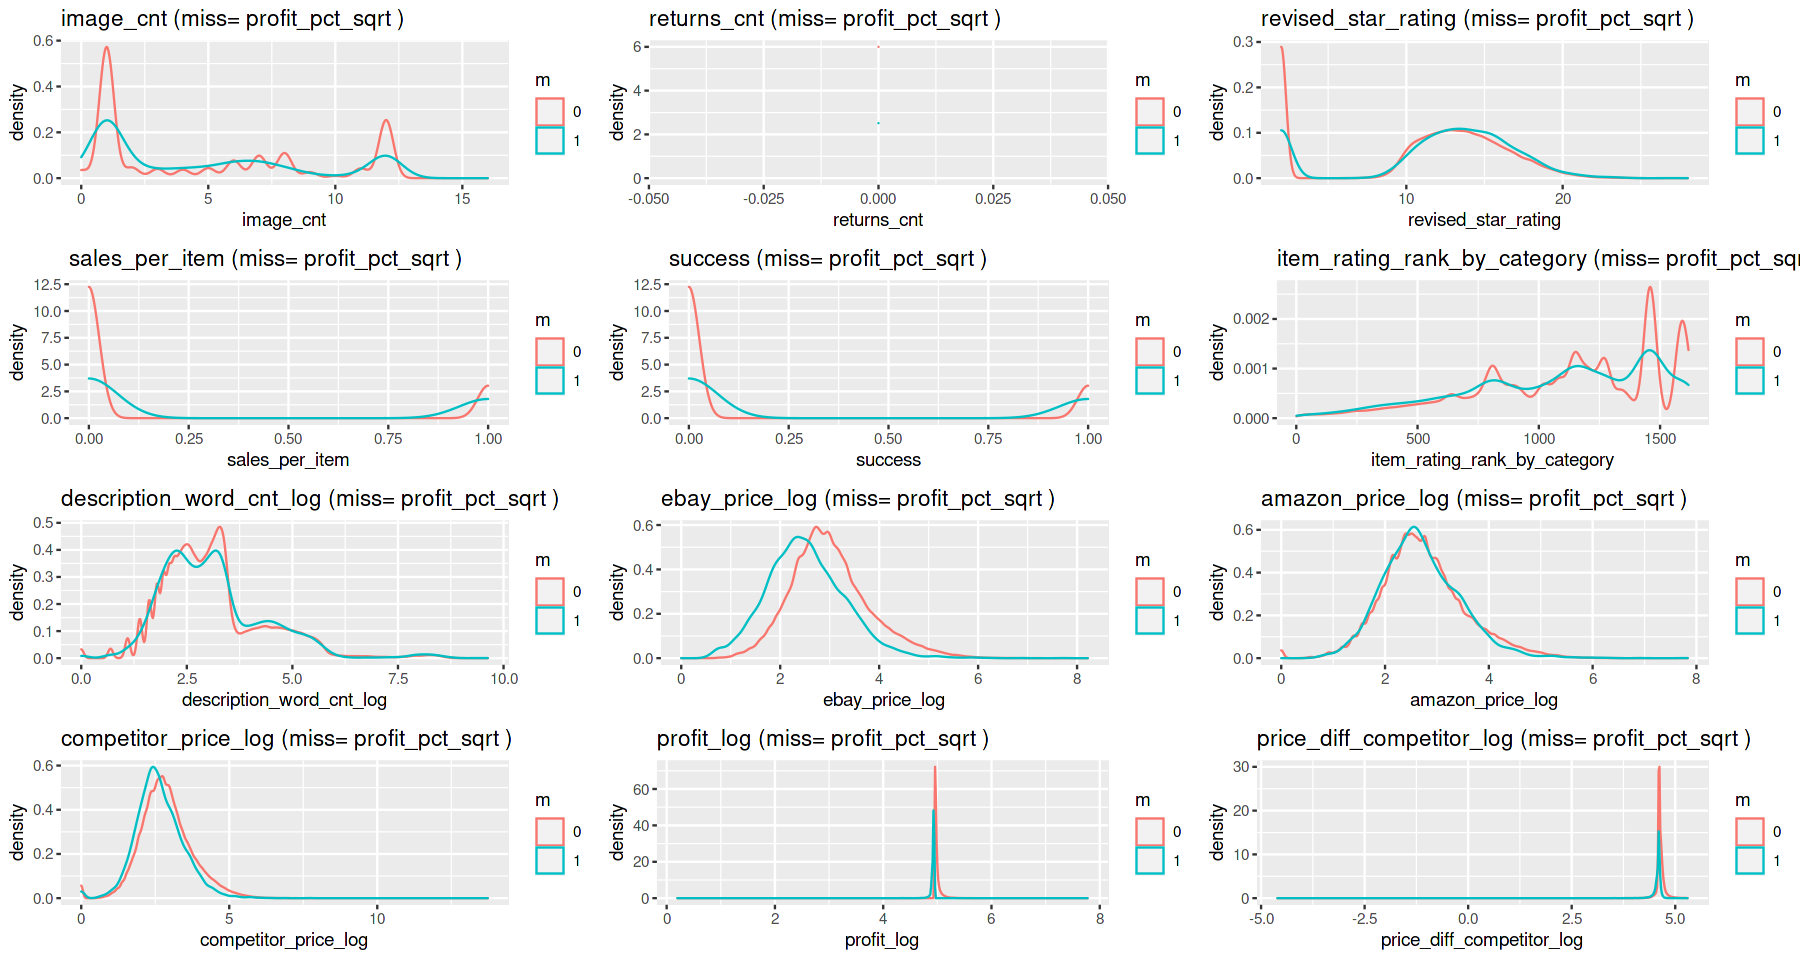

[1] "brand"


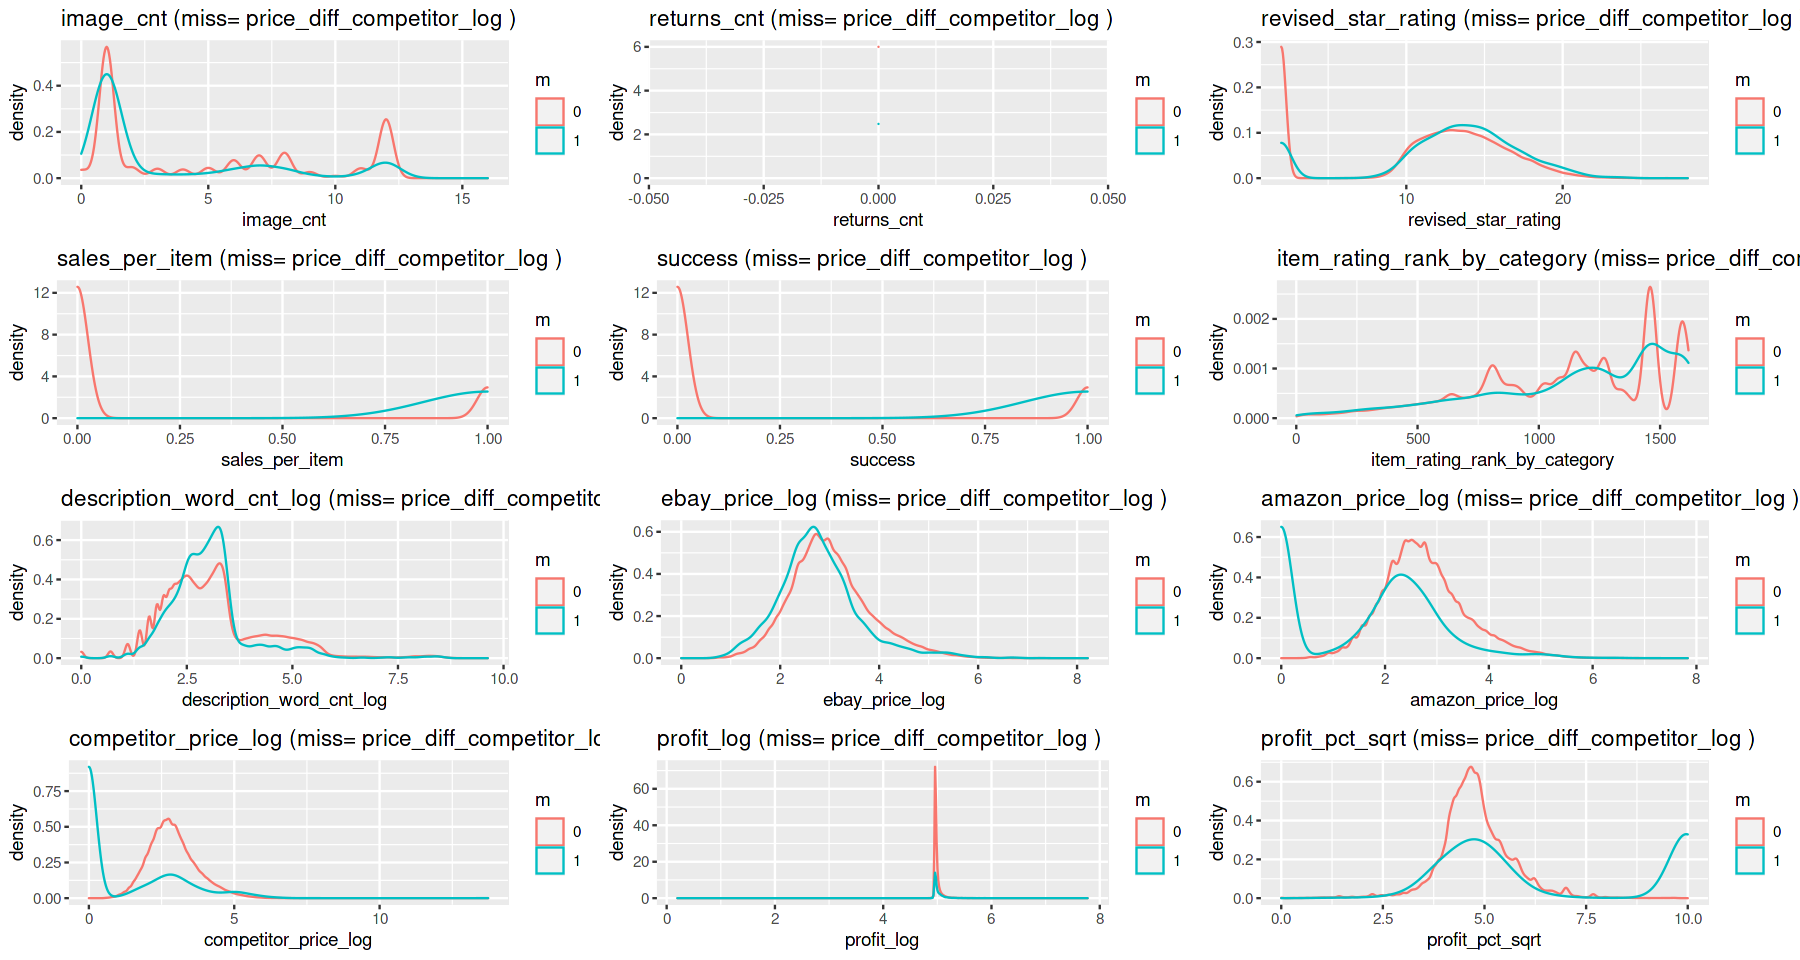

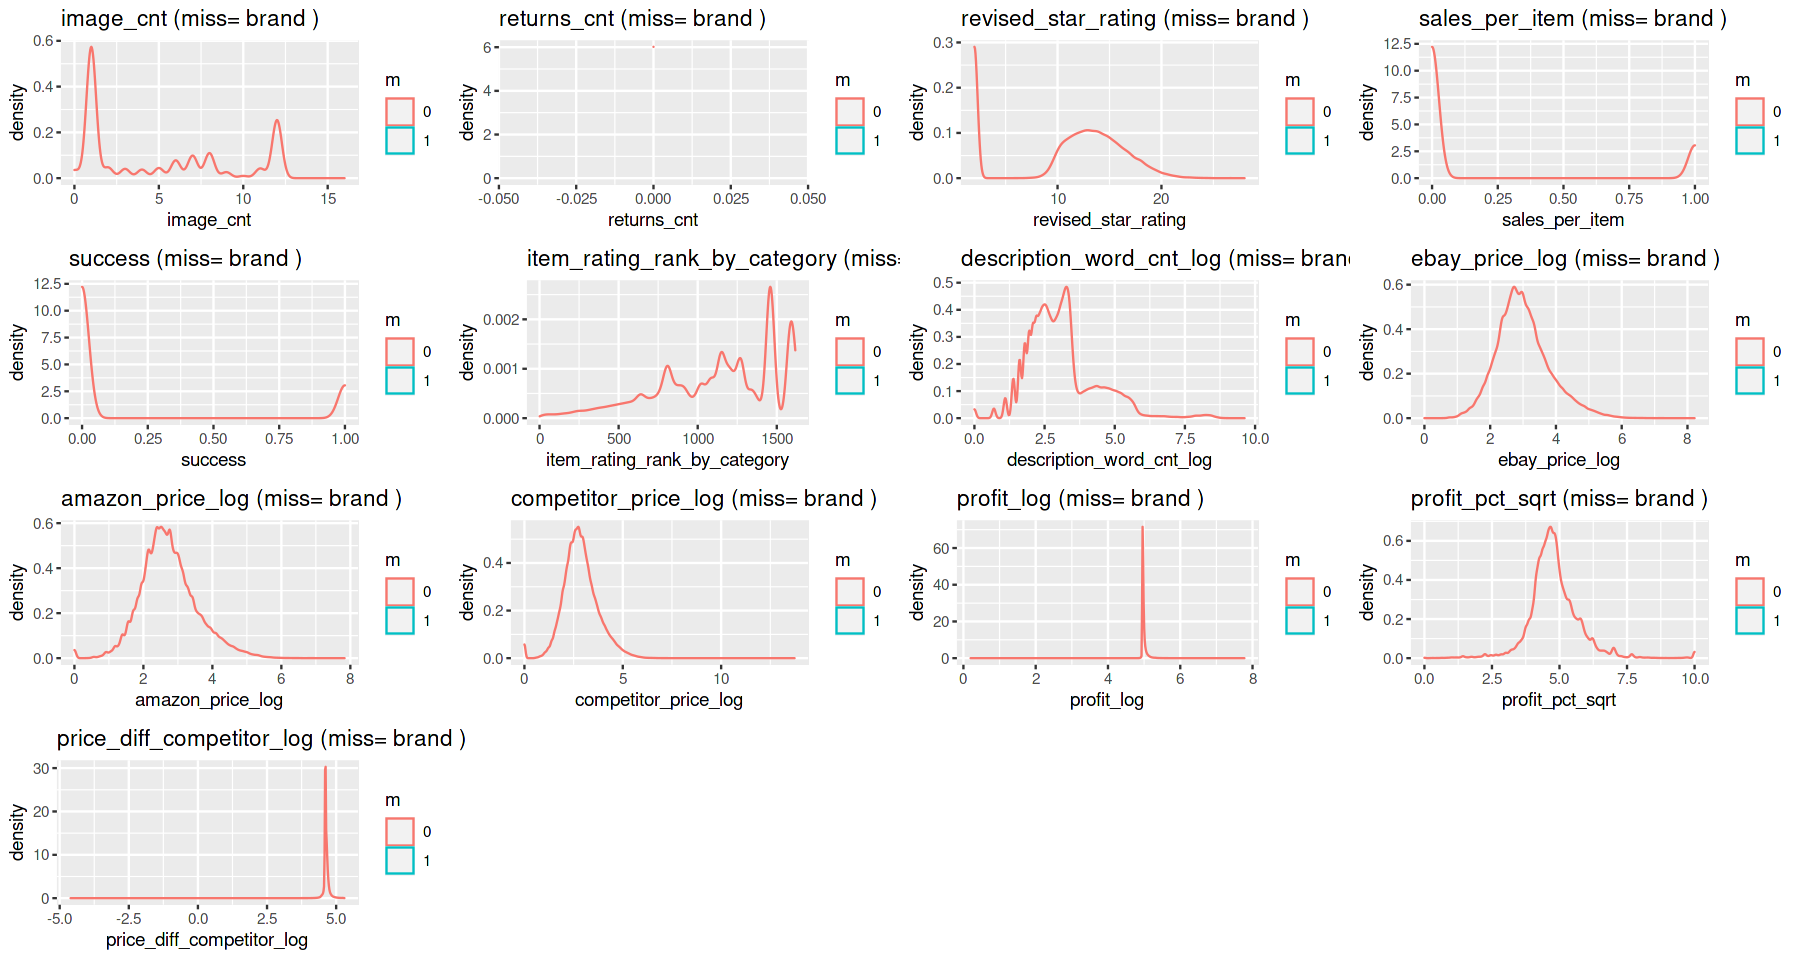

In [46]:
for (m in mm$missingness$var) {
    p <- list()
    i <- 1
    print(m)
    for (v in numlst1) {
        if (v != m){
                ff <- data.frame(v=Items[[v]],m=factor(Items_na[[m]]))
                p[[i]] <- suppressMessages(ggplot(data=ff,aes(x=v,group=m,color=m)) +
                  geom_density()+labs(title=paste(v, "(miss=", m,")"),x =v))
                i <- i + 1
                }
        }
    suppressWarnings(do.call(grid.arrange,p))
}

Couldn't find any variable that explains the missing mechanism

In [47]:
mm$missingness$var

[1] "revised_star_rating"       "review_count_log"         
[3] "star_rating"               "returns_cnt"              
[5] "brand_size"                "profit_pct_sqrt"          
[7] "price_diff_competitor_log" "brand"

In [48]:
res4 <- NULL
# pass on vriable 'brand' - only 1 missing value
for (m in mm$missingness$var[1:6]){
    p <- list()
    for (n in numlst1) {
        if (n != m) {
            miss <- Items[[n]]
            non <- Items[[n]][which(Items_na[[m]]==0)]
            missnum <- length(miss) - length(non)
            pval <- suppressWarnings(ks.test(miss, non)$p.value)
            res4 <- rbind(res4, cbind(var=n,missing=m, miss_cnt=missnum, distribution_changed=ifelse(pval<0.05,1,0)))
            }
    }
}
res4 <- as.data.frame(x=res4)
filter(res4,distribution_changed == 1)

var                          missing             miss_cnt
1  image_cnt                    revised_star_rating 280996  
2  item_rating_rank_by_category revised_star_rating 280996  
3  description_word_cnt_log     revised_star_rating 280996  
4  ebay_price_log               revised_star_rating 280996  
5  amazon_price_log             revised_star_rating 280996  
6  competitor_price_log         revised_star_rating 280996  
7  profit_log                   revised_star_rating 280996  
8  profit_pct_sqrt              revised_star_rating 280996  
9  price_diff_competitor_log    revised_star_rating 280996  
10 image_cnt                    review_count_log    280996  
11 item_rating_rank_by_category review_count_log    280996  
12 description_word_cnt_log     review_count_log    280996  
13 ebay_price_log               review_count_log    280996  
14 amazon_price_log             review_count_log    280996  
15 competitor_price_log         review_count_log    280996  
16 profit_log                   review_count_log    280996  
17 profit_pct_sqrt              review_count_log    280996  
18 price_diff_competitor_log    review_count_log    280996  
19 image_cnt                    star_rating         280744  
20 item_rating_rank_by_category star_rating         280744  
21 description_word_cnt_log     star_rating         280744  
22 ebay_price_log               star_rating         280744  
23 amazon_price_log             star_rating         280744  
24 competitor_price_log         star_rating         280744  
25 profit_log                   star_rating         280744  
26 profit_pct_sqrt              star_rating         280744  
27 price_diff_competitor_log    star_rating         280744  
28 image_cnt                    returns_cnt         39232   
29 revised_star_rating          returns_cnt         39232   
30 sales_per_item               returns_cnt         39232   
31 success                      returns_cnt         39232   
32 item_rating_rank_by_category returns_cnt         39232   
33 description_word_cnt_log     returns_cnt         39232   
34 ebay_price_log               returns_cnt         39232   
35 amazon_price_log             returns_cnt         39232   
36 competitor_price_log         returns_cnt         39232   
37 profit_log                   returns_cnt         39232   
38 profit_pct_sqrt              returns_cnt         39232   
39 price_diff_competitor_log    returns_cnt         39232   
40 item_rating_rank_by_category brand_size          16426   
41 description_word_cnt_log     brand_size          16426   
42 ebay_price_log               brand_size          16426   
43 amazon_price_log             brand_size          16426   
44 competitor_price_log         brand_size          16426   
45 profit_log                   brand_size          16426   
46 price_diff_competitor_log    brand_size          16426   
47 ebay_price_log               profit_pct_sqrt     6623    
48 profit_log                   profit_pct_sqrt     6623    
49 price_diff_competitor_log    profit_pct_sqrt     6623    
   distribution_changed
1  1                   
2  1                   
3  1                   
4  1                   
5  1                   
6  1                   
7  1                   
8  1                   
9  1                   
10 1                   
11 1                   
12 1                   
13 1                   
14 1                   
15 1                   
16 1                   
17 1                   
18 1                   
19 1                   
20 1                   
21 1                   
22 1                   
23 1                   
24 1                   
25 1                   
26 1                   
27 1                   
28 1                   
29 1                   
30 1                   
31 1                   
32 1                   
33 1                   
34 1                   
35 1                   
36 1                   
37 1                   
38 1                   
39 1             

**check lines with large number of missing values**

In [49]:
dfna_sum <- Items_na
dfna_sum$pct <- rowSums(Items_na)/ncol(Items_na) # percent of missing per row
dfna_sum$var <- col(Items_na)
dfna_sum %>% group_by(pct) %>% tally

library(naniar)
pct_miss_case(Items) # Percent of rows with any value missing
pct_complete_case(Items)# Percent of rows that are complete (no values missing) 

pct   n     
1 0.000 185293
2 0.125  32374
3 0.250   1537
4 0.375 248627
5 0.500  30907
6 0.625   1243
7 0.750     17
8 0.875      2

[1] 62.9414

[1] 37.0586

In [50]:
Items$drop <- ifelse(dfna_sum$pct >= 0.5,1,0)
Items <- Items %>% filter(Items$drop==0)
Items$drop <- NULL
Items_na <- missingMatrix(Items)

In [51]:
dfna_sum <- Items_na
dfna_sum$pct <- rowSums(Items_na)/ncol(Items_na)
dfna_sum %>% group_by(pct) %>% tally

pct        n     
1 0.00000000 185293
2 0.02857143  32374
3 0.05714286   1537
4 0.08571429 248627

In [52]:
dim(Items)

[1] 467831     35

# Test the missing mechanism using glm

I will look for variables that are correlated to the missing values.

**brand_size** - Na's probebly come from brand "Not Applicable"

**price_diff_competitor** - in outlier treatment I've set value -999 to NA. Original reason for value -999 was missing data in calculating price diff since there was no data in competitor_price



 **return_cnt**

 Na's came from outliears treatment- MNAR mechanism

In [53]:
summary(Items$returns_cnt)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0       0       0       0       0       0   25447 

In [54]:
# change var type to categorial and add new category "missing" for NA's. 
# 0 = No returns , 1 = missing data
Items$returns_cnt <-  ifelse(is.na(Items$returns_cnt),1,Items$returns_cnt)
Items$returns_cnt <- as.factor(Items$returns_cnt)
summary(Items$returns_cnt)

0      1 
442384  25447

Variable :**review_count_log**

In [55]:
#run 3 times with sample of the data with different seed

res <- NULL
for (i in seq(4,6)) {
    set.seed(i)
    sample <- Items[sample(nrow(Items),50000), ]
    set.seed(i)
    sample_na <- Items_na[sample(nrow(Items_na),50000), ]

    for (n in numlst1) {
        if (n != 'review_count_log'){
            mod <- suppressWarnings(glm(sample_na$review_count_log ~ sample[[n]], family="binomial"))
            sm <- summary(mod)
            if(is.null(sm)==FALSE) {
              sm2 <- data.frame(pvalue=sm$coefficients[,4][2])
              res <- rbind(res, cbind(n,sm2))
            } else {
              print(sm)
            }
        }
    }
    
    for (n in strlst) {
        mod <- suppressWarnings(glm(sample_na$review_count_log ~ sample[[n]], family="binomial"))
        sm <- summary(mod)
        if(is.null(sm)==FALSE) {
          sm2 <- data.frame(pvalue=sm$coefficients[,4][2])
          res <- rbind(res, cbind(n,sm2))
        } else {
          print(sm)
        }
    }
    i <- i+1
}
    
row.names(res) <- NULL
res  %>% filter(pvalue<0.01)

n                            pvalue       
1  image_cnt                     9.957881e-03
2  returns_cnt                   1.897280e-16
3  sales_per_item                8.159152e-21
4  success                       8.159152e-21
5  item_rating_rank_by_category  0.000000e+00
6  description_word_cnt_log      1.000369e-13
7  ebay_price_log               1.488574e-161
8  amazon_price_log             3.464147e-187
9  competitor_price_log         2.304686e-141
10 profit_log                    3.532055e-24
11 profit_pct_sqrt               7.507167e-81
12 price_diff_competitor_log     9.515728e-11
13 season                        1.359745e-37
14 location                      1.440302e-42
15 condition                     3.056579e-44
16 sales_xms                     3.259130e-04
17 popular_brand                 1.611045e-17
18 returns_cnt                   5.935564e-42
19 sales_per_item                2.867503e-22
20 success                       2.867503e-22
21 item_rating_rank_by_category  0.000000e+00
22 description_word_cnt_log      1.498633e-16
23 ebay_price_log               5.069998e-147
24 amazon_price_log             1.680832e-172
25 competitor_price_log         2.081649e-129
26 profit_log                    1.480031e-19
27 profit_pct_sqrt               2.892937e-81
28 price_diff_competitor_log     5.970529e-13
29 season                        1.110902e-30
30 location                      1.125320e-47
31 condition                     1.542143e-43
32 popular_brand                 1.768919e-10
33 image_cnt                     4.796564e-03
34 returns_cnt                   1.704821e-41
35 sales_per_item                8.801307e-19
36 success                       8.801307e-19
37 item_rating_rank_by_category  0.000000e+00
38 description_word_cnt_log      5.113999e-16
39 ebay_price_log               1.229147e-149
40 amazon_price_log             6.030492e-174
41 competitor_price_log         1.356255e-128
42 profit_log                    4.545957e-19
43 profit_pct_sqrt               1.115314e-83
44 price_diff_competitor_log     2.815980e-10
45 season                        1.171126e-27
46 location                      2.004870e-53
47 condition                     4.085159e-36
48 popular_brand                 3.526837e-13

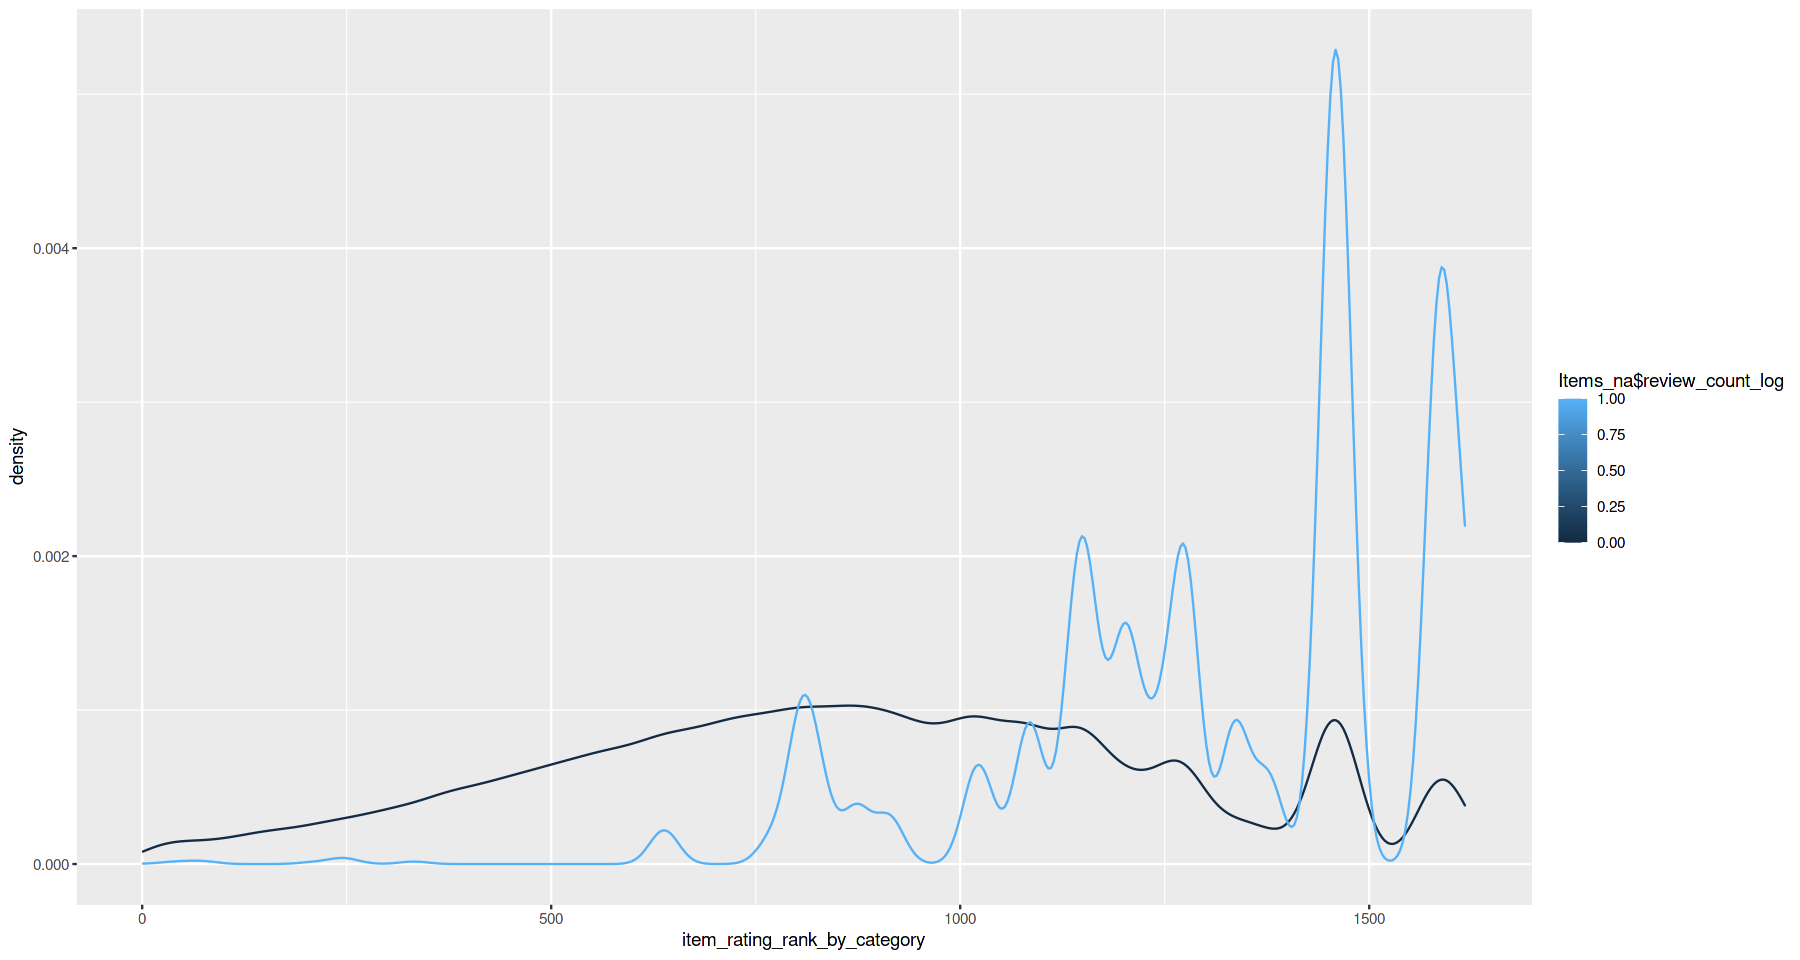

In [56]:
ggplot(data=Items) +
        geom_density(aes(x=item_rating_rank_by_category, group=Items_na$review_count_log, color=Items_na$review_count_log))# + xlim(0,10)

variable review_count_log missing mechanism is MNAR, many variables can "explain" the missing values

In [57]:
# add new category "missing" for NA's
Items$review_count_log <-  ifelse(is.na(Items$review_count_log),"missing",Items$review_count_log)
Items$review_count_log <- as.factor(Items$review_count_log)
summary(Items$review_count_log)

1       2       3       4 missing 
  54837   54694   54630   54843  248827

test the missing mechanism using glm for variable : **star rating**

In [58]:
#run 3 times with sample of the data with different seed

res <- NULL
for (i in seq(4,6)) {
    set.seed(i)
    sample <- Items[sample(nrow(Items),50000), ]
    set.seed(i)
    sample_na <- Items_na[sample(nrow(Items_na),50000), ]

    for (n in numlst1) {
        mod <- suppressWarnings(glm(sample_na$star_rating ~ sample[[n]], family="binomial"))
        sm <- summary(mod)
        if(is.null(sm)==FALSE) {
          sm2 <- data.frame(pvalue=sm$coefficients[,4][2])
          res <- rbind(res, cbind(n,sm2))
        } else {
          print(sm)
        }
    }
    for (n in strlst) {
        mod <- suppressWarnings(glm(sample_na$star_rating ~ sample[[n]], family="binomial"))
        sm <- summary(mod)
        if(is.null(sm)==FALSE) {
          sm2 <- data.frame(pvalue=sm$coefficients[,4][2])
          res <- rbind(res, cbind(n,sm2))
        } else {
          print(sm)
        }
    }
    i <- i+1
}
    
row.names(res) <- NULL
res %>% filter(pvalue<0.05)

n                            pvalue       
1  image_cnt                     1.466893e-02
2  sales_per_item                1.189974e-20
3  success                       1.189974e-20
4  item_rating_rank_by_category  0.000000e+00
5  description_word_cnt_log      4.260080e-14
6  ebay_price_log               1.336345e-162
7  amazon_price_log             2.869800e-188
8  competitor_price_log         3.720012e-142
9  profit_log                    2.677048e-24
10 profit_pct_sqrt               1.089988e-80
11 price_diff_competitor_log     5.802227e-11
12 season                        2.282020e-37
13 location                      3.981247e-42
14 condition                     2.449557e-44
15 sales_colombus_day            4.645897e-02
16 sales_xms                     3.559752e-04
17 popular_brand                 2.018056e-17
18 sales_per_item                2.445136e-22
19 success                       2.445136e-22
20 item_rating_rank_by_category  0.000000e+00
21 description_word_cnt_log      7.558566e-17
22 ebay_price_log               5.983881e-148
23 amazon_price_log             1.645677e-173
24 competitor_price_log         2.338534e-130
25 profit_log                    1.205372e-19
26 profit_pct_sqrt               2.372593e-81
27 price_diff_competitor_log     5.002718e-13
28 season                        5.719009e-31
29 location                      2.560620e-47
30 condition                     2.932014e-43
31 popular_brand                 2.011313e-10
32 image_cnt                     4.168108e-03
33 sales_per_item                1.102801e-18
34 success                       1.102801e-18
35 item_rating_rank_by_category  0.000000e+00
36 description_word_cnt_log      2.988158e-16
37 ebay_price_log               6.269862e-151
38 amazon_price_log             1.485210e-175
39 competitor_price_log         5.694058e-130
40 profit_log                    4.591451e-19
41 profit_pct_sqrt               1.505311e-84
42 price_diff_competitor_log     3.795094e-10
43 season                        2.171916e-27
44 location                      1.783594e-53
45 condition                     4.993176e-36
46 popular_brand                 4.175109e-13

variable star_rating missing mechanism is MNAR, many variable can "explain" the missing values

**revised_star_rating** comes from the same data therefore the missing mechanism is identical and I'll categorise it as well

In [59]:
# add new category "missing" for NA's
Items$star_rating <-  ifelse(is.na(Items$star_rating),"missing",Items$star_rating)
Items$star_rating <- as.factor(Items$star_rating)
summary(Items$star_rating)

1       2       3       4 missing 
  52531   25334   75024   66367  248575

In [60]:
summary(Items$revised_star_rating)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   2.00    9.66   12.56   11.21   15.03   28.00  248827 

In [61]:
Items$revised_star_rating <- case_when(
  Items$revised_star_rating <= 2 ~ "Low",
  Items$revised_star_rating > 2 & Items$revised_star_rating < 9.66 ~ "Q1",
  Items$revised_star_rating >= 9.66 & Items$revised_star_rating < 11.21 ~ "Q2",
    Items$revised_star_rating >= 11.21 & Items$revised_star_rating < 15.03 ~ "Q3",
  Items$revised_star_rating >= 15.03 ~ "Q4",
  is.na(Items$revised_star_rating) ~ "missing")
Items$revised_star_rating <- as.factor(Items$revised_star_rating)
summary(Items$revised_star_rating)

Low missing      Q1      Q2      Q3      Q4 
  49342  248827    5399   25282   84220   54761

**brand_size**

In [62]:
Items$brand <- as.factor(Items$brand)
df <- Items %>% 
    group_by(brand) %>% 
    summarise(total=n()) %>% arrange(desc(total))
df %>% filter(df$total > 1000)
summary(Items$brand_size)

brand          total
1 None           11415
2 Not Applicable  4339

Large    med  Small   NA's 
 44151  36516 382825   4339

I'll set all missing values to category "Not Applicable"

In [63]:
summary(Items$brand_size)
Items$brand_size <- ifelse(is.na(Items$brand_size),"Not Applicable",Items$brand_size)
Items$brand_size <- as.factor(Items$brand_size)
summary(Items$brand_size)

Large    med  Small   NA's 
 44151  36516 382825   4339

1              2              3 Not Applicable 
         44151          36516         382825           4339

In [64]:
Items$brand[is.na(Items$brand)] <- "Not Applicable" # set single NA in brand to "Not Applicable"
summary(is.na(Items$brand))

   Mode   FALSE 
logical  467831 

None of the variables can explain the missing values

**price_diff_competitor**

In [65]:
#run 3 times with sample of the data with different seed

res <- NULL
for (i in seq(4,6)) {
    set.seed(i)
    sample <- Items[sample(nrow(Items),50000), ]
    set.seed(i)
    sample_na <- Items_na[sample(nrow(Items_na),50000), ]

    for (n in numlst1) {
        mod <- suppressWarnings(glm(sample_na$price_diff_competitor_log ~ sample[[n]], family="binomial"))
        sm <- summary(mod)
        if(is.null(sm)==FALSE) {
          sm2 <- data.frame(pvalue=sm$coefficients[,4][2])
          res <- rbind(res, cbind(n,sm2))
        } else {
          print(sm)
        }
    }
    for (n in strlst) {
        mod <- suppressWarnings(glm(sample_na$price_diff_competitor_log ~ sample[[n]], family="binomial"))
        sm <- summary(mod)
        if(is.null(sm)==FALSE) {
          sm2 <- data.frame(pvalue=sm$coefficients[,4][2])
          res <- rbind(res, cbind(n,sm2))
        } else {
          print(sm)
        }
    }
    i <- i+1
}
    
row.names(res) <- NULL
res %>% filter(pvalue<0.05)

n                            pvalue       
1  image_cnt                     5.231306e-09
2  returns_cnt                   3.246534e-19
3  item_rating_rank_by_category  1.066129e-34
4  ebay_price_log                3.263634e-03
5  amazon_price_log             4.094213e-130
6  competitor_price_log         1.278403e-199
7  profit_log                    3.979250e-14
8  profit_pct_sqrt              6.707018e-191
9  season                        1.129819e-03
10 sales_black_friday            1.253903e-03
11 sales_labor_day               1.066834e-06
12 sales_presidents_day          4.933378e-02
13 sales_newyear                 1.227962e-04
14 sales_xms                     1.145231e-28
15 reviews_cnt_category          2.155540e-06
16 image_cnt                     1.320338e-14
17 returns_cnt                   9.266003e-20
18 item_rating_rank_by_category  4.682327e-37
19 ebay_price_log                5.163097e-05
20 amazon_price_log             5.037080e-119
21 competitor_price_log         8.467978e-193
22 profit_log                    4.961041e-12
23 profit_pct_sqrt              4.511749e-177
24 season                        2.781344e-02
25 location                      6.581473e-04
26 sales_cyber_monday            7.552011e-11
27 sales_presidents_day          1.310051e-06
28 sales_4th_july                3.804153e-07
29 sales_xms                     1.324596e-06
30 reviews_cnt_category          2.919741e-05
31 image_cnt                     1.808327e-11
32 returns_cnt                   3.998152e-11
33 item_rating_rank_by_category  6.055961e-31
34 description_word_cnt_log      1.525695e-02
35 ebay_price_log                1.020976e-03
36 amazon_price_log             2.068557e-149
37 competitor_price_log         4.012170e-177
38 profit_log                    3.126526e-15
39 profit_pct_sqrt              6.078726e-202
40 location                      9.761418e-05
41 sales_xms                     2.285071e-02
42 reviews_cnt_category          2.232180e-03

Warning message:
“Removed 4829 rows containing non-finite values (stat_density).”
Warning message:
“Removed 7784 rows containing non-finite values (stat_density).”


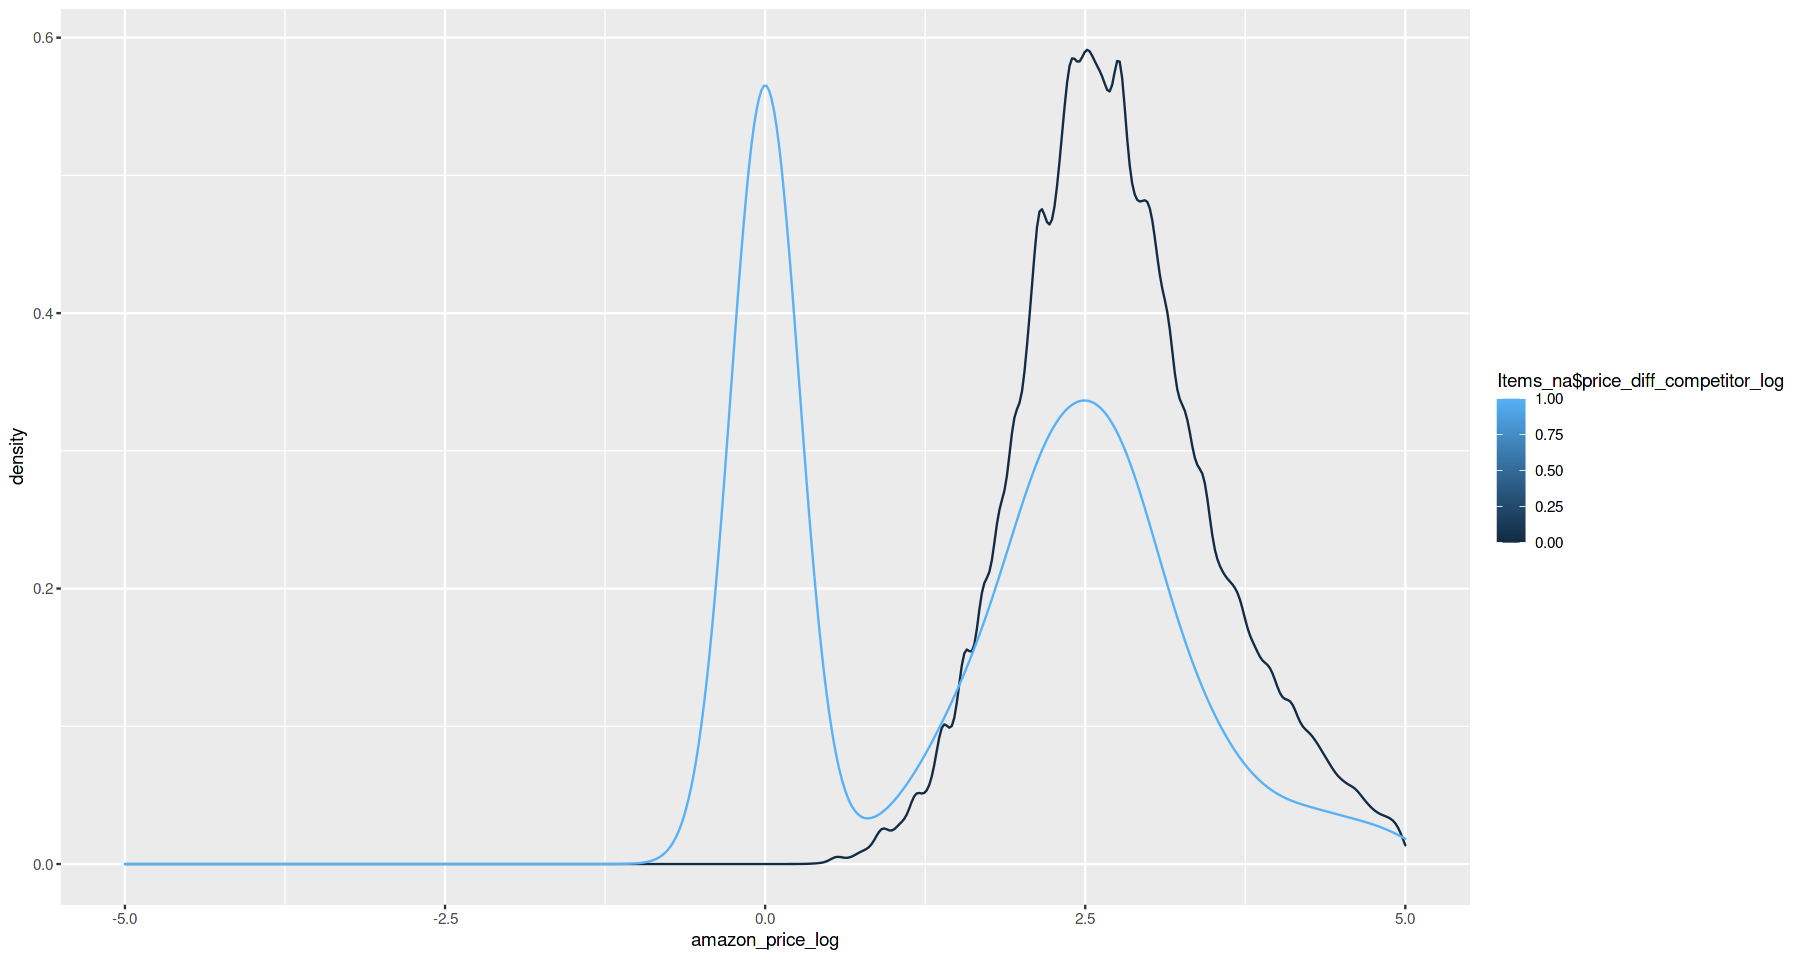

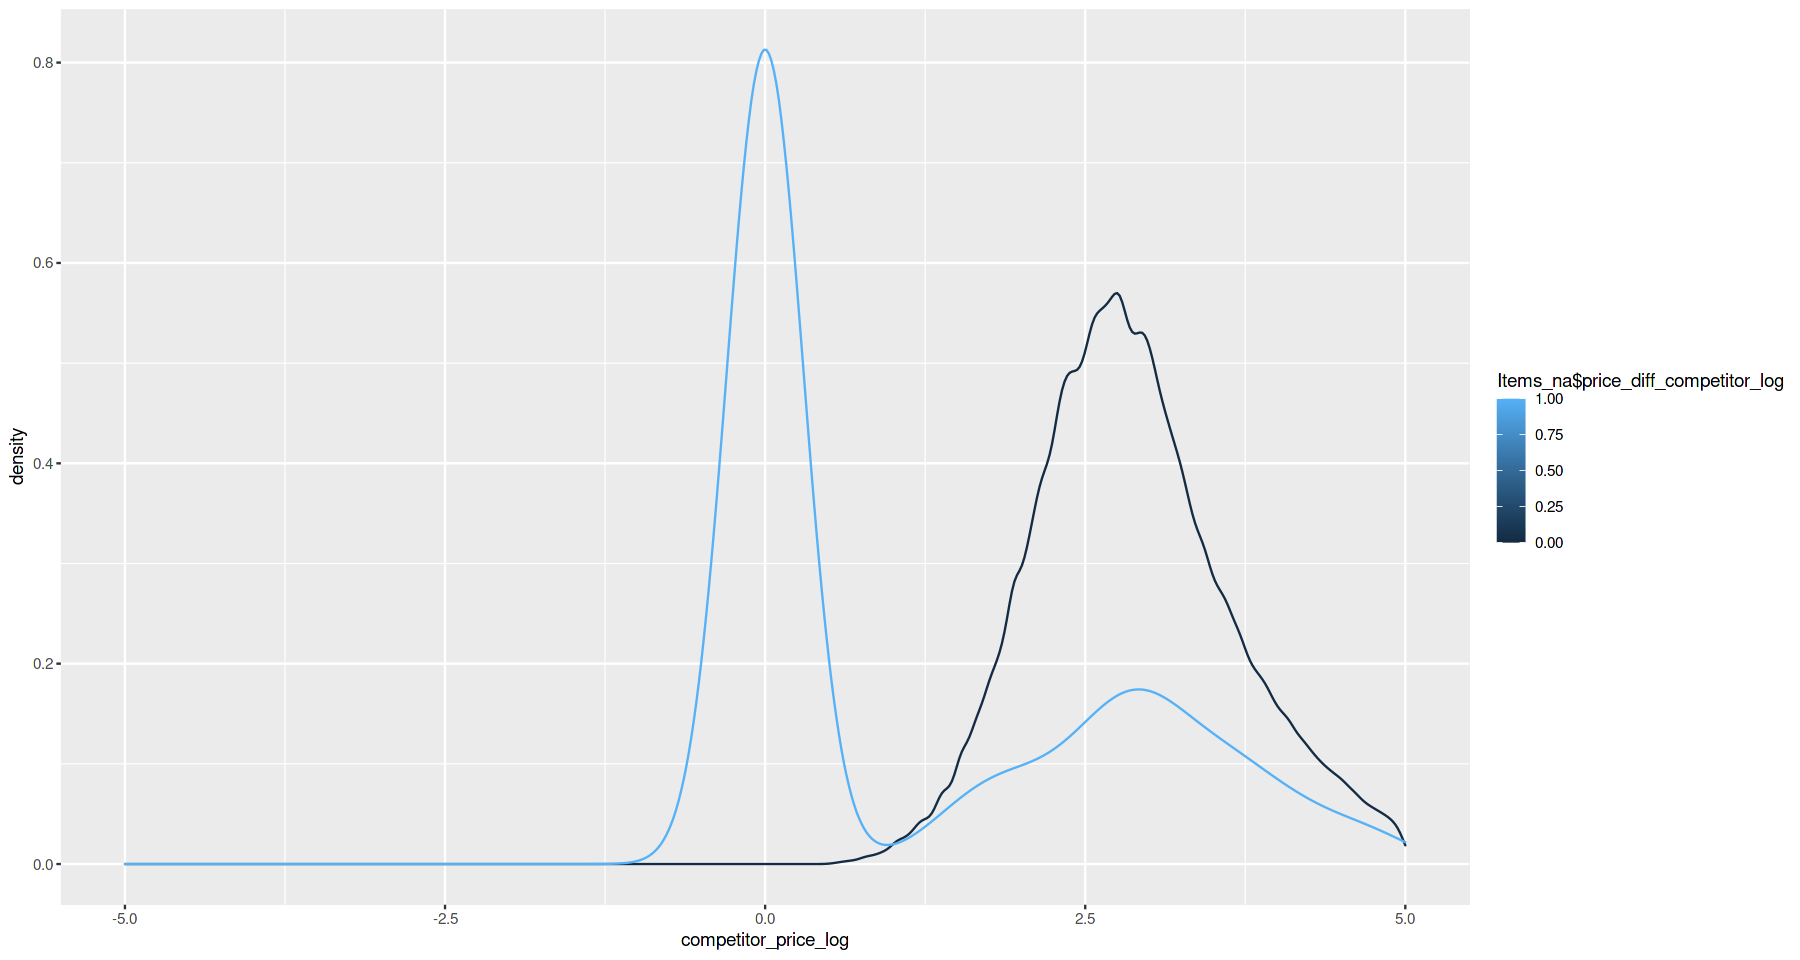

In [66]:
ggplot(data=Items) +
        geom_density(aes(x=amazon_price_log, group=Items_na$price_diff_competitor_log, color=Items_na$price_diff_competitor_log))+ xlim(-5,5)
ggplot(data=Items) +
        geom_density(aes(x=competitor_price_log, group=Items_na$price_diff_competitor_log, color=Items_na$price_diff_competitor_log))+ xlim(-5,5)

variable price_diff_competitor is MNAR, I'll change it to categories

In [67]:
summary(Items$price_diff_competitor_log)
Items$price_diff_competitor_log <- case_when(
  Items$price_diff_competitor_log <= 4.605 ~ "Q1",
  Items$price_diff_competitor_log > 4.605 & Items$price_diff_competitor_log < 4.619 ~ "Q2",
  Items$price_diff_competitor_log >= 4.619 & Items$price_diff_competitor_log < 4.663 ~ "Q3",
  Items$price_diff_competitor_log >= 4.663  ~ "Q4",
  is.na(Items$price_diff_competitor_log) ~ "missing")
Items$price_diff_competitor_log <- as.factor(Items$price_diff_competitor_log)
summary(Items$price_diff_competitor_log)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -4.605   4.605   4.619   4.636   4.664   5.298    2316 

missing      Q1      Q2      Q3      Q4 
   2316   73583  159477  113313  119142

**profit_pct_sqrt**

In [68]:
summary(Items$profit_pct_sqrt)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   4.309   4.714   4.793   5.219  10.000    2997 

In [69]:
Items$profit_pct_sqrt <- case_when(
  Items$profit_pct_sqrt <= 4.307 ~ "Q1",
  Items$profit_pct_sqrt > 4.307 & Items$profit_pct_sqrt < 4.714 ~ "Q2",
  Items$profit_pct_sqrt >= 4.714 & Items$profit_pct_sqrt < 5.218 ~ "Q3",
  Items$profit_pct_sqrt >= 5.218  ~ "Q4",
  is.na(Items$profit_pct_sqrt) ~ "missing")
Items$profit_pct_sqrt <- as.factor(Items$profit_pct_sqrt)
summary(Items$profit_pct_sqrt)

missing      Q1      Q2      Q3      Q4 
   2997  115663  116883  115783  116505

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


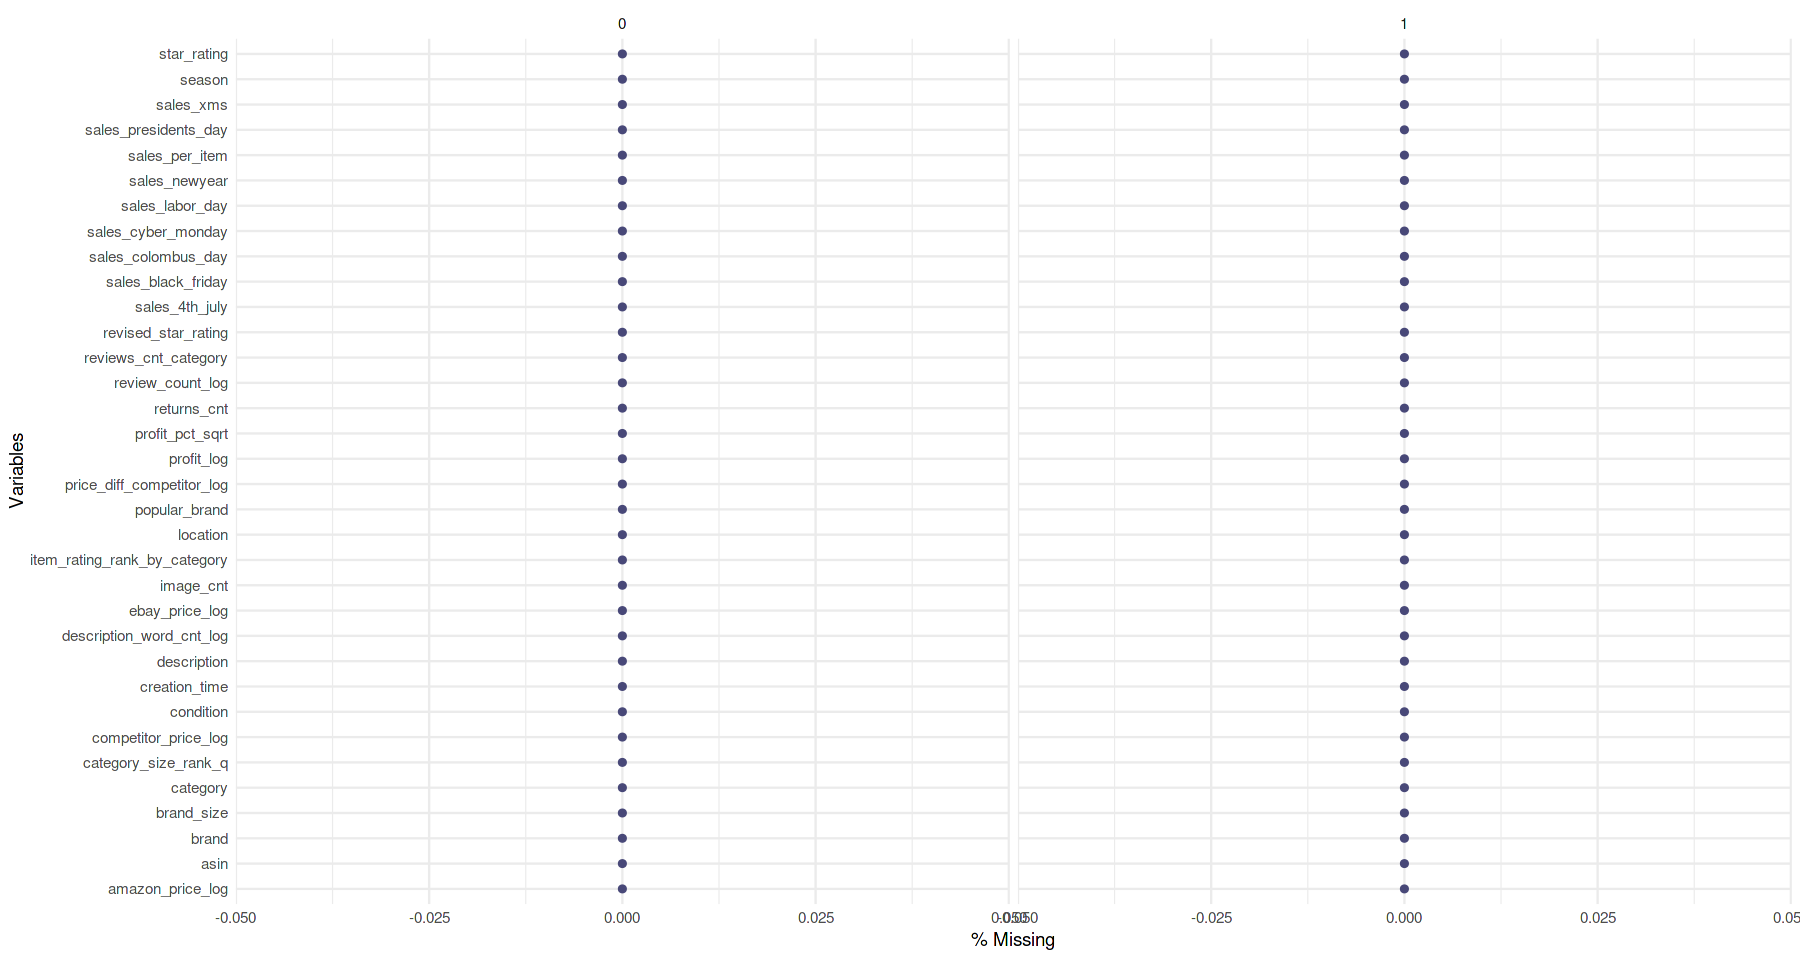

In [70]:
options(repr.plot.width = 15, repr.plot.height = 8)
#Items %>% sample_n(25000) %>% vis_miss(warn_large_data=FALSE,large_data_size=10000000) # table is too large for visualization,
gg_miss_var(Items,show_pct = TRUE, facet= success)

In [71]:
summary(Items$creation_time)

Min.      1st Qu.       Median         Mean      3rd Qu.         Max. 
"2016-11-08" "2020-09-22" "2020-12-03" "2020-12-04" "2021-03-08" "2021-08-19"

**###################################**

# Feature Transformation and Enrichment

all variables with outliers were transformed with log/sqrt previously

In [72]:
encode_ordinal <- function(x, order = unique(x)) {
  x <- as.numeric(factor(x, levels = order, exclude = NULL))
  x
}

In [73]:
strlst1 <- NULL
numlst1 <- NULL
for (v in names(Items)) {
        if (v != 'success') {
            if(is.factor(Items[[v]])) {
                strlst1 <- c(strlst1,v)}
            if (is.numeric(Items[[v]])){
                numlst1 <- c(numlst1,v)}
            }
        }
strlst1
numlst1

[1] "season"                    "location"                 
 [3] "condition"                 "brand"                    
 [5] "returns_cnt"               "star_rating"              
 [7] "revised_star_rating"       "sales_cyber_monday"       
 [9] "sales_black_friday"        "sales_colombus_day"       
[11] "sales_labor_day"           "sales_presidents_day"     
[13] "sales_4th_july"            "sales_newyear"            
[15] "sales_xms"                 "brand_size"               
[17] "reviews_cnt_category"      "popular_brand"            
[19] "review_count_log"          "profit_pct_sqrt"          
[21] "price_diff_competitor_log" "category_size_rank_q"

[1] "image_cnt"                    "sales_per_item"              
[3] "item_rating_rank_by_category" "description_word_cnt_log"    
[5] "ebay_price_log"               "amazon_price_log"            
[7] "competitor_price_log"         "profit_log"

**Feature Engineering**

Text analysis for "Description" variable is located in feature selection notebook since it was added later and coded in python.

Variable **brand**

In [74]:
summary(Items$brand)
#Items %>% arrange(desc(brand)) %>% mutate(brand_rank=1:nrow(df))
Items %>% 
    group_by(brand) %>% 
    summarise(total=n()) %>% arrange(desc(total))

None 
                                      11415 
                             Not Applicable 
                                       4340 
                                     Draper 
                                        911 
                                 Silverline 
                                        872 
                         Learning Resources 
                                        614 
                                    Garnier 
                                        585 
                               Hozelock Ltd 
                                        575 
                                  Playmobil 
                                        548 
                                  Brabantia 
                                        539 
                                      Addis 
                                        537 
                                    mDesign 
                                        418 
                                    Sistema 
                                        412 
                            Spear & Jackson 
                                        400 
                                  Faithfull 
                                        388 
                                       Wera 
                                        363 
                                   Fellowes 
                                        359 
                         Sylvanian Families 
                                        349 
                                    iDesign 
                                        341 
                                       Boao 
                                        340 
                                John Frieda 
                                        331 
                                  STAEDTLER 
                                        328 
                                      Funko 
                                        326 
                                  Galt Toys 
                                        326 
                                      Tefal 
                                        321 
                                       LEGO 
                                        320 
                                      Outus 
                                        318 
                                  Behringer 
                                        310 
                                        MAM 
                                        307 
                                     Rimmel 
                                        307 
                                    Kärcher 
                                        301 
                                     Pentel 
                                        298 
                              TIGI Bed Head 
                                        297 
                                Schwarzkopf 
                                        282 
                              Faber-Castell 
                                        276 
                                    Unibond 
                                        276 
                                   Rosewood 
                                        275 
                            Elizabeth Arden 
                                        272 
                                        OGX 
                                        271 
                               Orchard Toys 
                                        270 
                               Molton Brown 
                                        262 
                                    Bristan 
                                        261 
                                  Relaxdays 
                                        261 
                                    Vallejo 
                                        257 
                                       Hama 
                                        256 
                                Silentnight 
                                  

brand                                        total
1      None                                         11415
2      Not Applicable                                4340
3      Draper                                         911
4      Silverline                                     872
5      Learning Resources                             614
6      Garnier                                        585
7      Hozelock Ltd                                   575
8      Playmobil                                      548
9      Brabantia                                      539
10     Addis                                          537
11     mDesign                                        418
12     Sistema                                        412
13     Spear & Jackson                                400
14     Faithfull                                      388
15     Wera                                           363
16     Fellowes                                       359
17     Sylvanian Families                             349
18     iDesign                                        341
19     Boao                                           340
20     John Frieda                                    331
21     STAEDTLER                                      328
22     Funko                                          326
23     Galt Toys                                      326
24     Tefal                                          321
25     LEGO                                           320
26     Outus                                          318
27     Behringer                                      310
28     MAM                                            307
29     Rimmel                                         307
30     Kärcher                                        301
⋮      ⋮                                            ⋮    
105936 Zylkene                                      1    
105937 Zylkene -C                                   1    
105938 Zyllion                                      1    
105939 Zymol                                        1    
105940 ZYOMY                                        1    
105941 ZYROCCO                                      1    
105942 ZYTJ                                         1    
105943 zytoon                                       1    
105944 ZZ Cream                                     1    
105945 ZZ Lighting                                  1    
105946 ZZAMG                                        1    
105947 Zzcostumes                                   1    
105948 ZZEWINTRAVELER                               1    
105949 ZZHOME                                       1    
105950 ZZK RECORDS                                  1    
105951 ZZKOKO                                       1    
105952 ZZM                                          1    
105953 zzmikiteck                                   1    
105954 Zzooi                                        1    
105955 ZZPCSM                                       1    
105956 zzr                                          1    
105957 ZZRUI                                        1    
105958 ZZYBIA                                       1    
105959 グッドスマイルカンパニー(GOOD SMILE COMPANY) 1    
105960 ノーブランド品                               1    
105961 バンプレスト                                 1    
105962 一美良品 Yimei Good Product                  1    
105963 及源                                         1    
105964 谷优（Gullon）                               1    
105965 香取製作所                                   1

I'll drop this variable since it has too many levels with low number for each category. The variable "popular_brand" uses this data to extract the highest count categories for this variable

Variable **sales_per_item**

change variable **sales_per_item** to show total items sold per specific item id

In [75]:
Items2 <- Items %>% group_by(asin) %>% summarize(sum(sales_per_item))
names(Items2)[names(Items2) == "sum(sales_per_item)"] <- "total_sales"

head(Items2,5)

asin        total_sales
1 /B004FEL7R2 0          
2 /B07ZM6BCSX 1          
3 000004458X  4          
4 0004121295  0          
5 000450013X  0

In [76]:
library(data.table)
a <- setDT(Items)
b <- setDT(Items2)
setDT(a)[b, total_sales := total_sales, on = .(asin)]
setDF(Items)

In [77]:
#Items <- cbind(Items,Items1$total_sales)
names(Items)

[1] "asin"                         "creation_time"               
 [3] "season"                       "location"                    
 [5] "condition"                    "description"                 
 [7] "brand"                        "category"                    
 [9] "image_cnt"                    "returns_cnt"                 
[11] "star_rating"                  "revised_star_rating"         
[13] "sales_cyber_monday"           "sales_black_friday"          
[15] "sales_colombus_day"           "sales_labor_day"             
[17] "sales_presidents_day"         "sales_4th_july"              
[19] "sales_newyear"                "sales_xms"                   
[21] "sales_per_item"               "success"                     
[23] "item_rating_rank_by_category" "brand_size"                  
[25] "reviews_cnt_category"         "popular_brand"               
[27] "description_word_cnt_log"     "review_count_log"            
[29] "ebay_price_log"               "amazon_price_log"            
[31] "competitor_price_log"         "profit_log"                  
[33] "profit_pct_sqrt"              "price_diff_competitor_log"   
[35] "category_size_rank_q"         "total_sales"

In [78]:
Items$brand <- NULL
Items$asin <- NULL
Items$sales_per_item <- NULL

Variable **category**

In [79]:
high_cat <- Items %>% filter(Items$category %in% c('Home, Furniture & DIY','Health & Beauty','Home & Garden'))%>% summarize(n())
p <- high_cat/length(Items1$category)*100
print(c('Percent of the three largest categories:',p))

df1 <- Items %>% 
    group_by(category) %>% summarise(total=n()) 
summary(df1$total)
arrange(df1,desc(total))

[[1]]
[1] "Percent of the three largest categories:"

$`n()`
[1] 41.118



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0   281.5  4050.0 11138.8 13414.8 76293.0 

category                       total
1  Home & Garden                  76293
2  Home, Furniture & DIY          71169
3  Health & Beauty                58128
4  None                           30627
5  Toys                           24590
6  Sporting Goods                 21567
7  Pet Supplies                   18521
8  Crafts                         16604
9  Business, Office & Industrial  16447
10 Clothing, Shoes & Accessories  15396
11 Computers/Tablets & Networking 13725
12 Business & Industrial          12484
13 Vehicle Parts & Accessories    10314
14 Books, Comics & Magazines      10280
15 eBay Motors                     9472
16 Collectibles                    9154
17 Baby                            8681
18 Sound & Vision                  6322
19 Musical Instruments             5817
20 Jewelry & Watches               4830
21 Mobile Phones & Communication   4098
22 Consumer Electronics            4002
23 Cameras & Photography           3315
24 Video Games & Consoles          3087
25 DVDs, Films & TV                2923
26 Music                           2828
27 Dolls & Bears                   2189
28 Books                           2034
29 Cell Phones & Accessories       1297
30 Pottery                          374
31 Sports Mem, Cards & Fan Shop     346
32 Travel                           260
33 Books & Magazines                158
34 Art                              116
35 Movies & TV                      108
36 Coins                            106
37 Wholesale & Job Lots              83
38 Stamps                            66
39 Entertainment Memorabilia          9
40 Sports Memorabilia                 6
41 Antiques                           4
42 Cars, Motorcycles & Vehicles       1

We have many categories with small number of items - I'll create a new category : "low"
I'll use label encoding for the categories

In [80]:
lst <- Items %>%
  group_by(category) %>% summarise(total=n()) %>% filter(total < 1000)# %>% mutate(category = 'low')
Items$category <- ifelse(Items$category %in% lst[['category']],'small_cat',Items$category)
table(Items$category)


                          Baby                          Books 
                          8681                           2034 
     Books, Comics & Magazines          Business & Industrial 
                         10280                          12484 
 Business, Office & Industrial          Cameras & Photography 
                         16447                           3315 
     Cell Phones & Accessories  Clothing, Shoes & Accessories 
                          1297                          15396 
                  Collectibles Computers/Tablets & Networking 
                          9154                          13725 
          Consumer Electronics                         Crafts 
                          4002                          16604 
                 Dolls & Bears               DVDs, Films & TV 
                          2189                           2923 
                   eBay Motors                Health & Beauty 
                          9472                        

I added a new feature : cat_label

labels by the different ebay categories

In [81]:
library(superml)
label <- LabelEncoder$new()
Items$cat_label <- label$fit_transform(Items$category)
head(Items[c('category','cat_label')],20)
table(Items$cat_label)

Loading required package: R6



category                      cat_label
1  Home & Garden                 0        
2  Home & Garden                 0        
3  Home & Garden                 0        
4  Home & Garden                 0        
5  Jewelry & Watches             1        
6  Home & Garden                 0        
7  Home, Furniture & DIY         2        
8  Home & Garden                 0        
9  Clothing, Shoes & Accessories 3        
10 Toys                          4        
11 Health & Beauty               5        
12 Health & Beauty               5        
13 Toys                          4        
14 Sporting Goods                6        
15 Health & Beauty               5        
16 Home & Garden                 0        
17 Health & Beauty               5        
18 Home & Garden                 0        
19 Mobile Phones & Communication 7        
20 Sound & Vision                8


    0     1     2     3     4     5     6     7     8     9    10    11    12 
76293  4830 71169 15396 24590 58128 21567  4098  6322 18521  5817 30627 13725 
   13    14    15    16    17    18    19    20    21    22    23    24    25 
10280 12484  9472  9154  3087 16447 10314 16604  8681  4002  3315  1297  2189 
   26    27    28    29 
 2923  2034  1637  2828 

In [82]:
# drop the 'category' column
Items$category <- NULL

**One hot encoding**

In [83]:
seasons <- levels(Items$season)
levels(Items$season)

[1] "fall"   "spring" "summer" "winter"

In [84]:
Items <- Items %>% mutate(season1 = ifelse(season=='fall',1,0),
                season2 = ifelse(season=='winter',1,0),
                season3 = ifelse(season=='spring',1,0))
Items$season <- NULL

In [85]:
encode_polynomial <- function(df, var) {
  x <- df[[var]]
  x <- unique(x)
  n <- length(x)
  d <- as.data.frame(contr.poly(n))
  d[[var]] <- x
  names(d) <- c(paste0(var, 1:(n-1)), var)
  d
}


In [86]:
levels(Items$condition)
levels(Items$condition) <- c(0,1)
summary(Items$condition)

[1] "new" "ob"

0      1 
444419  23412

In [87]:
levels(Items$location)
levels(Items$location) <- c(0,1)
summary(Items$location)

[1] "uk" "us"

0      1 
287504 180327

In [88]:
levels(Items$popular_brand)
levels(Items$popular_brand) <- c(0,1)
summary(Items$popular_brand)

[1] "no                                                                                                                                                                                                                                                             "
[2] "yes                                                                                                                                                                                                                                                            "

0      1 
463264   4567

In [89]:
for (n in strlst1[7:14]){
    print(n)
    print(levels(Items[[n]]))
}

[1] "revised_star_rating"
[1] "Low"     "missing" "Q1"      "Q2"      "Q3"      "Q4"     
[1] "sales_cyber_monday"
[1] "0" "1"
[1] "sales_black_friday"
[1] "0" "1"
[1] "sales_colombus_day"
[1] "0" "1"
[1] "sales_labor_day"
[1] "0" "1"
[1] "sales_presidents_day"
[1] "0" "1"
[1] "sales_4th_july"
[1] "0" "1"
[1] "sales_newyear"
[1] "0" "1"


**Ordinal encoding**

ordinal categories : "brand_size", "reviews_cnt_category", "profit_pct_sqrt", "review_count_log", "price_diff_competitor_log"

In [90]:
summary(Items$review_count_log)
Items$review_count_log <- encode_ordinal(Items[["review_count_log"]], order = c("missing", "1", "2", "3","4"))
Items$review_count_log <- factor(Items$review_count_log)
summary(Items$review_count_log)

1       2       3       4 missing 
  54837   54694   54630   54843  248827

1      2      3      4      5 
248827  54837  54694  54630  54843

In [91]:
summary(Items$price_diff_competitor_log)
Items$price_diff_competitor_log <- encode_ordinal(Items[["price_diff_competitor_log"]], order = c("missing", "Q1", "Q2", "Q3","Q4"))
Items$price_diff_competitor_log <- factor(Items$price_diff_competitor_log)
summary(Items$price_diff_competitor_log)

missing      Q1      Q2      Q3      Q4 
   2316   73583  159477  113313  119142

1      2      3      4      5 
  2316  73583 159477 113313 119142

In [92]:
summary(Items$brand_size)
Items$brand_size <- encode_ordinal(Items[["brand_size"]], order = c("Not Applicable", "1", "2", "3"))
Items$brand_size <- factor(Items$brand_size)
summary(Items$brand_size)

1              2              3 Not Applicable 
         44151          36516         382825           4339

1      2      3      4 
  4339  44151  36516 382825

In [93]:
#Items$reviews_cnt_category <- Items1$reviews_cnt_category
summary(Items$reviews_cnt_category)
levels(Items$reviews_cnt_category) <- c("high","low","med")
Items$reviews_cnt_category <- encode_ordinal(Items[["reviews_cnt_category"]], order = c("low","med","high"))
Items$reviews_cnt_category <- factor(Items$reviews_cnt_category)
summary(Items$reviews_cnt_category)

high                                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                                          54879 
low                                                                                                                                                                                                                                                             
                                                                                                                                                                                                                                                          49342 
med                                                                                                                                                                                                                                                             
                                                                                                                                                                                                                                                         363610

1      2      3 
 49342 363610  54879

In [94]:
summary(Items$profit_pct_sqrt)
Items$profit_pct_sqrt <- encode_ordinal(Items[["profit_pct_sqrt"]], order = c("missing","Q1","Q2","Q3","Q4"))
Items$profit_pct_sqrt <- factor(Items$profit_pct_sqrt)
summary(Items$profit_pct_sqrt)

missing      Q1      Q2      Q3      Q4 
   2997  115663  116883  115783  116505

1      2      3      4      5 
  2997 115663 116883 115783 116505

In [95]:
summary(Items$revised_star_rating)
Items$revised_star_rating <- encode_ordinal(Items[["revised_star_rating"]], order = c("missing","Low","Q1","Q2","Q3","Q4"))
Items$revised_star_rating <- factor(Items$revised_star_rating)
summary(Items$revised_star_rating)

Low missing      Q1      Q2      Q3      Q4 
  49342  248827    5399   25282   84220   54761

1      2      3      4      5      6 
248827  49342   5399  25282  84220  54761

In [96]:
summary(Items$star_rating)
Items$star_rating <- encode_ordinal(Items[["star_rating"]], order = c("missing","1","2","3","4"))
Items$star_rating <- factor(Items$star_rating)
summary(Items$star_rating)

1       2       3       4 missing 
  52531   25334   75024   66367  248575

1      2      3      4      5 
248575  52531  25334  75024  66367

library(recipes)
rec <- recipe(ebay_price_log ~., data = Items)

int_mod_1 <- rec %>%
  step_interact(terms = ~ ebay_price_log:image_cnt)

int_mod_1 <- prep(int_mod_1, training = Items)
dat_1 <- bake(int_mod_1, Items)

**Numeric Variables normalization**

In [97]:
#added new variables
strlst1 <- NULL
numlst1 <- NULL
for (v in names(Items)) {
        if (v != 'success') {
            if(is.factor(Items[[v]])) {
                strlst1 <- c(strlst1,v)}
            if (is.numeric(Items[[v]])){
                numlst1 <- c(numlst1,v)}
            }
        }
strlst1
numlst1

[1] "location"                  "condition"                
 [3] "returns_cnt"               "star_rating"              
 [5] "revised_star_rating"       "sales_cyber_monday"       
 [7] "sales_black_friday"        "sales_colombus_day"       
 [9] "sales_labor_day"           "sales_presidents_day"     
[11] "sales_4th_july"            "sales_newyear"            
[13] "sales_xms"                 "brand_size"               
[15] "reviews_cnt_category"      "popular_brand"            
[17] "review_count_log"          "profit_pct_sqrt"          
[19] "price_diff_competitor_log" "category_size_rank_q"

[1] "image_cnt"                    "item_rating_rank_by_category"
 [3] "description_word_cnt_log"     "ebay_price_log"              
 [5] "amazon_price_log"             "competitor_price_log"        
 [7] "profit_log"                   "total_sales"                 
 [9] "cat_label"                    "season1"                     
[11] "season2"                      "season3"

In [98]:
summary(Items[numlst1])

   image_cnt      item_rating_rank_by_category description_word_cnt_log
 Min.   : 0.000   Min.   :   1                 Min.   :0.000           
 1st Qu.: 1.000   1st Qu.: 829                 1st Qu.:2.303           
 Median : 4.000   Median :1161                 Median :2.944           
 Mean   : 5.082   Mean   :1109                 Mean   :3.120           
 3rd Qu.: 8.000   3rd Qu.:1453                 3rd Qu.:3.526           
 Max.   :16.000   Max.   :1617                 Max.   :9.626           
 ebay_price_log  amazon_price_log competitor_price_log   profit_log   
 Min.   :0.000   Min.   :0.000    Min.   :0.000        Min.   :2.304  
 1st Qu.:2.498   1st Qu.:2.224    1st Qu.:2.337        1st Qu.:4.958  
 Median :2.949   Median :2.680    Median :2.815        Median :4.970  
 Mean   :3.035   Mean   :2.766    Mean   :2.895        Mean   :4.990  
 3rd Qu.:3.480   3rd Qu.:3.218    3rd Qu.:3.367        3rd Qu.:4.993  
 Max.   :8.216   Max.   :7.833    Max.   :8.216        Max.   :7.775  

In [99]:
min_max_norm <- function(x) {
    (x - min(x)) / (max(x) - min(x))
  }

In [100]:
Items_standardize <- as.data.frame(scale(Items[numlst1]))
head(Items_standardize)

image_cnt  item_rating_rank_by_category description_word_cnt_log
1 -0.9326059 -0.3179238                   0.1434421               
2 -0.9326059 -0.3179238                   0.1434421               
3 -0.9326059 -0.3179238                   0.1434421               
4 -0.9326059 -0.3179238                   0.1434421               
5  0.4381886 -2.0099838                   1.1420415               
6 -0.9326059 -0.3441573                   0.4000915               
  ebay_price_log amazon_price_log competitor_price_log profit_log total_sales
1 -0.7178001     -0.5269207       -0.2285889           -0.6226957  2.3410535 
2 -0.6647397     -0.5755700       -0.2285889           -0.5336484  2.3410535 
3 -0.6089841     -0.5755700       -0.2285889           -0.4800322  2.3410535 
4  0.1557203      0.2197388       -0.2285889           -0.3341428  2.3410535 
5 -0.9822720     -0.7811999       -0.7746579           -0.5845369 -0.3591574 
6 -0.3459885     -0.2200101       -0.1682301           -0.3660522  0.1808848 
  cat_label  season1    season2    season3   
1 -1.0890085 -0.6708601 -0.5828432  2.1203764
2 -1.0890085 -0.6708601 -0.5828432  2.1203764
3 -1.0890085 -0.6708601 -0.5828432  2.1203764
4 -1.0890085 -0.6708601 -0.5828432  2.1203764
5 -0.9506483 -0.6708601  1.7157238 -0.4716134
6 -1.0890085 -0.6708601 -0.5828432  2.1203764

In [101]:
for (n in numlst1){
    Items[[n]] <- Items_standardize[[n]]
}
head(Items,1)

creation_time location condition
1 2019-04-03    1        0        
  description                                                                                                                                                                       
1 Aplstar E26 E27 Light Socket,8-pack Black Edison Retro Pendant lamp holder, E26 E27 Plastic Standard Screw-in Socket Maximum Wattage 250W Heat Resistant Up to 200℃ Fire Resistant
  image_cnt  returns_cnt star_rating revised_star_rating sales_cyber_monday
1 -0.9326059 0           4           5                   0                 
  sales_black_friday ⋯ competitor_price_log profit_log profit_pct_sqrt
1 0                  ⋯ -0.2285889           -0.6226957 2              
  price_diff_competitor_log category_size_rank_q total_sales cat_label
1 2                         1                    2.341054    -1.089008
  season1    season2    season3 
1 -0.6708601 -0.5828432 2.120376

In [102]:
summary(Items)

 creation_time        location   condition  description       
 Min.   :2016-11-08   0:287504   0:444419   Length:467831     
 1st Qu.:2020-09-22   1:180327   1: 23412   Class :character  
 Median :2020-12-03                         Mode  :character  
 Mean   :2020-12-04                                           
 3rd Qu.:2021-03-08                                           
 Max.   :2021-08-19                                           
                                                              
   image_cnt       returns_cnt star_rating revised_star_rating
 Min.   :-1.1611   0:442384    1:248575    1:248827           
 1st Qu.:-0.9326   1: 25447    2: 52531    2: 49342           
 Median :-0.2472               3: 25334    3:  5399           
 Mean   : 0.0000               4: 75024    4: 25282           
 3rd Qu.: 0.6667               5: 66367    5: 84220           
 Max.   : 2.4944                           6: 54761           
                                                       

In [103]:
fwrite(Items, "./Items_ff_final5.csv")